In [28]:
%reload_ext autoreload
%autoreload 2
import json
import logging
import numpy as np
import pandas as pd
import seaborn as sns
from pyeed import Pyeed
import matplotlib.pyplot as plt
from pyeed.analysis.embedding_analysis import EmbeddingTool
import itertools
from scipy.spatial.distance import pdist, squareform

# SetUp

In [29]:
from dotenv import load_dotenv
import os

load_dotenv()  # Load variables from .env
password = os.getenv("NEO4J_NIKLAS_JUST_TEMS")
if password is None:
    raise ValueError("KEY is not set in the .env file.")

In [30]:
uri = "bolt://127.0.0.1:1123"
user = "neo4j"

eedb = Pyeed(uri, user=user, password=password)

📡 Connected to database.


In [31]:
# read in the pandas dataframe
df = pd.read_csv('/home/nab/Niklas/TEM-lactamase/data/002_combined_data/TEM_lactamase.csv', sep=';')
print(df.head())

# df.to_csv('/home/nab/Niklas/TEM-lactamase/data/002_combined_data/TEM_lactamase.csv', sep=';', index=False)

  protein_name phenotype    protein_id protein_id_database
0        TEM-1        2b      AAP20891          AAP20891.1
1        TEM-2        2b      CAJ85677          CAJ85677.1
2        TEM-3       2be      SAQ02853          SAQ02853.1
3        TEM-4       2be      CDR98216          CDR98216.1
4        TEM-5       2be  WP_109963600      WP_109963600.1


In [32]:
ids = df['protein_id_database'].dropna().tolist()
labels = df['phenotype'].tolist()

# pd.nan should be None
labels = [None if pd.isna(x) else x for x in labels]

dict_id_label = {}
for i in range(len(ids)):
    dict_id_label[ids[i]] = labels[i]

print(len(ids))
print(len(labels))

209
265


In [33]:
# we now load the previously saved distance matrix and protein ids
distance_matrix_embeddings_cosine = np.load("/home/nab/Niklas/TEM-lactamase/data/002_combined_data/distance_matrix_embedding_cosine.npy")
distance_matrix_embeddings_euclidean = np.load("/home/nab/Niklas/TEM-lactamase/data/002_combined_data/distance_matrix_embedding_euclidean.npy")
protein_ids_embedding = np.load("/home/nab/Niklas/TEM-lactamase/data/002_combined_data/protein_ids_embedding.npy")

distance_matrix_pairwise = np.load("/home/nab/Niklas/TEM-lactamase/data/002_combined_data/distance_matrix_pairwise_default_methode.npy")
protein_ids_pairwise = np.load("/home/nab/Niklas/TEM-lactamase/data/002_combined_data/protein_ids_pairwise_default_methode.npy")

distance_matrix_mutations = np.load("/home/nab/Niklas/TEM-lactamase/data/002_combined_data/distance_matrix_mutations.npy")
protein_ids_mutations = np.load("/home/nab/Niklas/TEM-lactamase/data/002_combined_data/protein_ids_mutations.npy")

# Disprove TSNE Algorithm

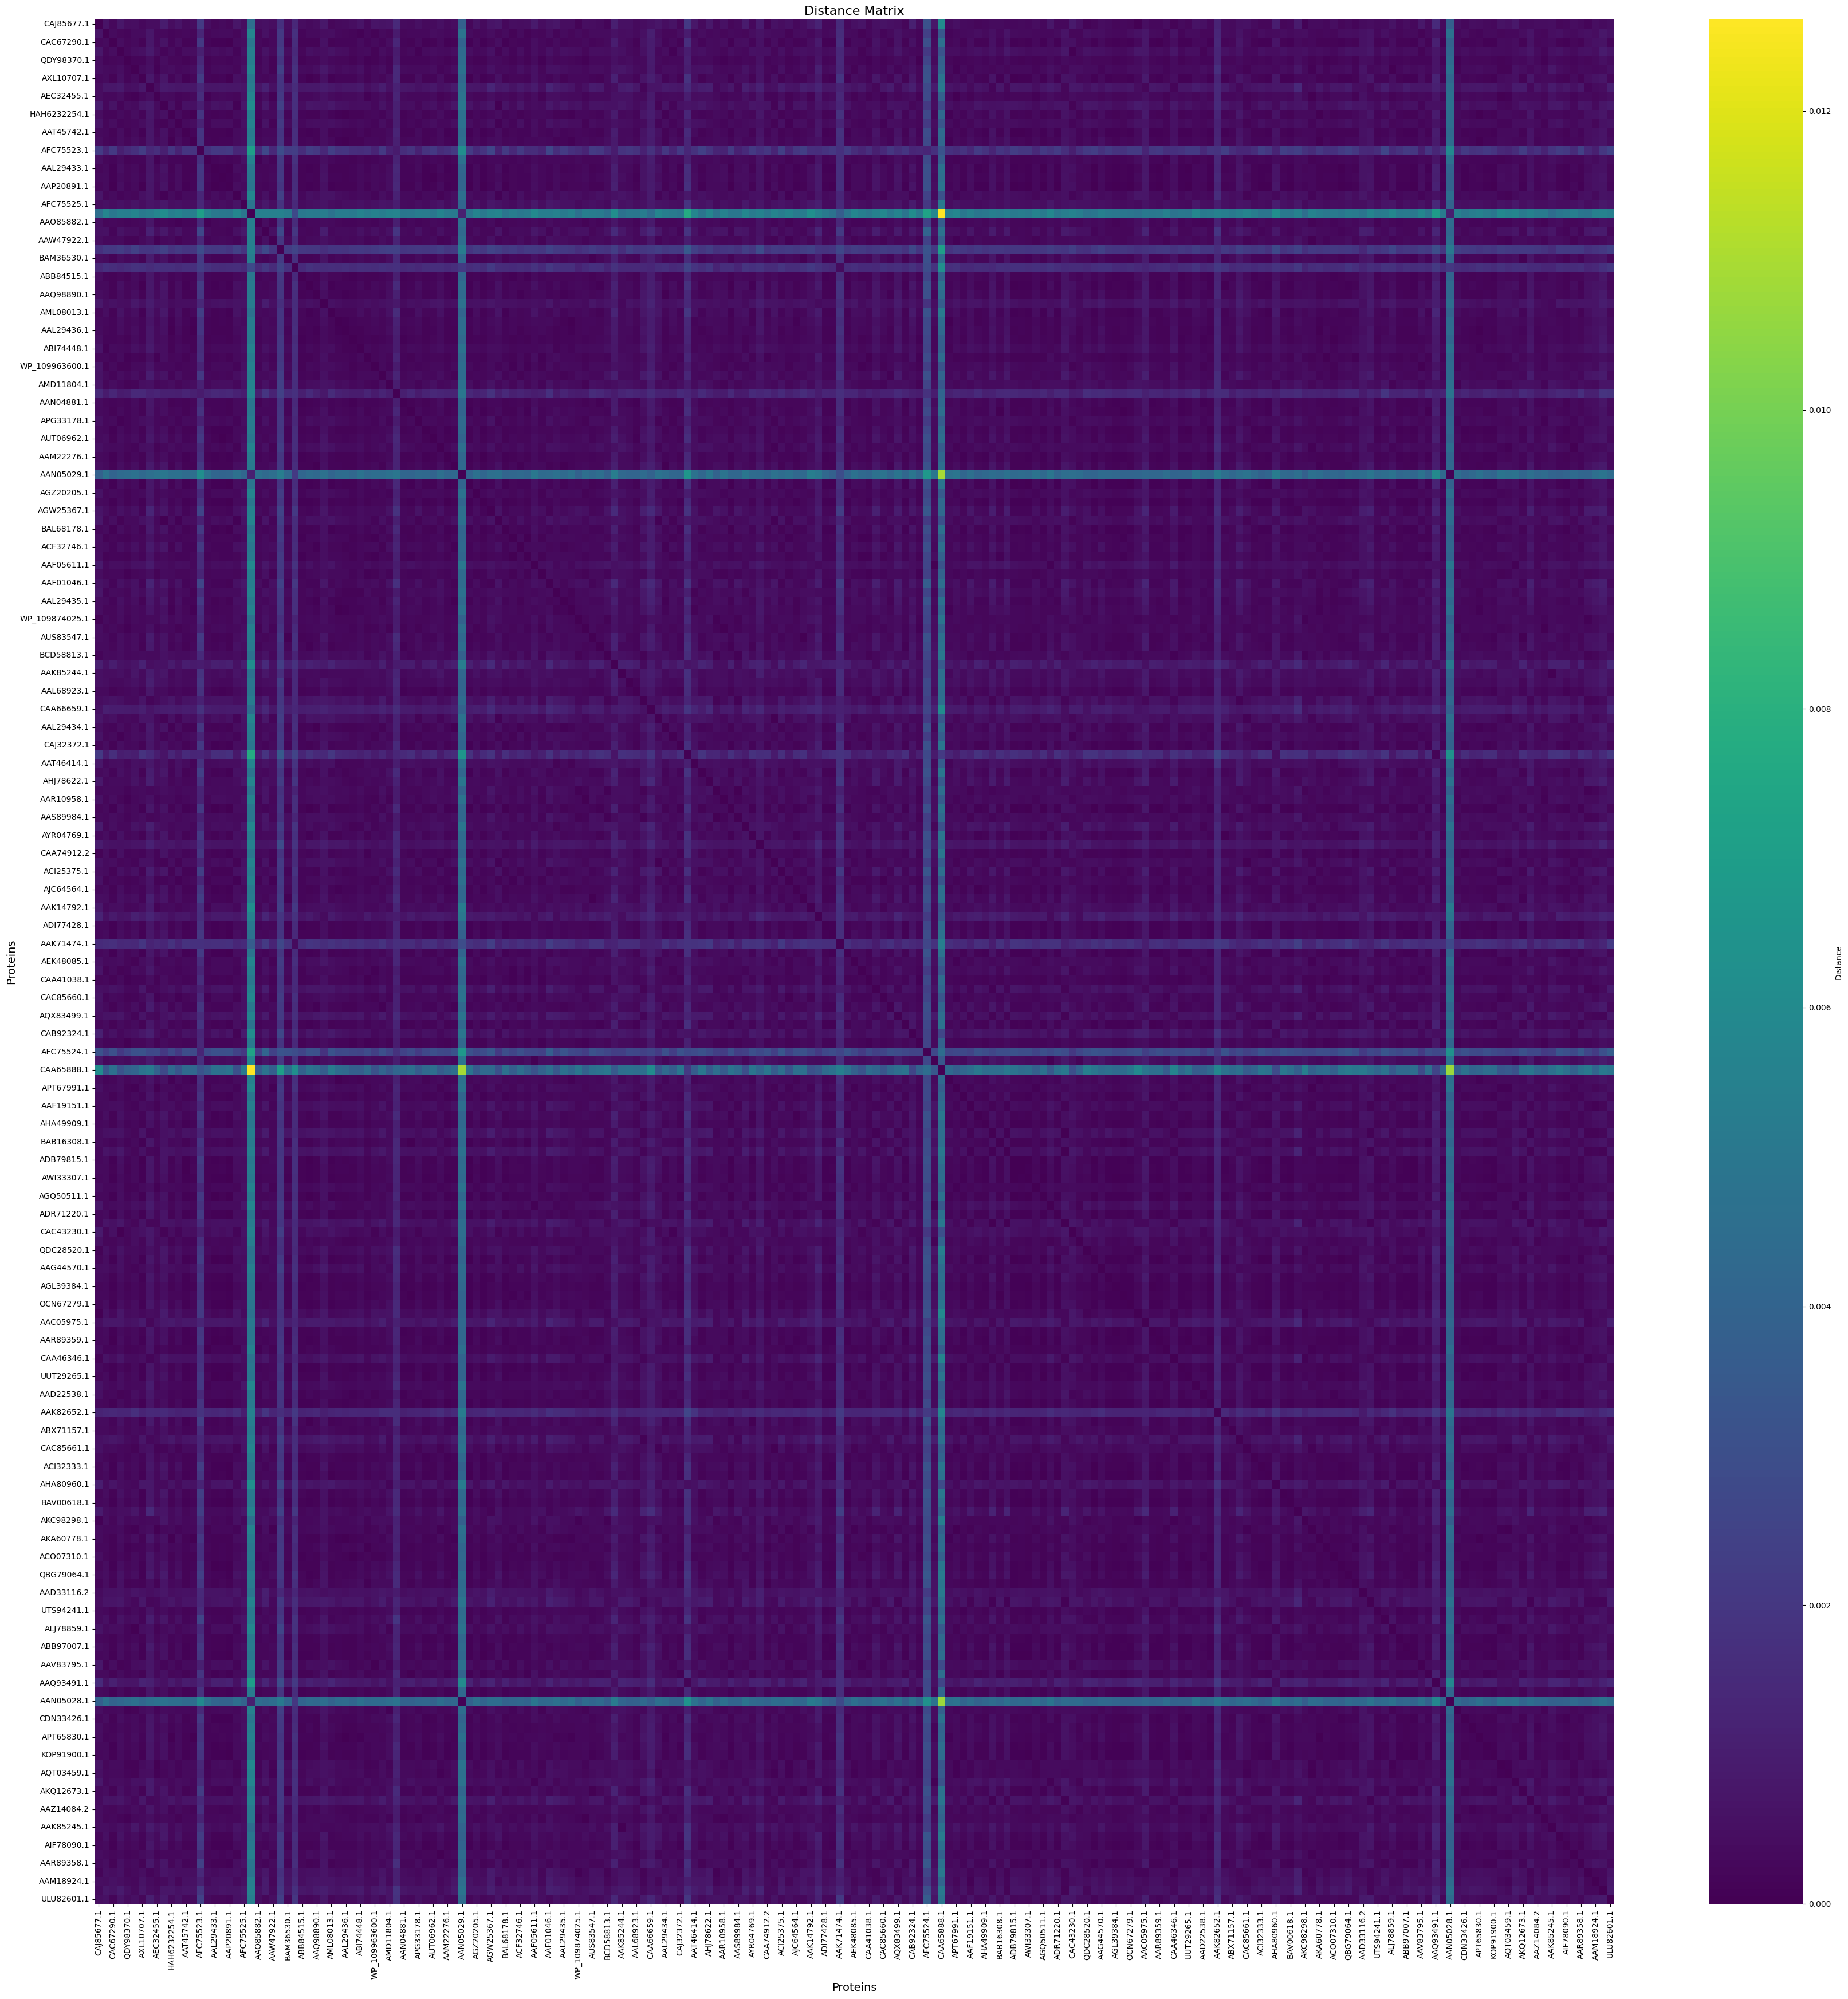

In [34]:
# Example data
proteins = protein_ids_embedding
distances = distance_matrix_embeddings_cosine

# Convert the distance array to a DataFrame for better labeling
distance_df = pd.DataFrame(distances, index=proteins, columns=proteins)

# Plot the heatmap
plt.figure(figsize=(35, 35))
sns.heatmap(
    distance_df, 
    annot=False,
    fmt=".2f",           
    cmap="viridis",      
    cbar_kws={'label': 'Distance'},
    annot_kws={"size": 2},
)

# Add titles and labels
plt.title("Distance Matrix", fontsize=16)
plt.xlabel("Proteins", fontsize=14)
plt.ylabel("Proteins", fontsize=14)

# Display the plot
plt.tight_layout()
plt.show()

In [35]:
# get me the 10 most unsimilar proteins
# Get the upper triangle of the distance matrix (excluding diagonal)
upper_triangle = np.triu(distances, k=1)

# Get indices of the 10 largest distances
max_indices = np.unravel_index(np.argsort(upper_triangle.ravel())[-10:], upper_triangle.shape)

# Create a list of protein pairs and their distances
dissimilar_pairs = []
for i, j in zip(max_indices[0], max_indices[1]):
    if i < j:  # Only take pairs from upper triangle
        dissimilar_pairs.append((proteins[i], proteins[j], distances[i,j]))

# Sort by distance in descending order
dissimilar_pairs.sort(key=lambda x: x[2], reverse=True)

# Print the results
print("\n10 Most Dissimilar Protein Pairs:")
print("Protein 1\tProtein 2\tDistance")
print("-" * 50)
for p1, p2, dist in dissimilar_pairs:
    print(f"{p1}\t{p2}\t{dist:.4f}")




10 Most Dissimilar Protein Pairs:
Protein 1	Protein 2	Distance
--------------------------------------------------
AEQ59620.1	CAA65888.1	0.0126
AAN05029.1	CAA65888.1	0.0109
CAA65888.1	AAN05028.1	0.0107
AEQ59620.1	AAQ93490.1	0.0077
AEQ59620.1	AFC75524.1	0.0073
QPG87090.1	CAA65888.1	0.0071
AFC75523.1	AEQ59620.1	0.0071
AEQ59620.1	AAQ93491.1	0.0070
AAN05029.1	AFC75524.1	0.0067
AAN05029.1	AAQ93490.1	0.0066


In [36]:
# now the same thing as above but the n most unsimular proteins on average over all other proteins
# Calculate mean distance for each protein to all other proteins
mean_distances = np.mean(distances, axis=1)

# Get indices of proteins sorted by mean distance (descending)
sorted_indices = np.argsort(mean_distances)[::-1]

# Get top 10 most dissimilar proteins
top_10_dissimilar = sorted_indices[:10]

# Create list of proteins and their mean distances
dissimilar_proteins = [(proteins[i], mean_distances[i]) for i in top_10_dissimilar]

dissimilary_score = [(proteins[i], mean_distances[i]) for i in sorted_indices]

# Print the results
print("\n10 Most Dissimilar Proteins (by average distance):")
print("Protein\tMean Distance")
print("-" * 40)
for protein, mean_dist in dissimilar_proteins:
    print(f"{protein}\t{mean_dist:.4f}")



10 Most Dissimilar Proteins (by average distance):
Protein	Mean Distance
----------------------------------------
AEQ59620.1	0.0053
CAA65888.1	0.0044
AAN05029.1	0.0044
AAN05028.1	0.0043
AFC75524.1	0.0028
QPG87090.1	0.0022
AFC75523.1	0.0018
AAD45935.1	0.0017
AAK71474.1	0.0016
AAQ93490.1	0.0015


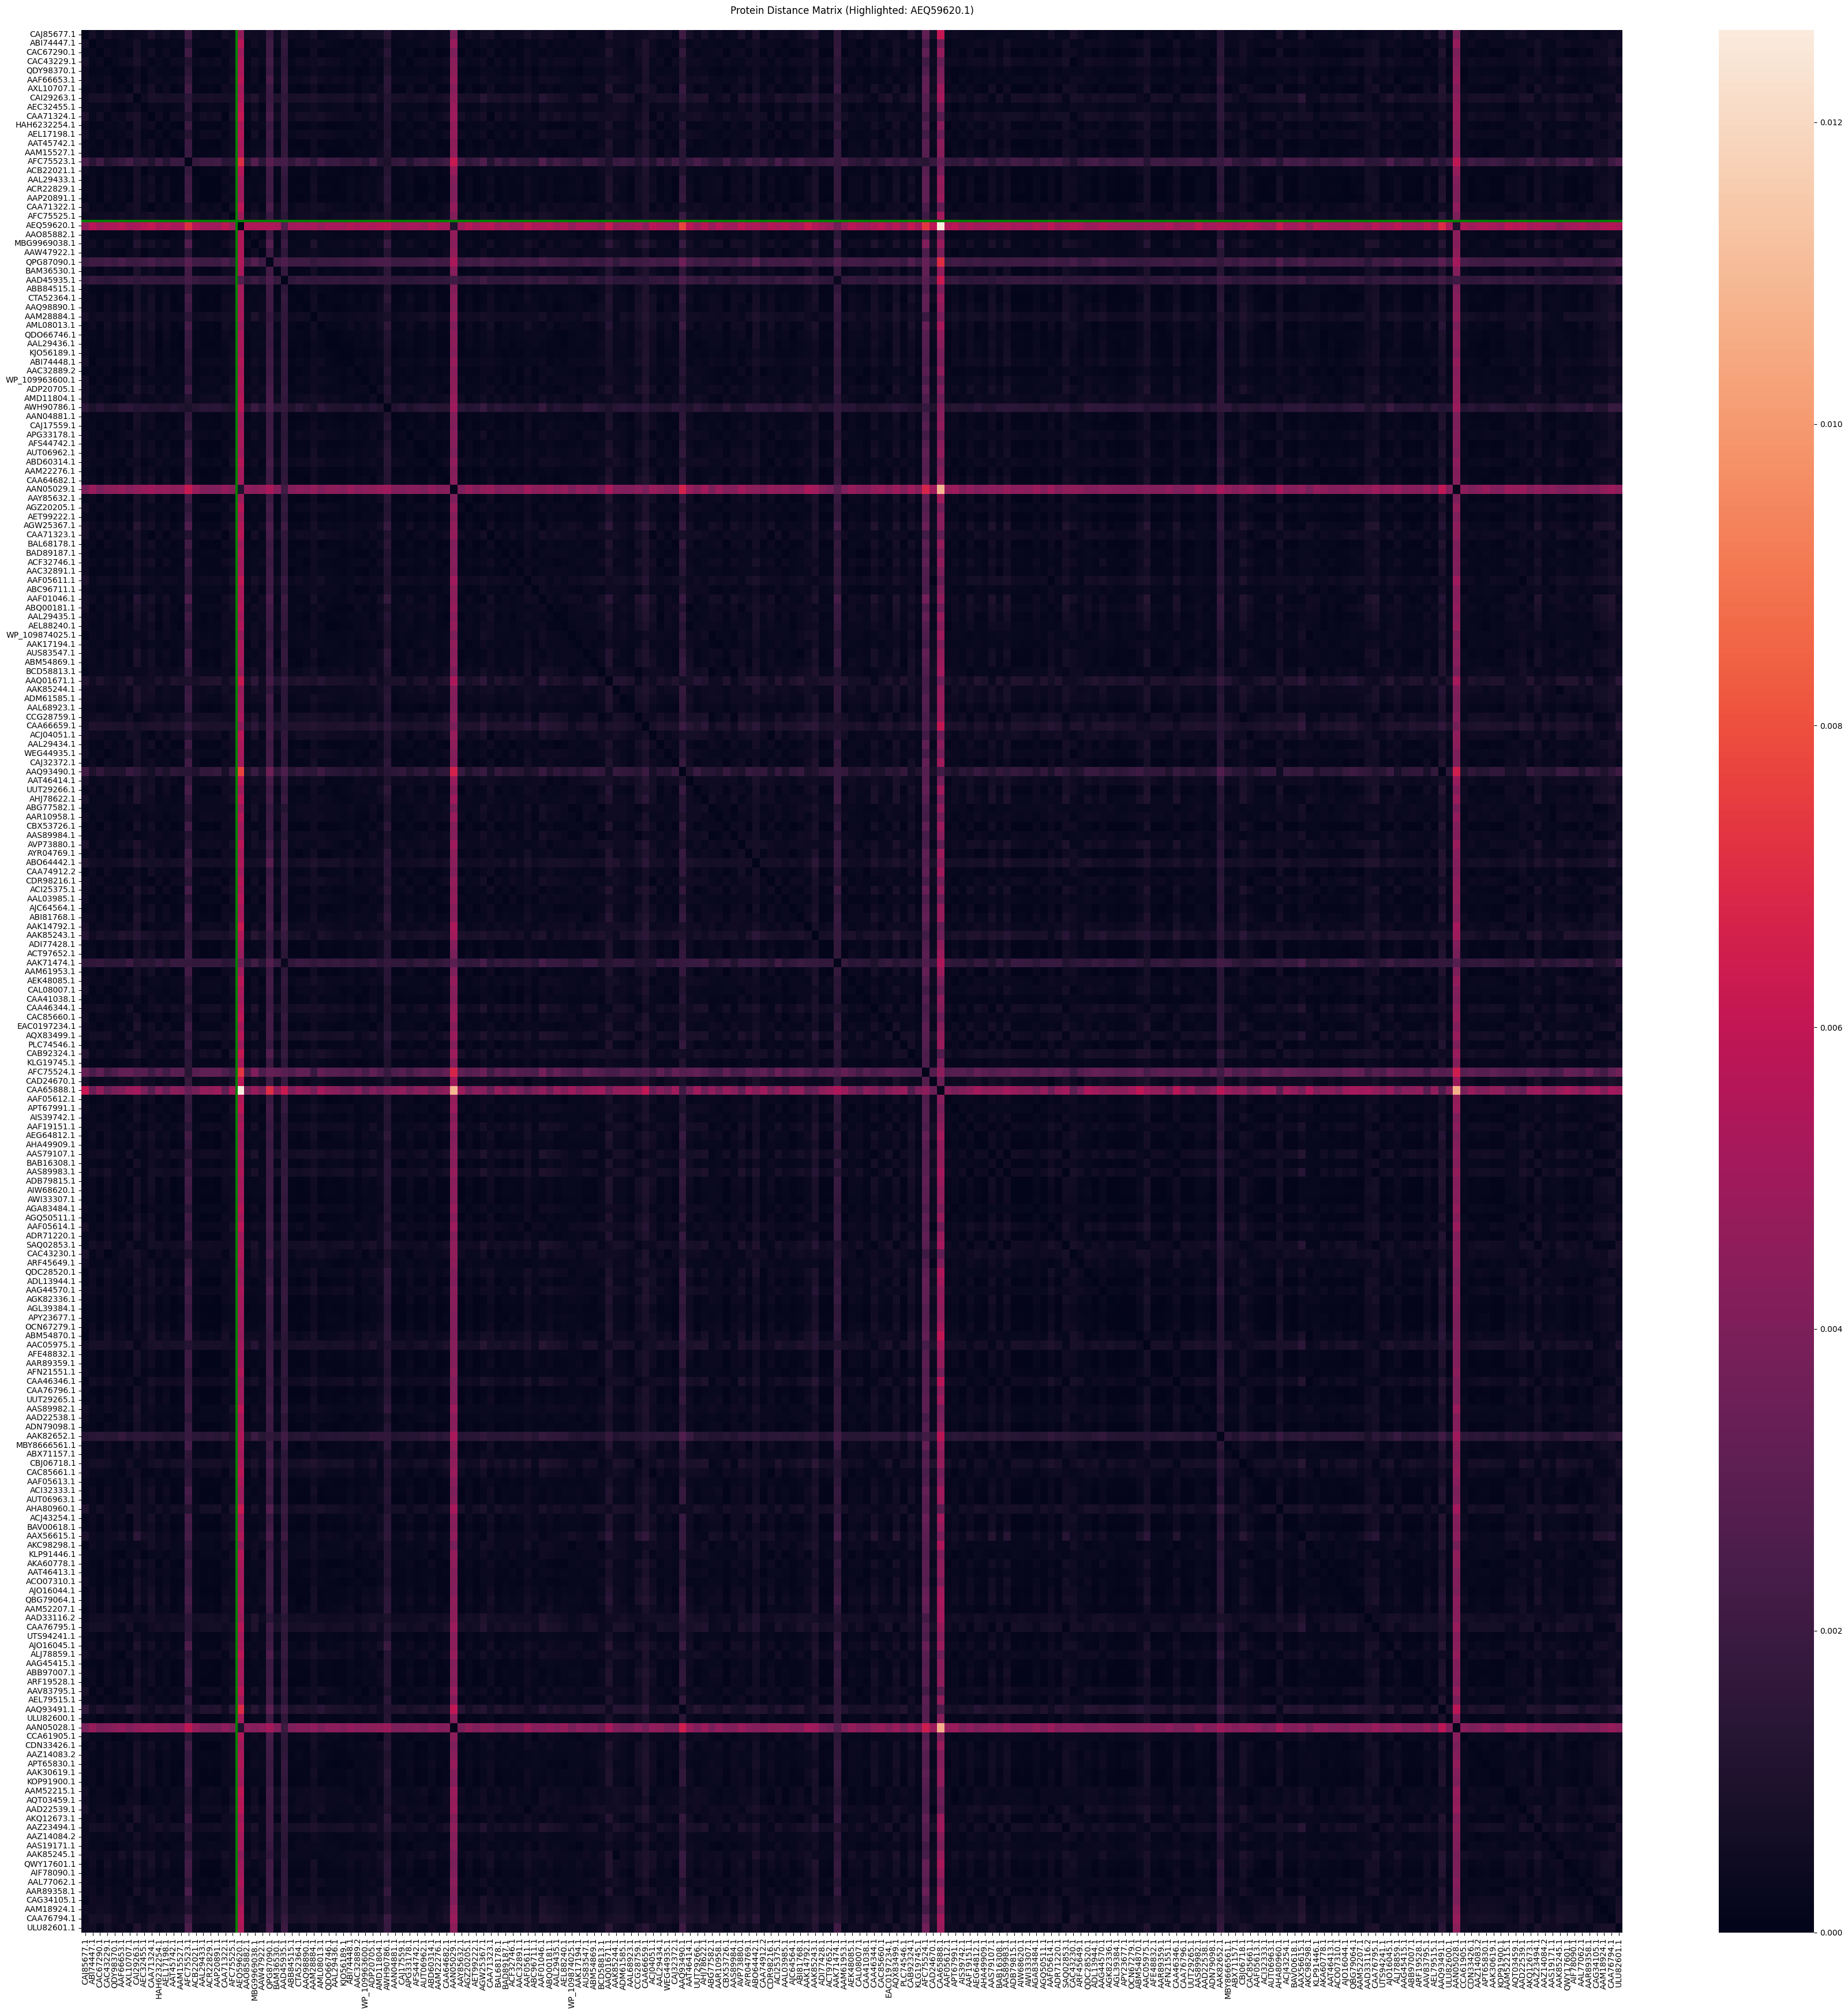

In [37]:
# plot the same matrix again but highlight the follwoing row with a special label so i can find them
# AEQ59620.1

# Create a new figure with a larger size
plt.figure(figsize=(35, 35))

# Create the heatmap
sns.heatmap(distances, xticklabels=proteins, yticklabels=proteins)

# Find the index of AEQ59620.1
highlight_protein = 'AEQ59620.1'
# protein ist just a list of strings
highlight_idx = proteins.tolist().index(highlight_protein)

# Highlight the row and column
plt.axhline(y=highlight_idx, color='green', linewidth=3)
plt.axvline(x=highlight_idx, color='green', linewidth=3)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Add a title
plt.title('Protein Distance Matrix (Highlighted: AEQ59620.1)', pad=20)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()


In [38]:
# group the dissimilary score into 10 groups and give them as a lable their group number
# split the dissimiliatry score in two categories but do it based on the mean distance
# meaning do not just make the half of the proteins into one group and the other half into another group
# but make it based on the mean distance
# make it so i can determine the number of groups i want to make
# Get mean distance for each protein
mean_distances = np.mean(distances, axis=1)
from sklearn.cluster import KMeans
# Number of groups to create
n_groups = 4  # This is the number of groups we want to make

# Use KMeans clustering on the mean distances
kmeans = KMeans(n_clusters=n_groups, random_state=42)
# Reshape mean_distances to 2D array as required by KMeans
clusters = kmeans.fit_predict(mean_distances.reshape(-1, 1))

# Create empty lists to store proteins for each group
dissimilary_score_groups = [[] for _ in range(n_groups)]
dissimilary_score_groups_labels = [f"Group_{i+1}" for i in range(n_groups)]

# Assign proteins to their respective groups
for i, (protein, cluster) in enumerate(zip(proteins, clusters)):
    # Store tuple of (protein_id, mean_distance) in appropriate group
    dissimilary_score_groups[cluster].append((protein, mean_distances[i]))

# Sort proteins within each group by their mean distance
for group in dissimilary_score_groups:
    group.sort(key=lambda x: x[1])



# now add them to the dict_id_label
for i in range(len(dissimilary_score_groups)):
    for protein in dissimilary_score_groups[i]:
        dict_id_label[protein[0]] = dissimilary_score_groups_labels[i]


Number of proteins in visualization: 209
{'Group_3', 'Group_2', 'Group_1', 'Group_4'}
{'Group_3': 'green', 'Group_2': 'orange', 'Group_1': 'blue', 'Group_4': 'red'}


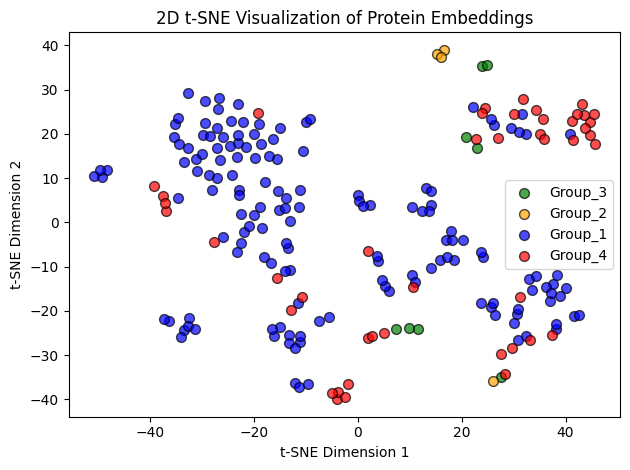

In [39]:
embedding_tool = EmbeddingTool()

# get all of the data from embedding
protein_ids, embeddings_2d, labels, colors = embedding_tool.calculate_2d_projection_tsne(db = eedb.db, ids_list=ids, ids_list_labels=dict_id_label, perplexity=8, n_iter=3000, random_state=42)

print(f"Number of proteins in visualization: {len(protein_ids)}")

# make the None objects to 'None' in labels
labels = ['None' if x is None else x for x in labels]

# create a scatter plot for each unique label
unique_labels = set(labels)
unique_color_labels = {}
print(unique_labels)
for label in unique_labels:
    indices = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(
        [embeddings_2d[i, 0] for i in indices],
        [embeddings_2d[i, 1] for i in indices],
        c=[colors[indices[0]]],
        label=label,
        alpha=0.7,
        s=50,
        edgecolor="k",
    )
    
    # store the color for the label
    unique_color_labels[label] = colors[indices[0]]

print(unique_color_labels)

plt.title("2D t-SNE Visualization of Protein Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.tight_layout()
plt.show()

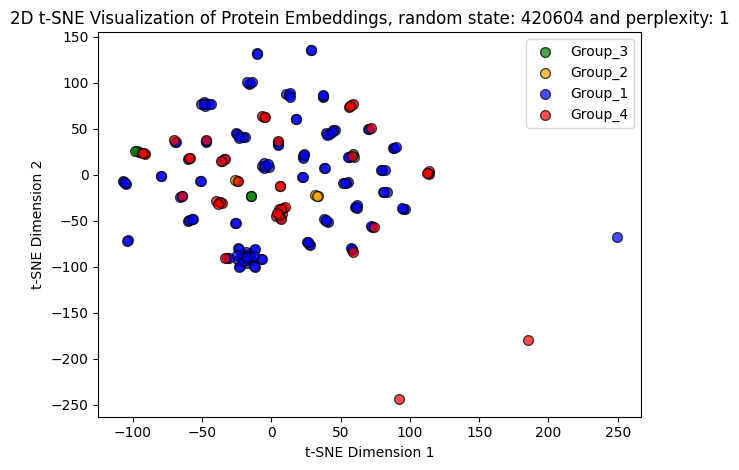

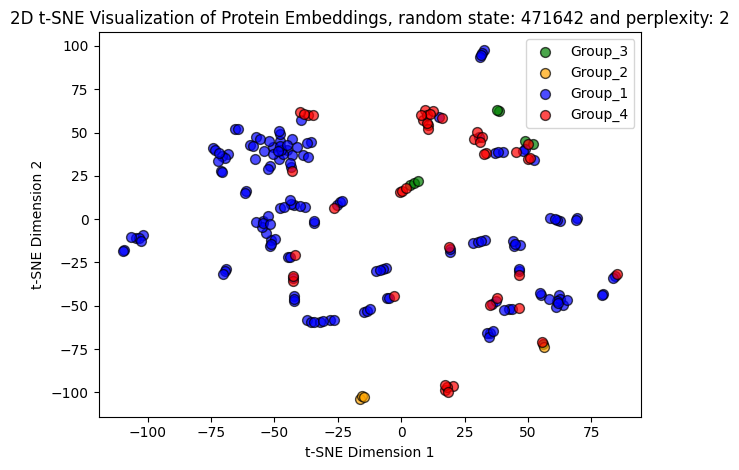

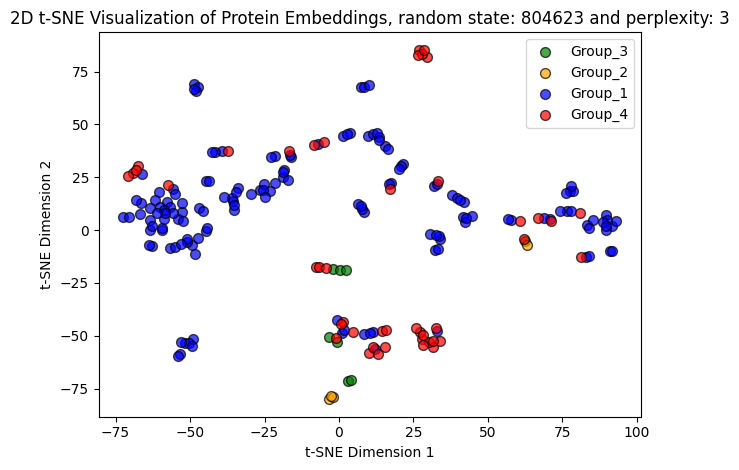

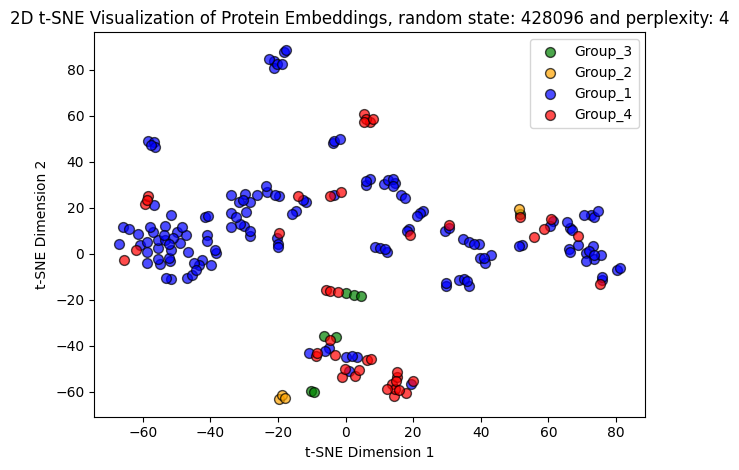

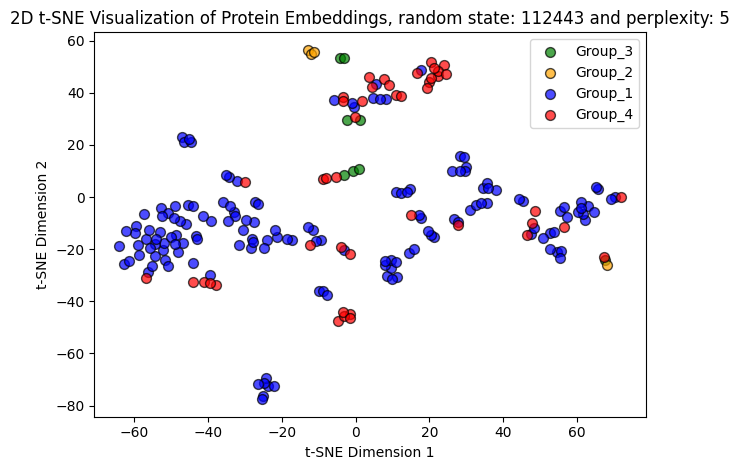

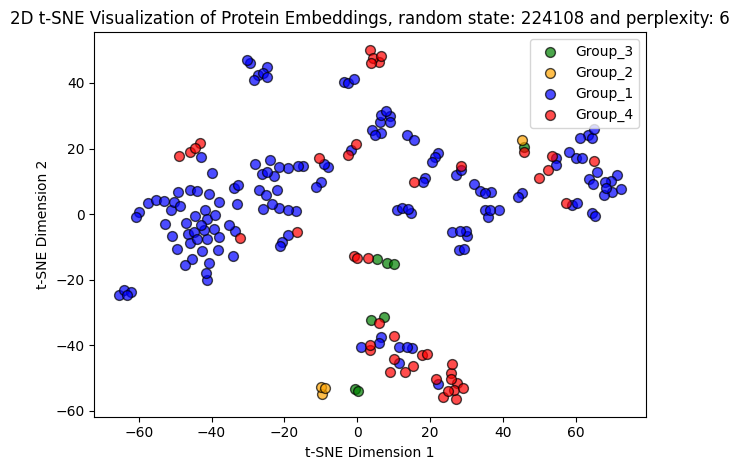

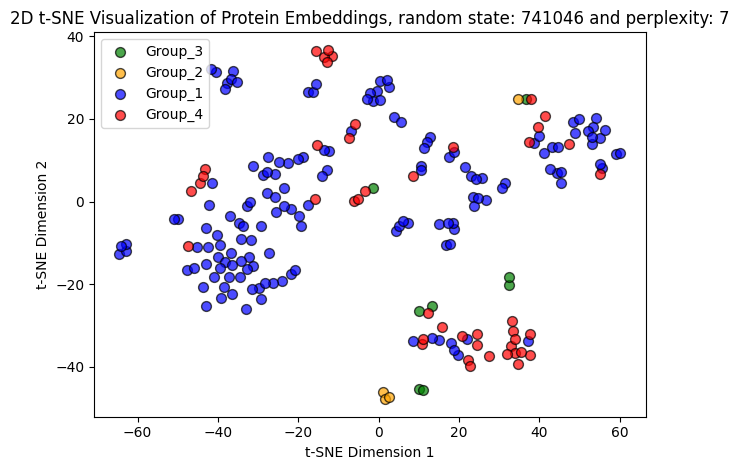

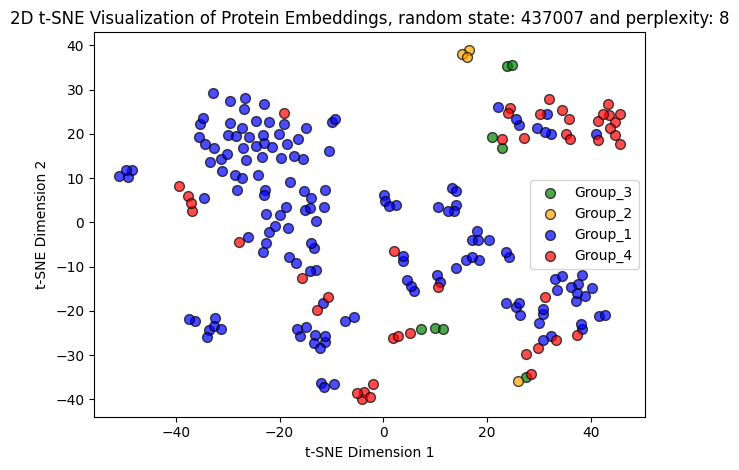

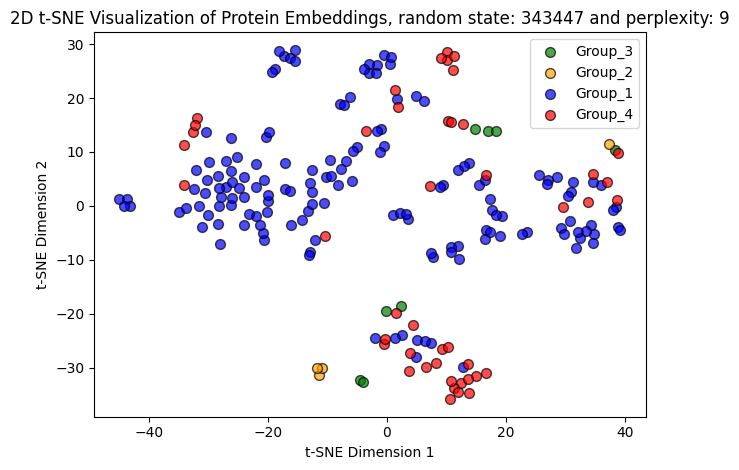

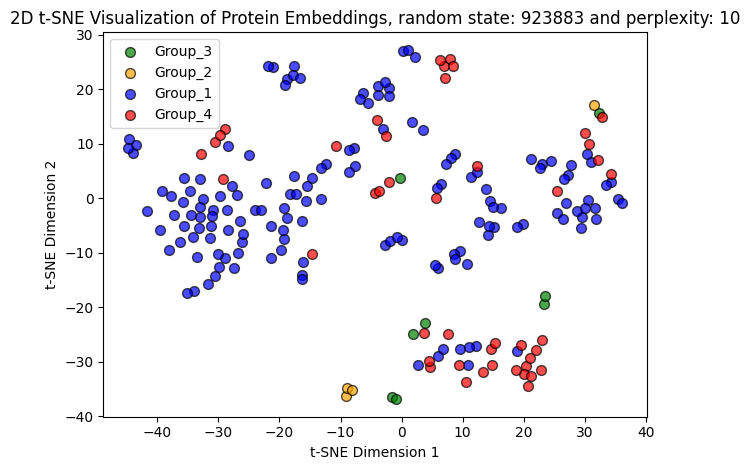

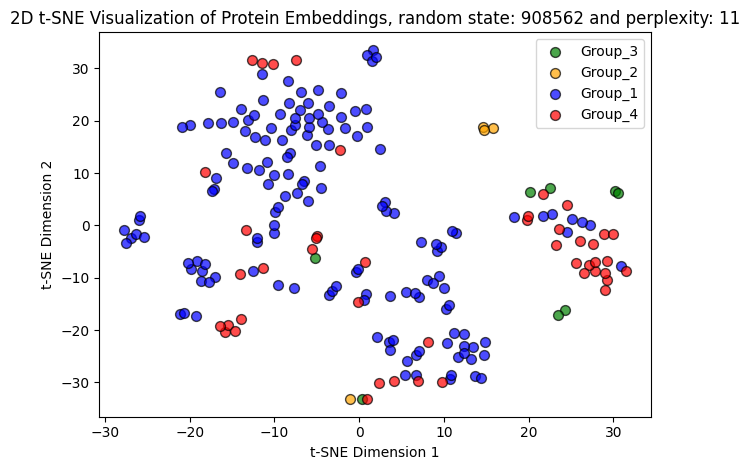

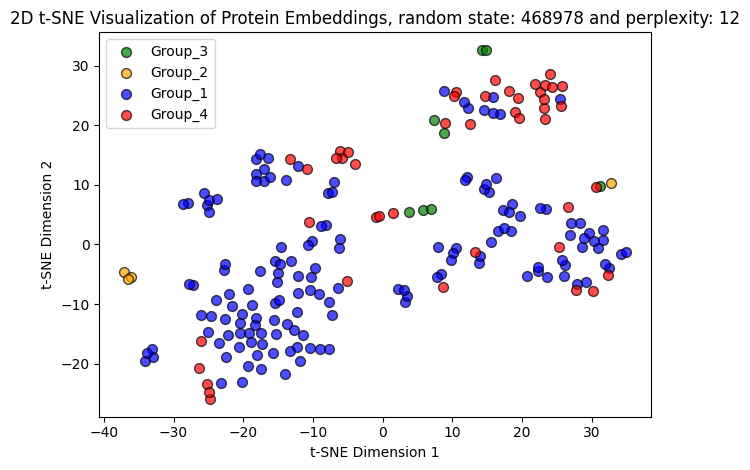

In [40]:
import random

for i in range(12):
    # do the same thing as above but with a different random state
    random_state = random.randint(1000, 1000000)
    protein_ids, embeddings_2d, labels, colors = embedding_tool.calculate_2d_projection_tsne(db = eedb.db, ids_list=ids, ids_list_labels=dict_id_label, perplexity=i+1, n_iter=3000, random_state=random_state)

    # plot
    # make the None objects to 'None' in labels
    labels = ['None' if x is None else x for x in labels]

    # create a scatter plot for each unique label
    unique_labels = set(labels)
    unique_color_labels = {}
    for label in unique_labels:
        indices = [i for i, l in enumerate(labels) if l == label]
        plt.scatter(
            [embeddings_2d[i, 0] for i in indices],
            [embeddings_2d[i, 1] for i in indices],
            c=[colors[indices[0]]],
            label=label,
            alpha=0.7,
            s=50,
            edgecolor="k",
        )
        
        # store the color for the label
        unique_color_labels[label] = colors[indices[0]]


    plt.title(f"2D t-SNE Visualization of Protein Embeddings, random state: {random_state} and perplexity: {i+1}")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.legend()
    plt.tight_layout()
    plt.show()

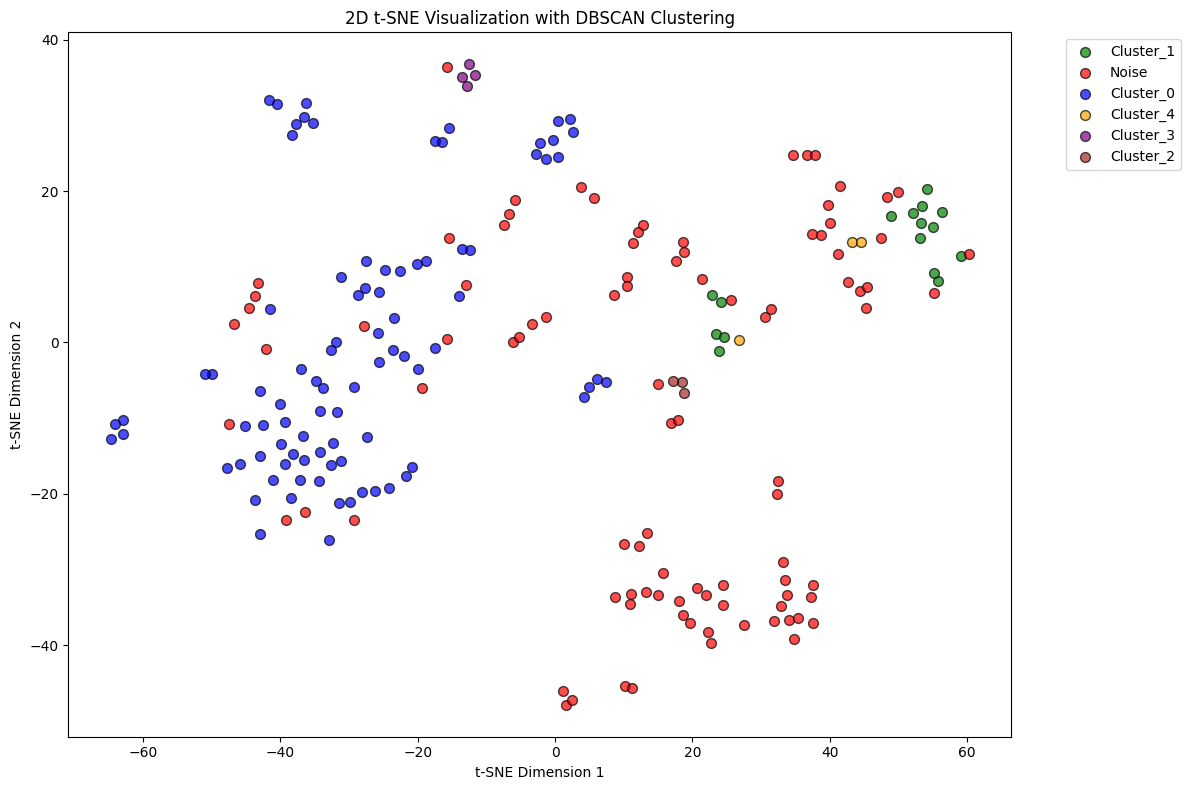


Cluster Statistics:
Noise        95
Cluster_0    88
Cluster_1    16
Cluster_3     4
Cluster_4     3
Cluster_2     3
Name: count, dtype: int64


In [41]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Standardize the distances for better DBSCAN performance
scaler = StandardScaler()
distances_scaled = scaler.fit_transform(distances)

# Apply DBSCAN
dbscan = DBSCAN(eps=1.4, min_samples=3)  # You may need to adjust these parameters
clusters = dbscan.fit_predict(distances_scaled)

# Create a new dictionary mapping protein IDs to cluster labels
dict_id_label = {}
for protein_id, cluster in zip(proteins, clusters):
    dict_id_label[protein_id] = f"Cluster_{cluster}" if cluster != -1 else "Noise"

# Calculate t-SNE projection with the new cluster labels
protein_ids, embeddings_2d, labels, colors = embedding_tool.calculate_2d_projection_tsne(
    db=eedb.db, 
    ids_list=ids, 
    ids_list_labels=dict_id_label, 
    perplexity=7, 
    n_iter=3000, 
    random_state=42
)

# Create the visualization
plt.figure(figsize=(12, 8))

# Convert None to 'None' in labels
labels = ['None' if x is None else x for x in labels]

# Plot each cluster
unique_labels = set(labels)
for label in unique_labels:
    indices = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(
        [embeddings_2d[i, 0] for i in indices],
        [embeddings_2d[i, 1] for i in indices],
        c=[colors[indices[0]]],
        label=label,
        alpha=0.7,
        s=50,
        edgecolor="k",
    )

plt.title("2D t-SNE Visualization with DBSCAN Clustering")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Print cluster statistics
cluster_counts = pd.Series(labels).value_counts()
print("\nCluster Statistics:")
print(cluster_counts)

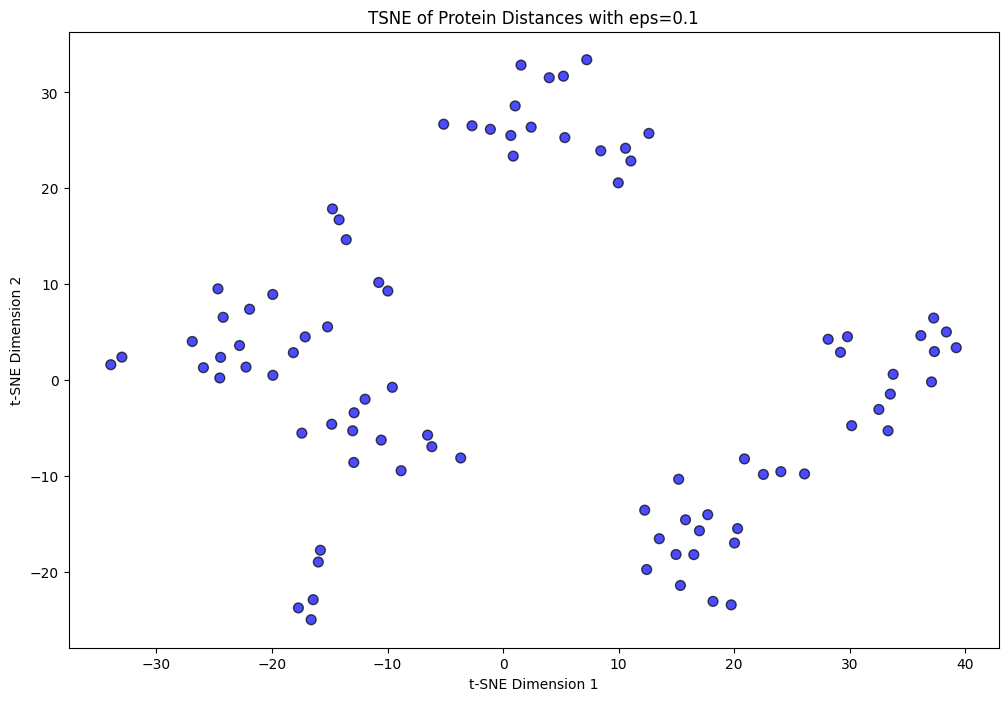

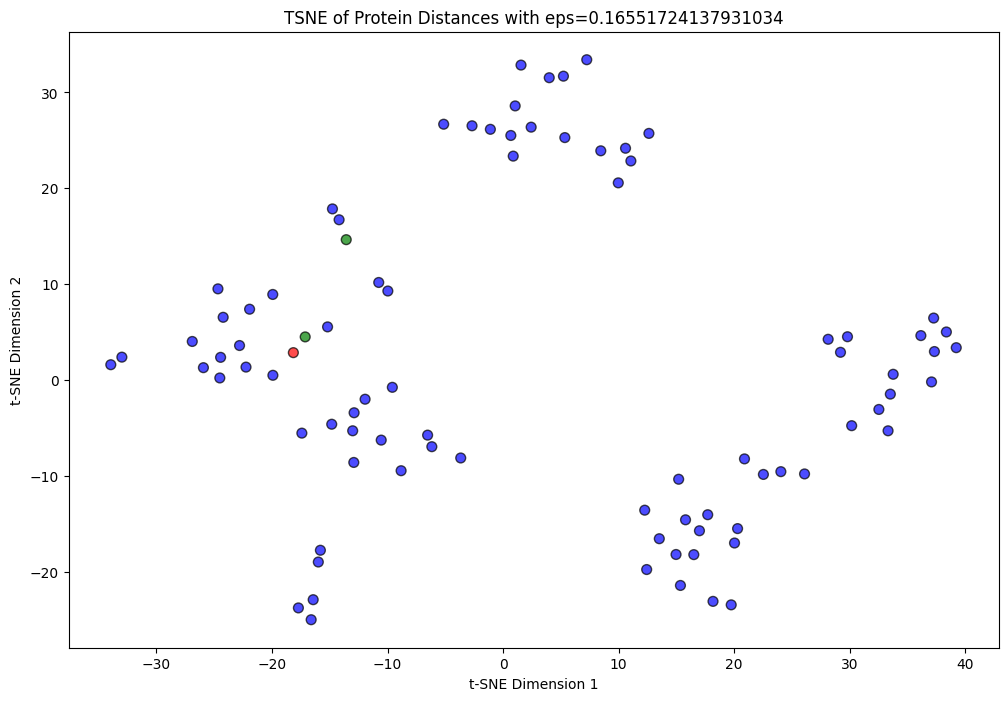

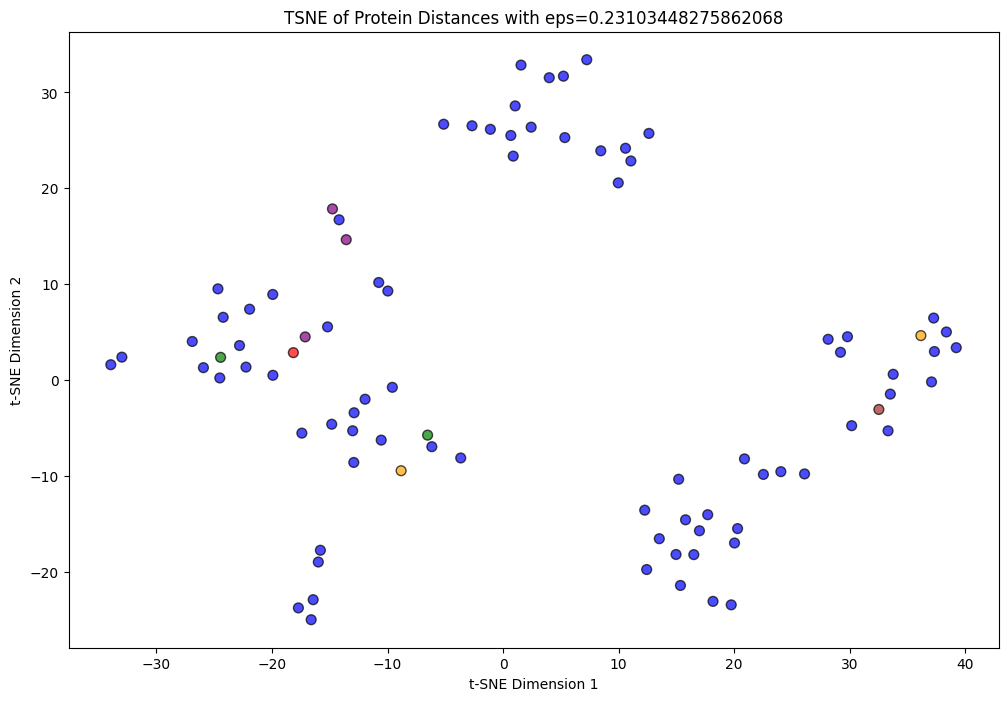

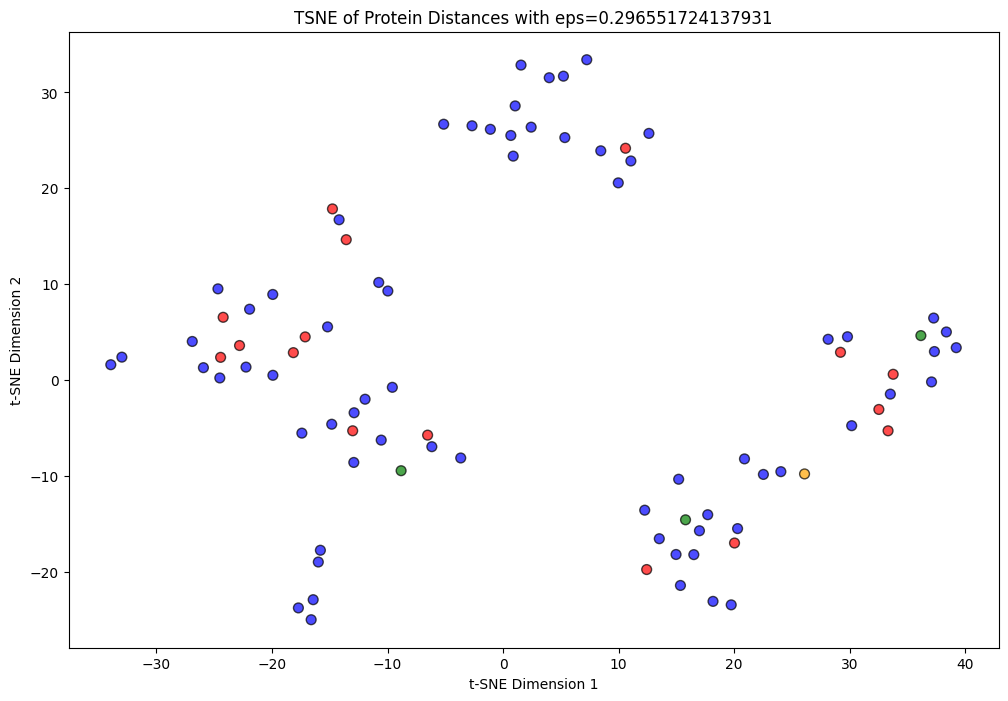

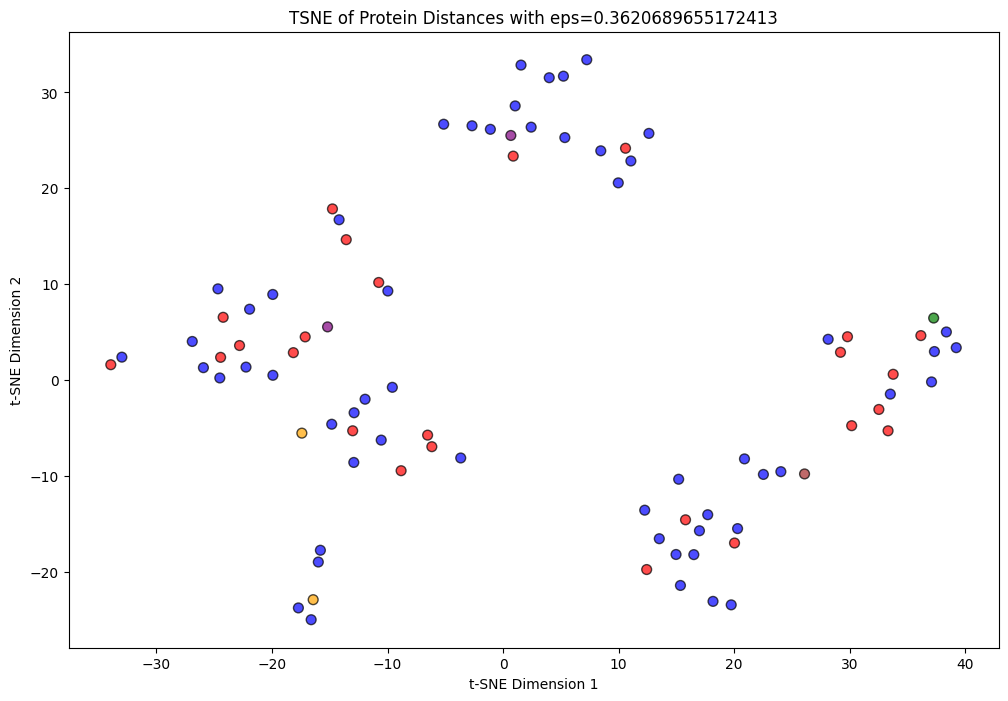

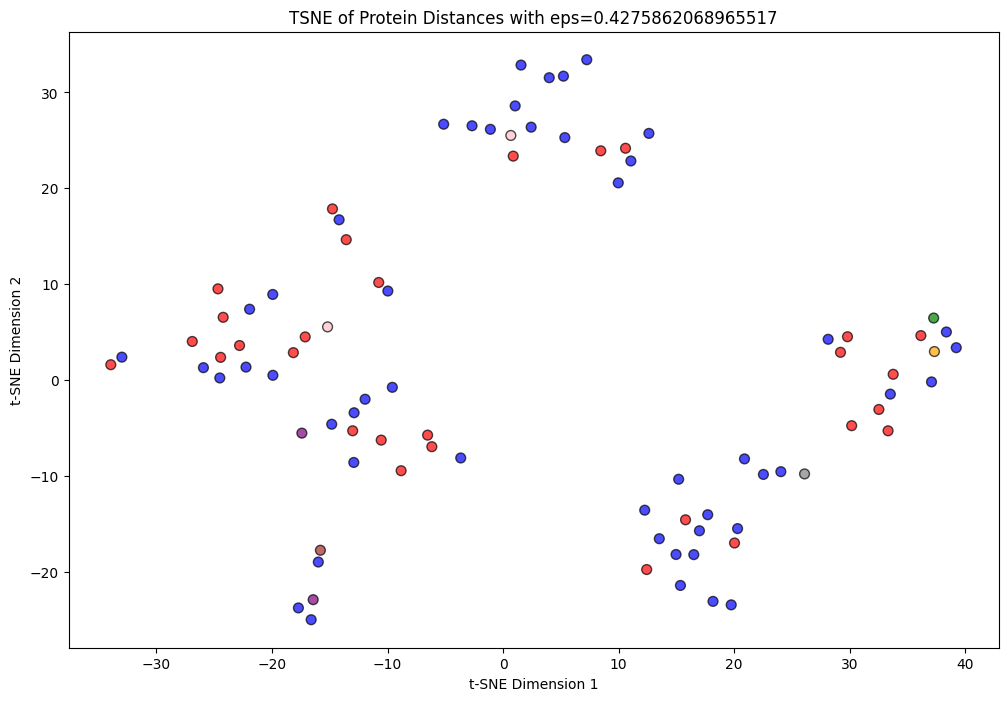

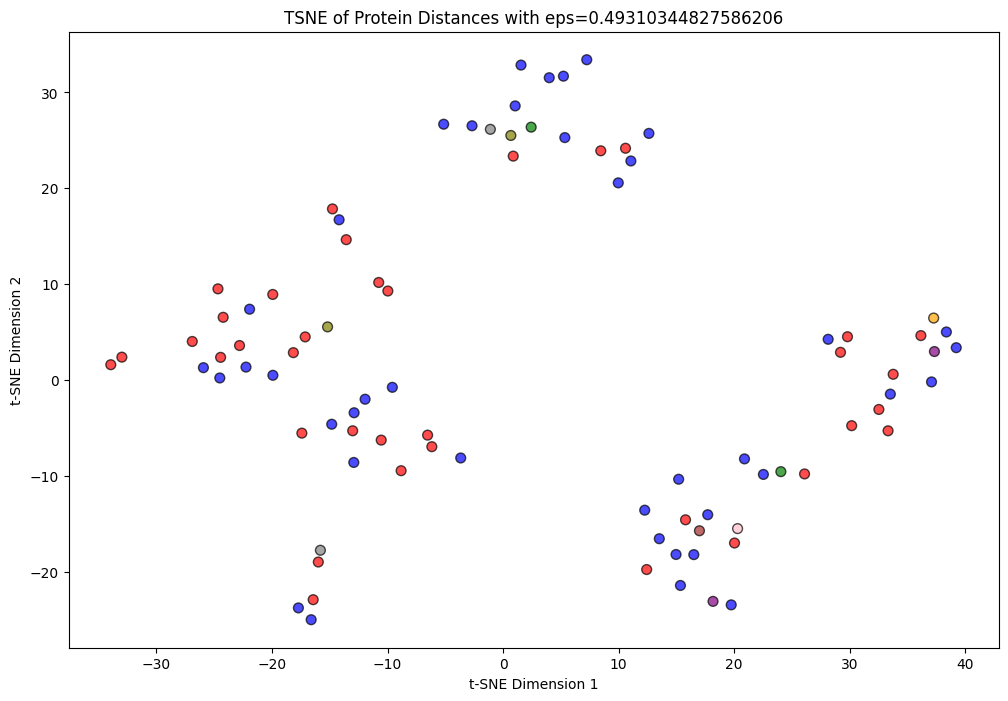

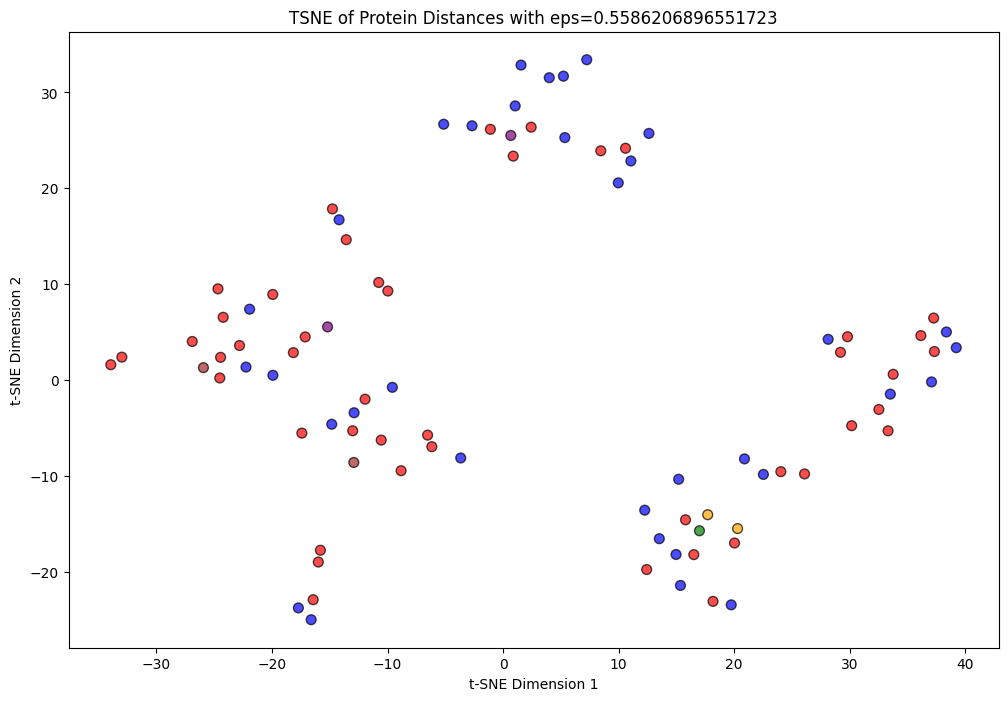

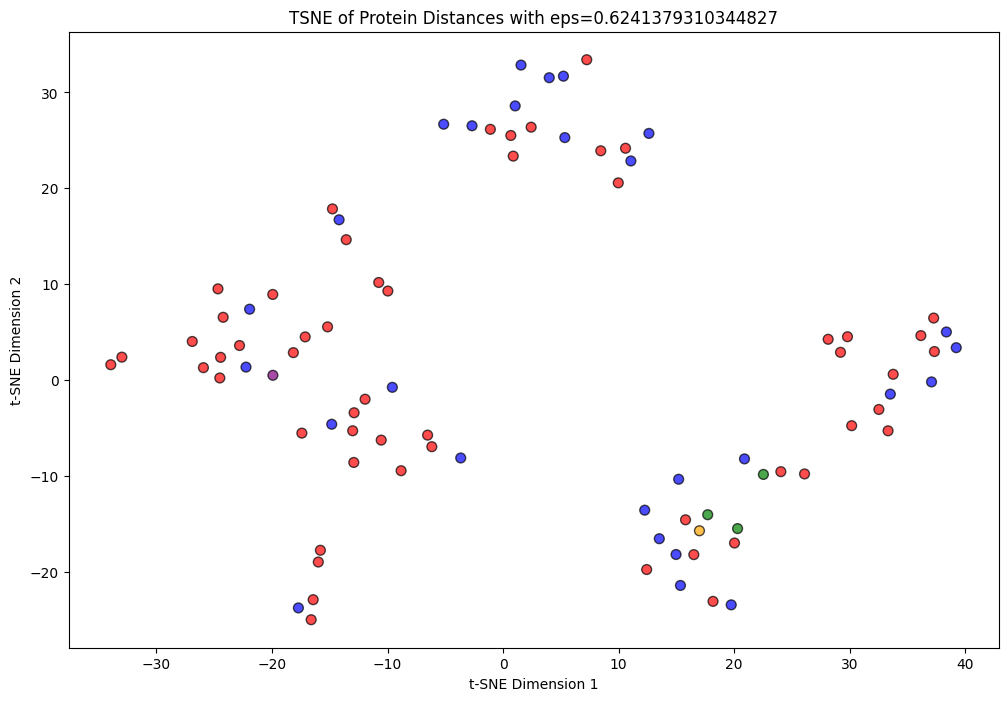

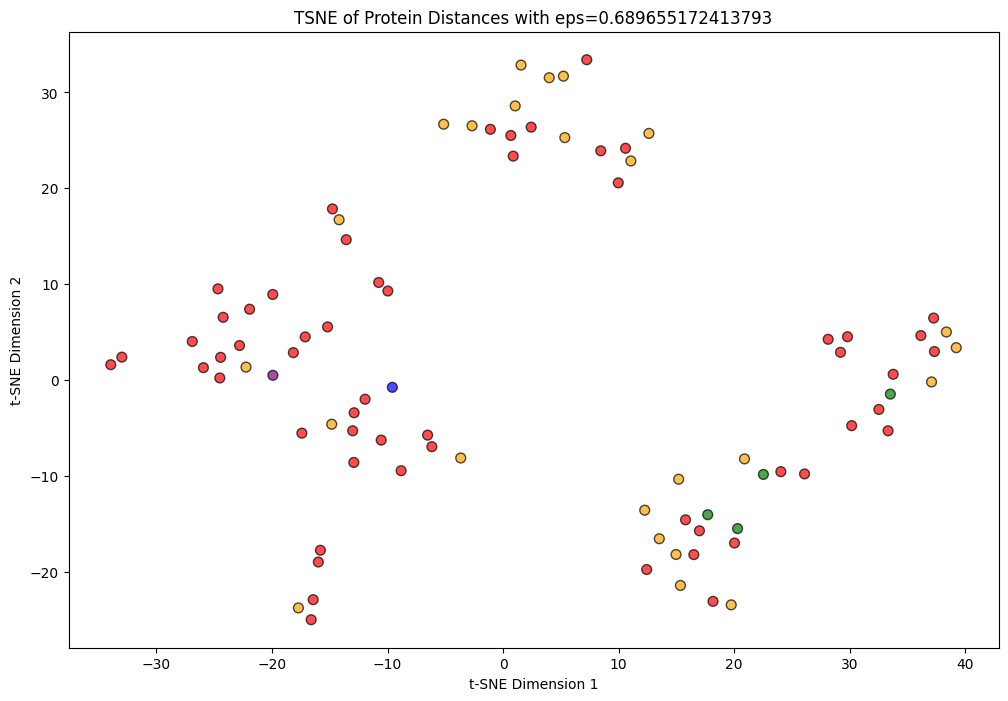

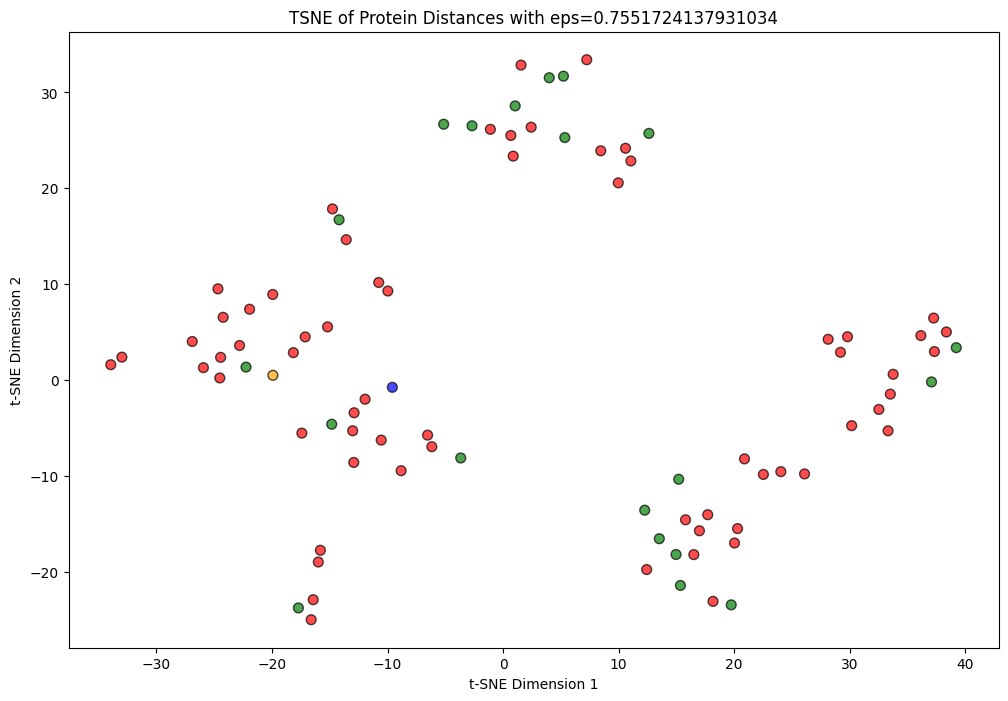

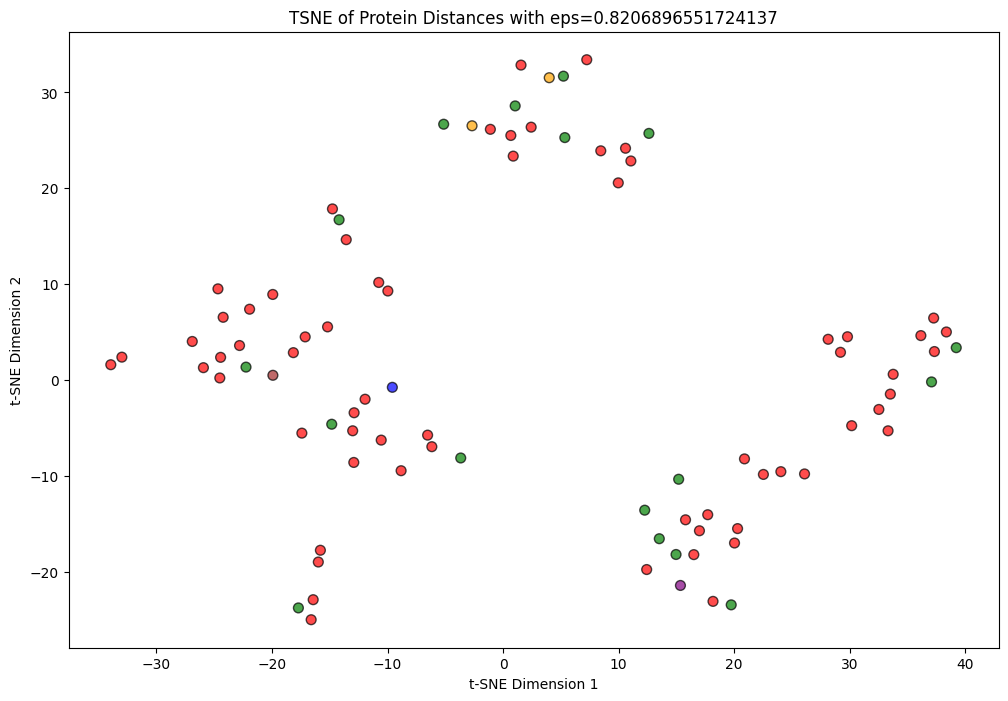

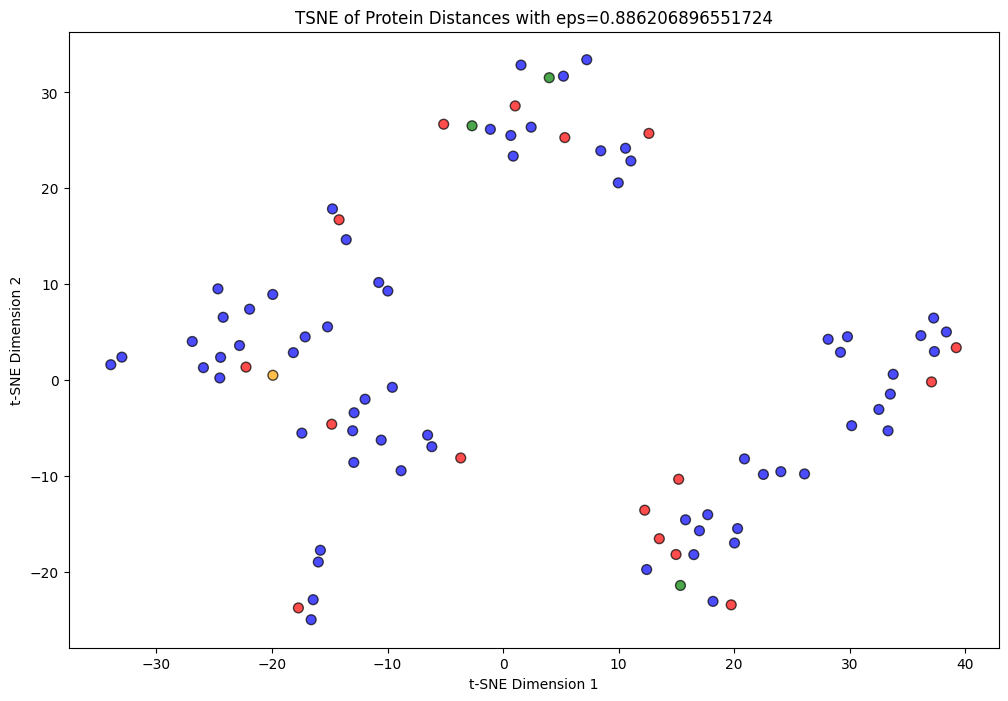

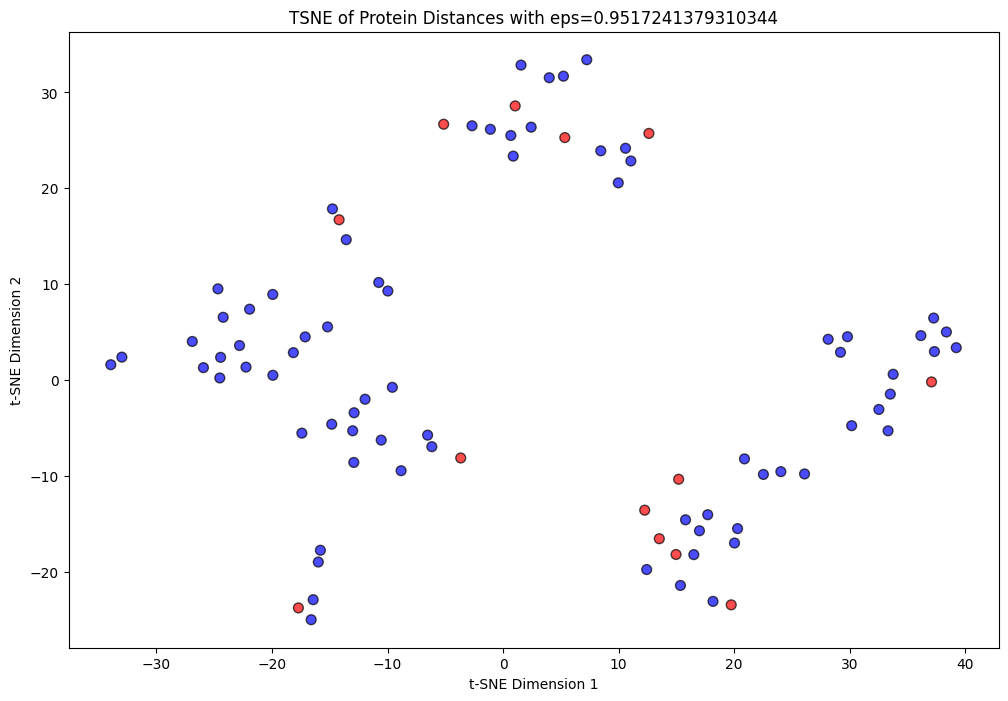

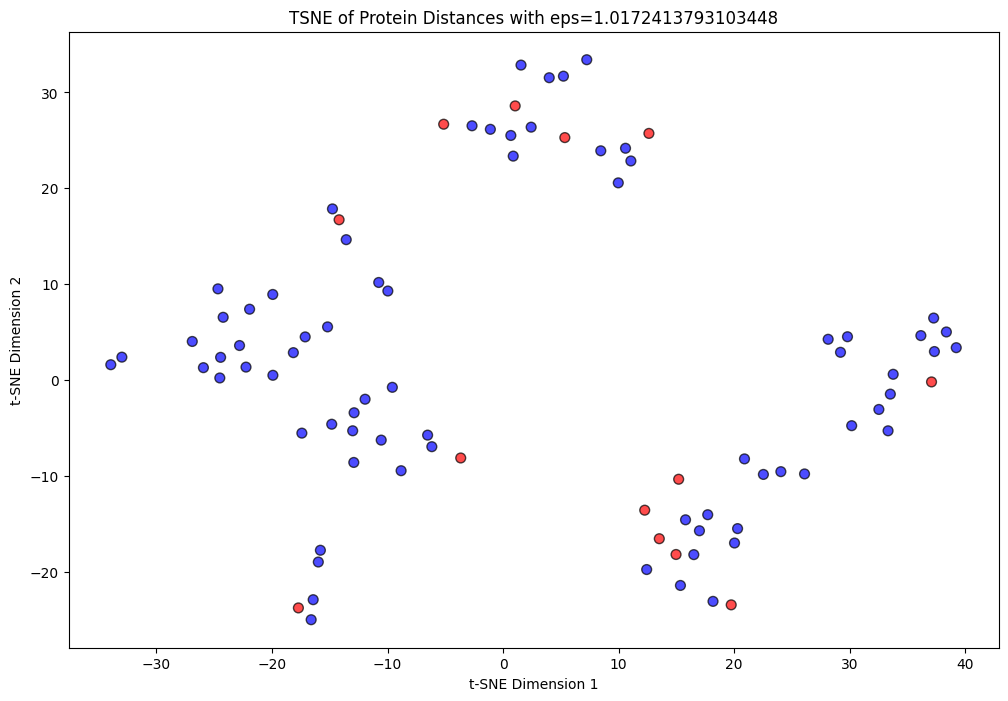

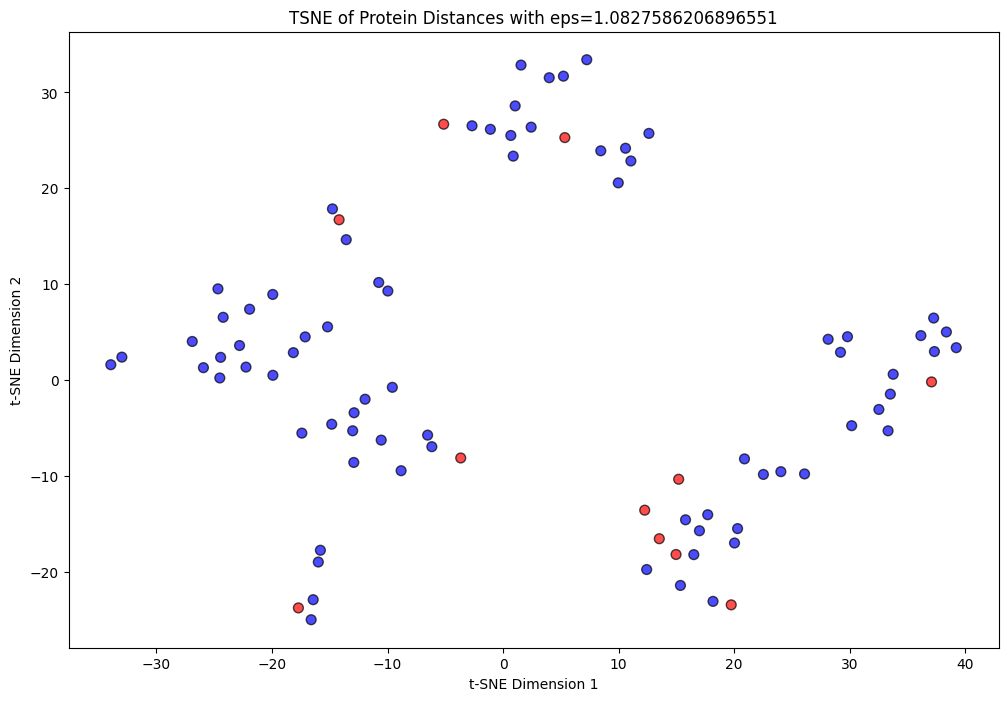

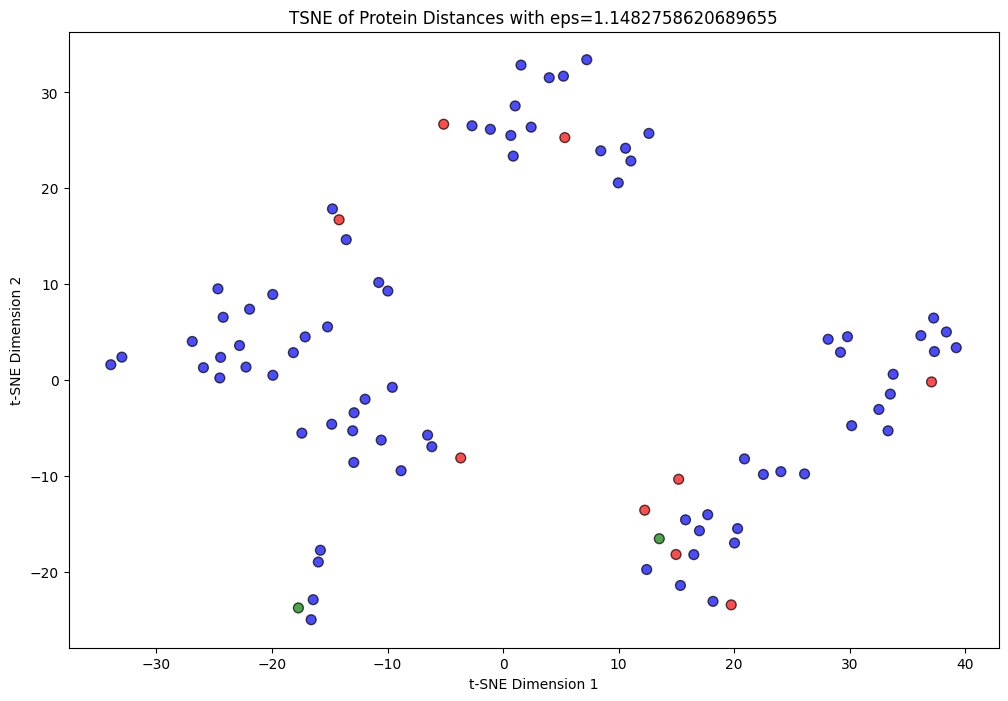

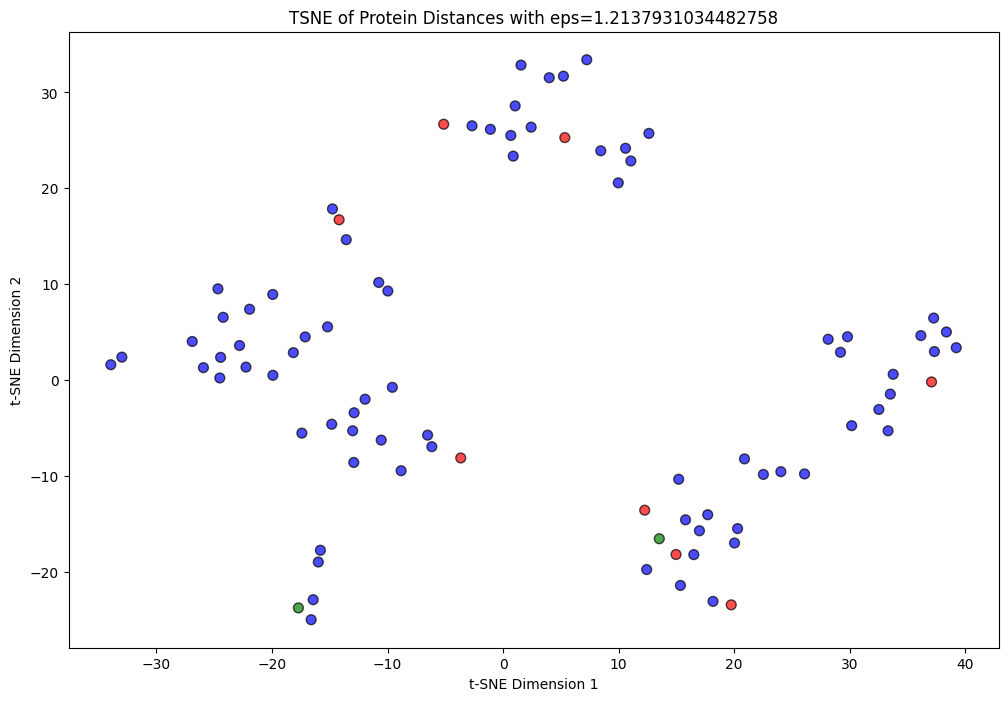

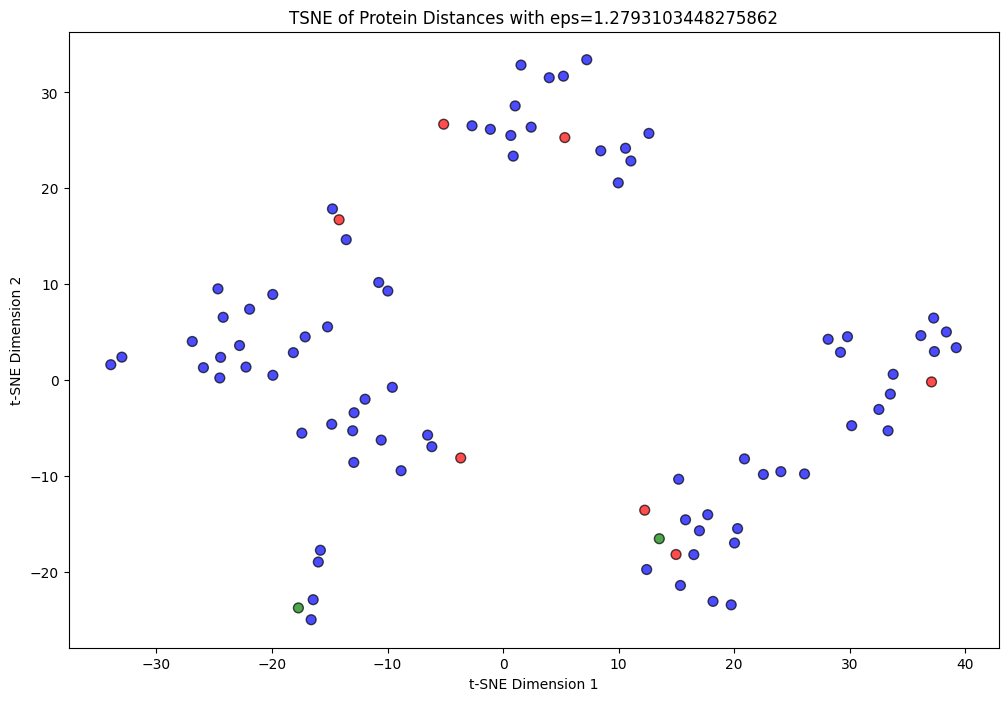

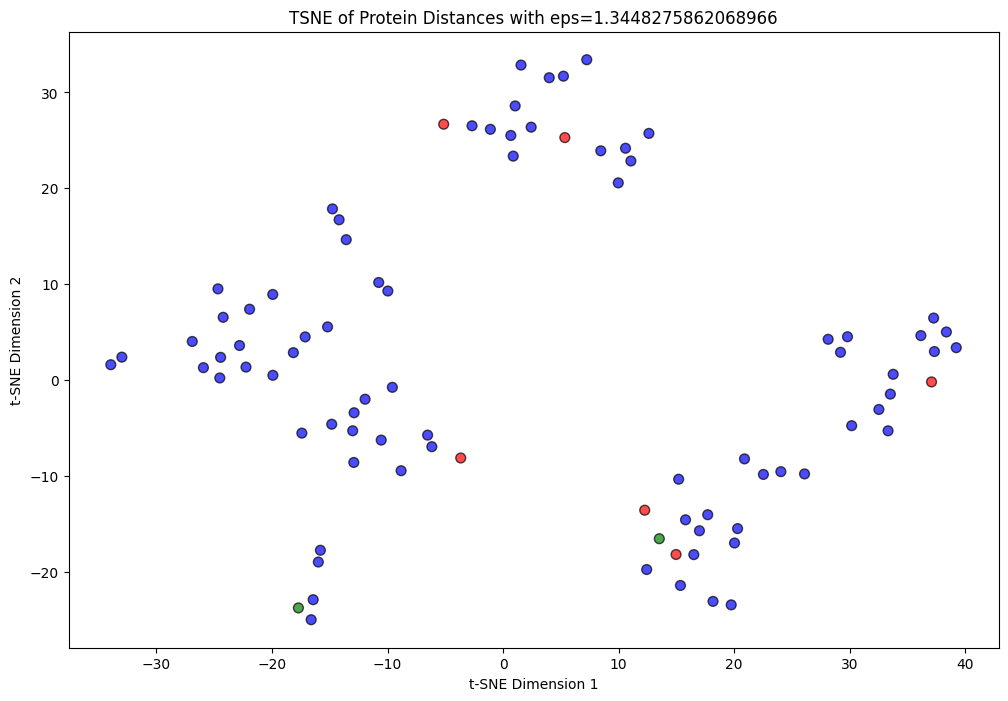

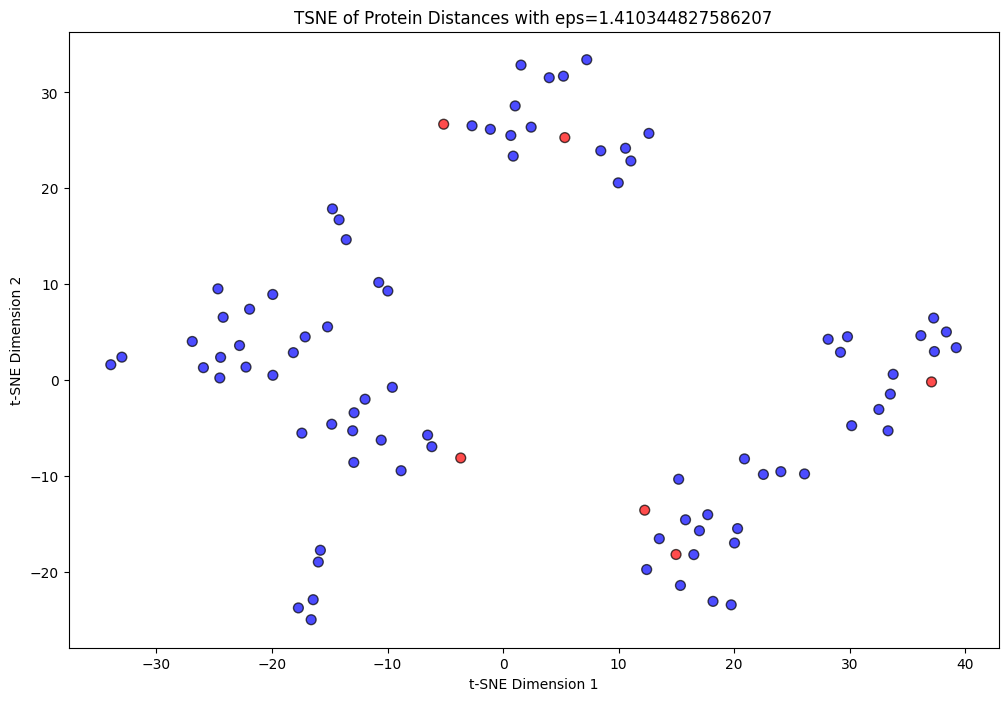

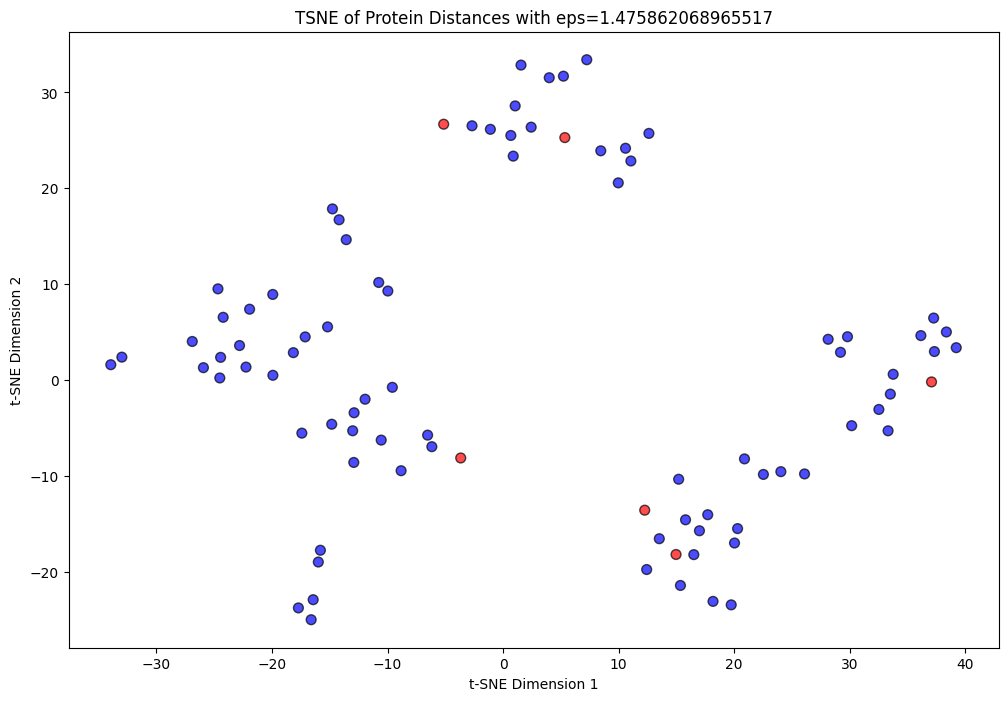

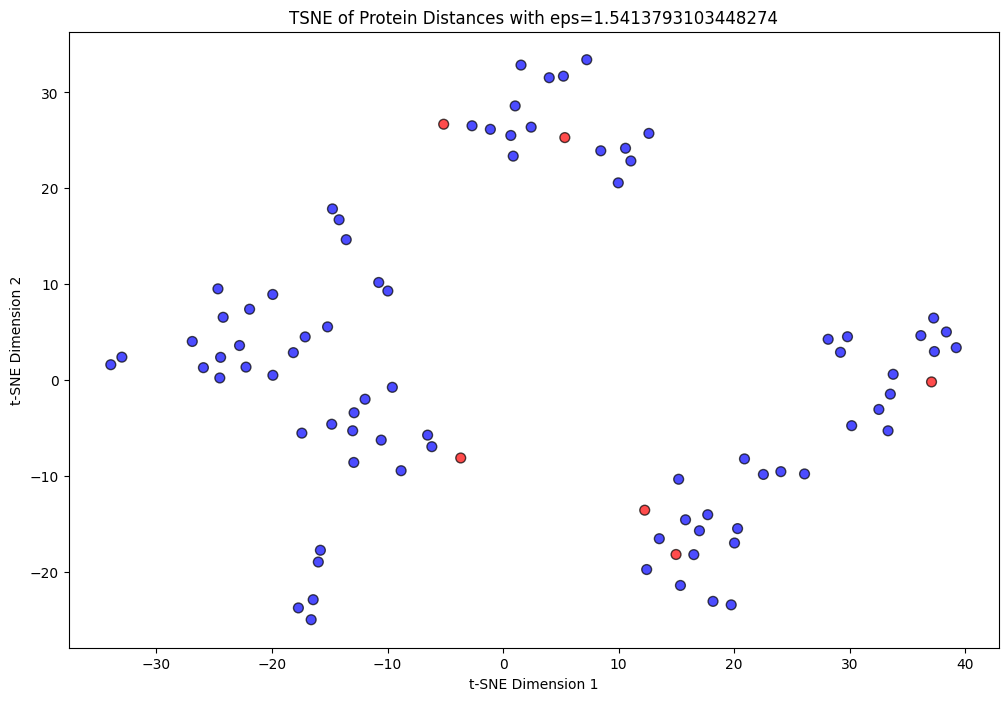

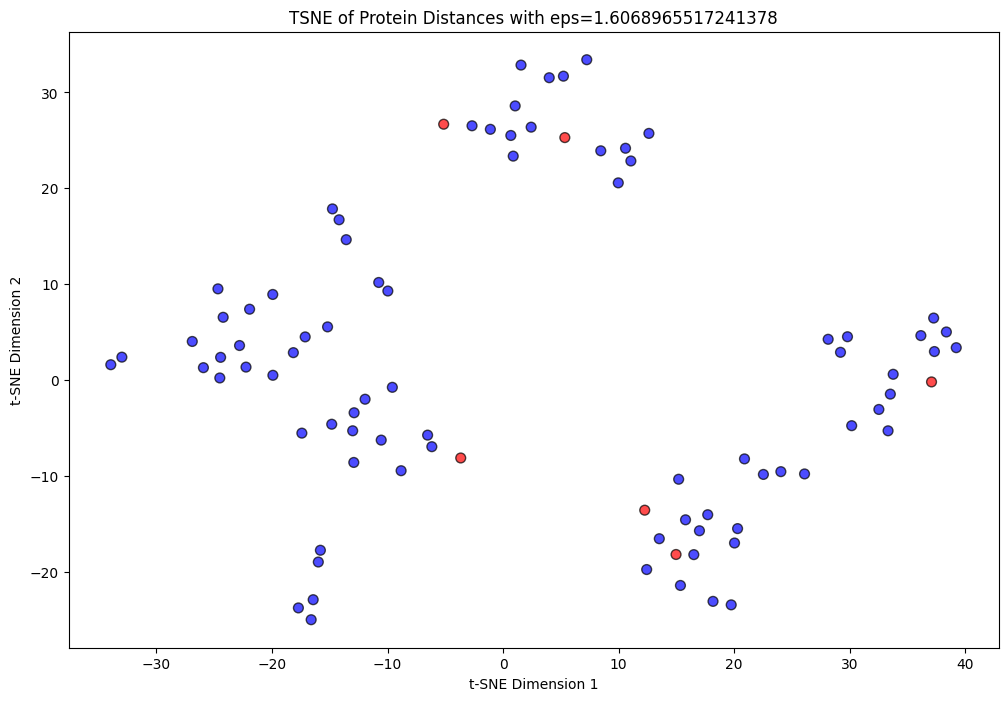

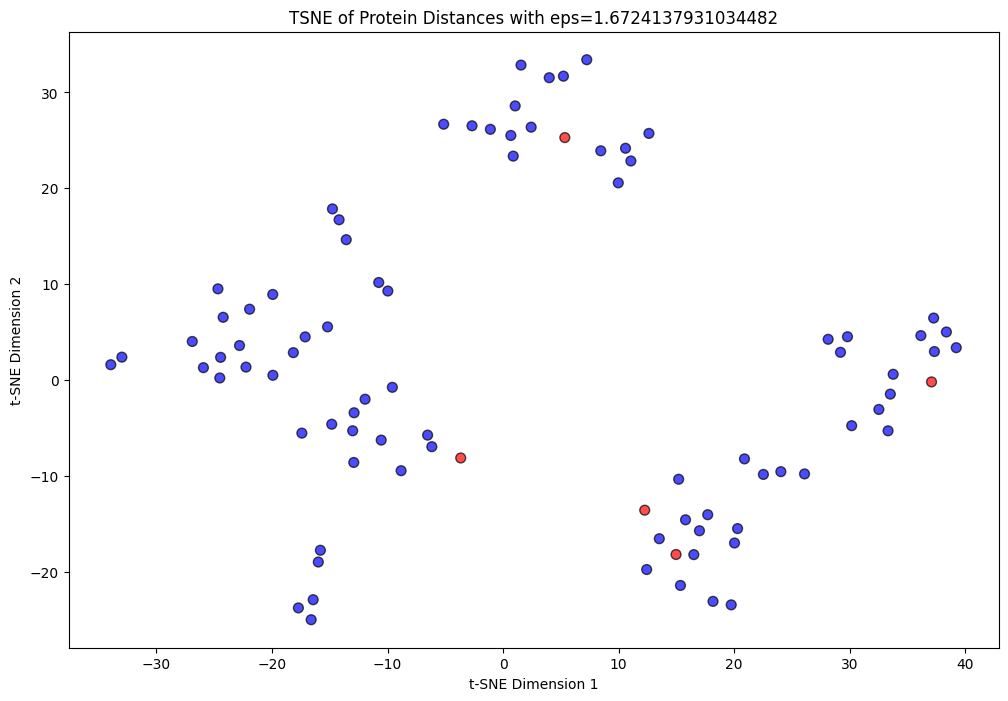

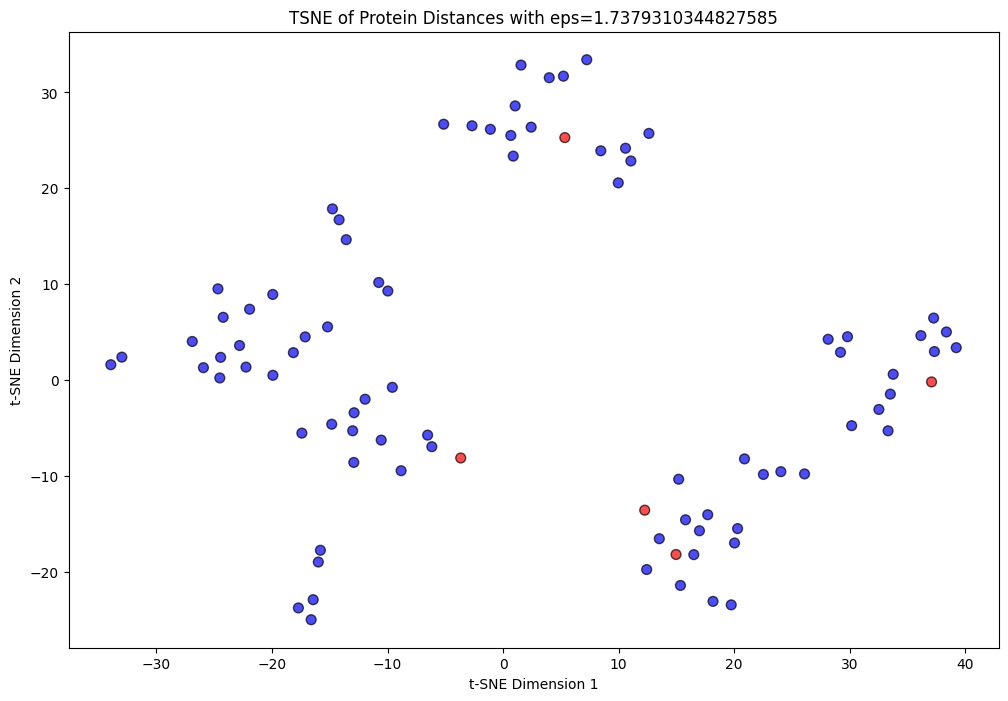

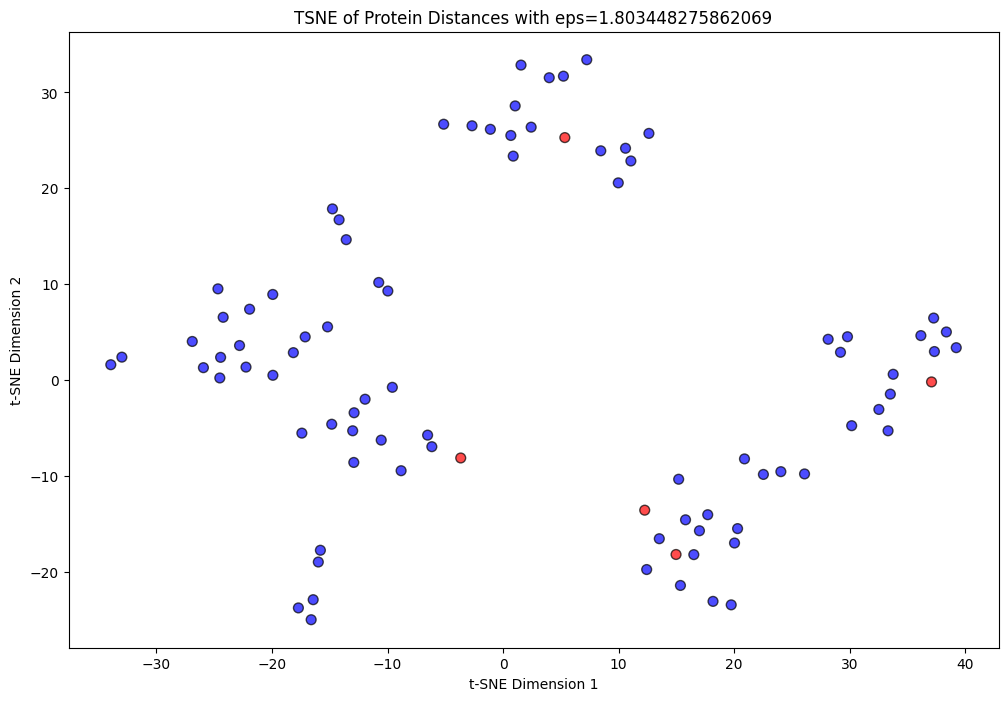

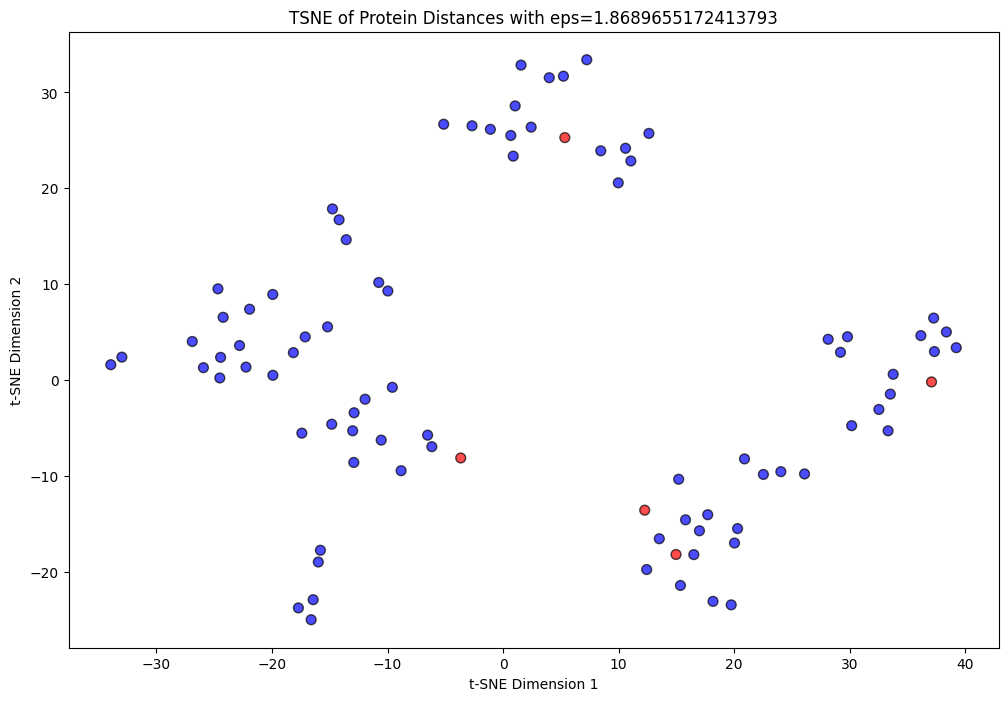

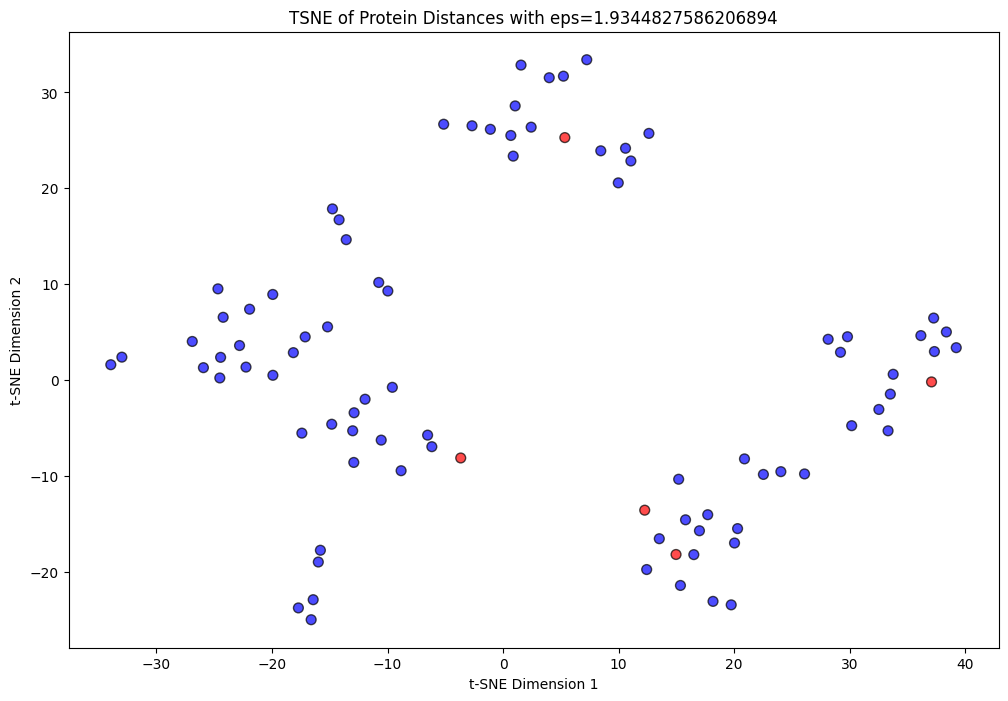

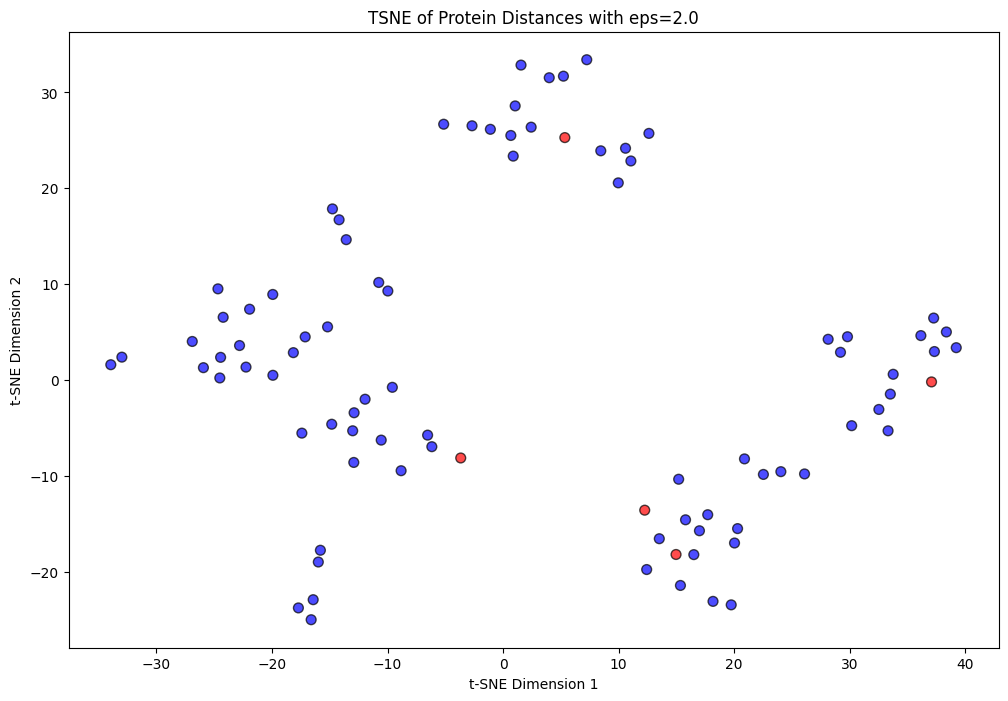

In [112]:
# okay now lets first to a PCA with dimensions reduction and then try a dbscan on the PCA results
# the visualization should be a 2D plot of the TSNE embedding
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

# lets first do the PCA
pca = PCA(n_components=5)
pca_result = pca.fit_transform(distance_matrix_embeddings_cosine)

# scale the PCA result
scaler = StandardScaler()
pca_result_scaled = scaler.fit_transform(pca_result)

for i in np.linspace(0.1, 2, 30):
    # now do the DBSCAN on the PCA results
    dbscan = DBSCAN(eps=i, min_samples=3)
    dbscan_result = dbscan.fit_predict(pca_result_scaled)

    # now plot the DBSCAN result as the colors of the TSNE embedding
    dict_id_label = {}
    for protein_id, cluster in zip(protein_ids, dbscan_result):
        dict_id_label[protein_id] = f"Cluster_{cluster}" if cluster != -1 else "Noise"

    # now plot the TSNE embedding with the DBSCAN result
    protein_ids, embeddings_2d, labels, colors = embedding_tool.calculate_2d_projection_tsne(db = eedb.db, ids_list=ids, ids_list_labels=dict_id_label, perplexity=7, n_iter=3000, random_state=42)

    # now plot the TSNE embedding
    plt.figure(figsize=(12, 8))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors, alpha=0.7, s=50, edgecolor="k")
    plt.title(f"TSNE of Protein Distances with eps={i}")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()


In [43]:
# Get sequences for all proteins
sequences = []
for protein_id in ids:
    # Query the database for the sequence
    query = f"""
    MATCH (p:Protein {{accession_id: $protein_id}})
    RETURN p.sequence as sequence
    """
    result = eedb.db.execute_read(query, {"protein_id": protein_id})
    sequence = result[0]['sequence'] if result else None
    if sequence:
        sequences.append((protein_id, sequence))

# Write to FASTA file
output_path = '/home/nab/Niklas/TEM-lactamase/data/002_combined_data/TEM_proteins.fasta'
with open(output_path, 'w') as f:
    for protein_id, sequence in sequences:
        f.write(f'>{protein_id}\n')
        # Write sequence with line breaks every 60 characters
        for i in range(0, len(sequence), 60):
            f.write(sequence[i:i+60] + '\n')

print(f"Written {len(sequences)} sequences to {output_path}")

Written 209 sequences to /home/nab/Niklas/TEM-lactamase/data/002_combined_data/TEM_proteins.fasta


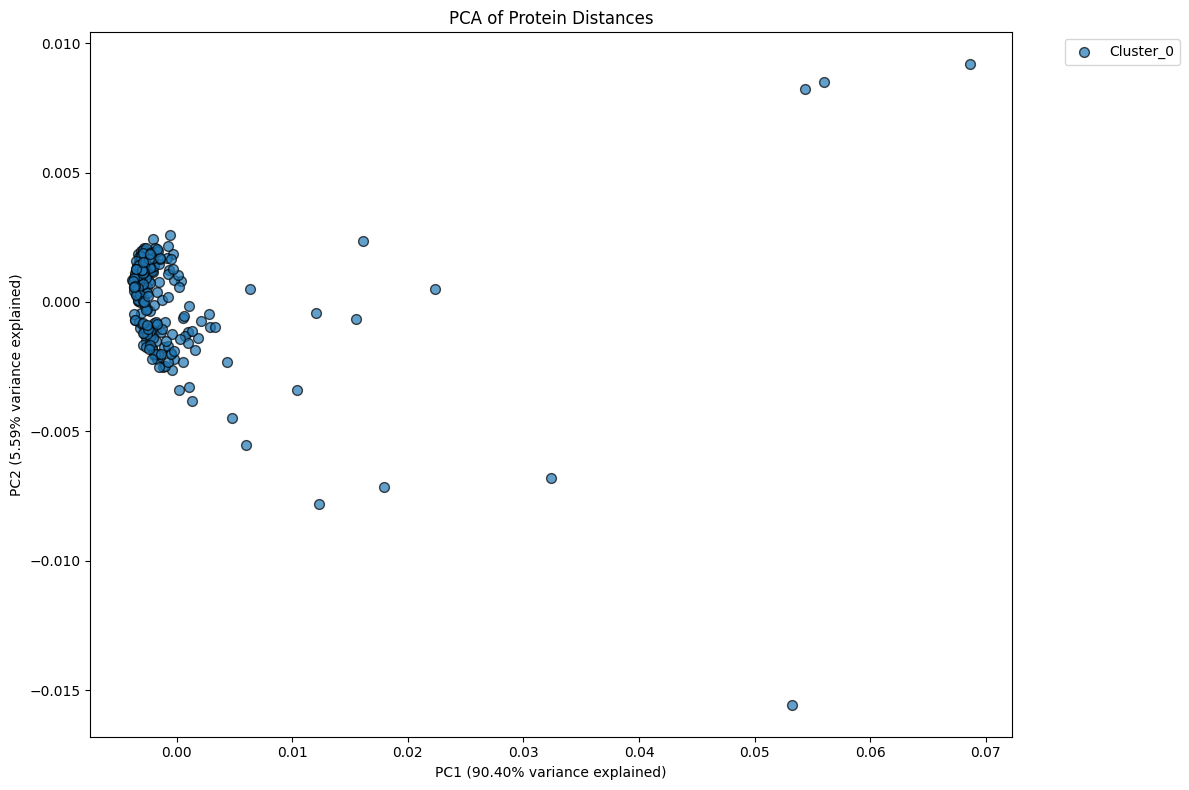


Explained variance ratio:
PC1: 90.40%
PC2: 5.59%
Total: 95.98%


In [44]:
from sklearn.decomposition import PCA

# Create PCA object
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization

# Fit and transform the distance matrix
# Using the cosine distance matrix, but you could also use euclidean or mutations
pca_result = pca.fit_transform(distance_matrix_embeddings_cosine)

# Create the visualization
plt.figure(figsize=(12, 8))

# Create scatter plot
for label in set(labels):
    mask = np.array(labels) == label
    plt.scatter(
        pca_result[mask, 0],
        pca_result[mask, 1],
        label=label,
        alpha=0.7,
        s=50,
        edgecolor="k"
    )

plt.title("PCA of Protein Distances")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2%} variance explained)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2%} variance explained)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Print explained variance ratio
print("\nExplained variance ratio:")
print(f"PC1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"PC2: {pca.explained_variance_ratio_[1]:.2%}")
print(f"Total: {sum(pca.explained_variance_ratio_[:2]):.2%}")

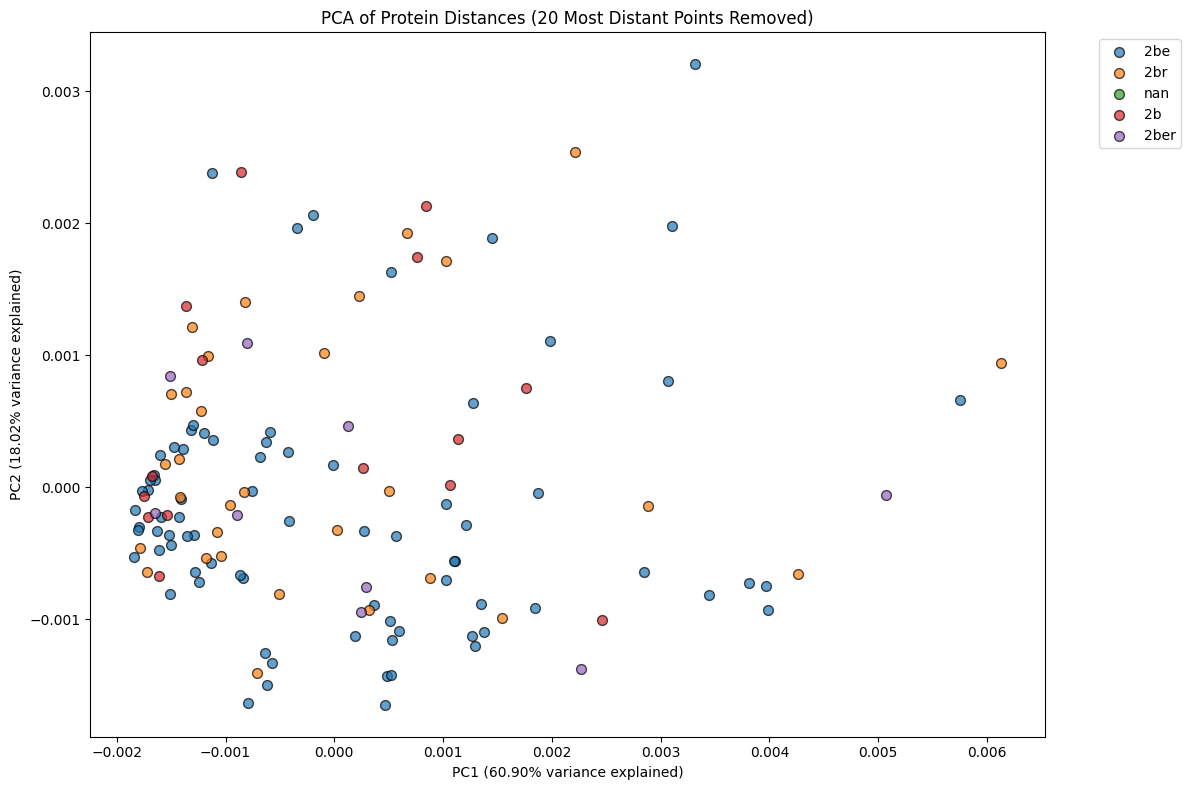


Explained variance ratio (after removing 20 most distant points):
PC1: 60.90%
PC2: 18.02%
Total: 78.92%


In [45]:
# can you remove the 20 most far away proteins from the PCA plot and then do it again
# Calculate distances from origin for each point
distances_from_origin = np.sqrt(pca_result[:,0]**2 + pca_result[:,1]**2)

# Get indices of points sorted by distance (excluding the 20 farthest)
n_to_remove = 20
kept_indices = np.argsort(distances_from_origin)[:-n_to_remove]

# Filter the data
filtered_distance_matrix = distance_matrix_embeddings_cosine[kept_indices][:,kept_indices]
filtered_phenotypes = np.array(df['phenotype'])[kept_indices]

# Perform PCA on filtered data
pca_filtered = PCA(n_components=2)
pca_filtered_result = pca_filtered.fit_transform(filtered_distance_matrix)

# Create visualization
plt.figure(figsize=(12, 8))

# Create scatter plot
for label in set(filtered_phenotypes):
    mask = filtered_phenotypes == label
    plt.scatter(
        pca_filtered_result[mask, 0],
        pca_filtered_result[mask, 1],
        label=label,
        alpha=0.7,
        s=50,
        edgecolor="k"
    )

plt.title("PCA of Protein Distances (20 Most Distant Points Removed)")
plt.xlabel(f"PC1 ({pca_filtered.explained_variance_ratio_[0]:.2%} variance explained)")
plt.ylabel(f"PC2 ({pca_filtered.explained_variance_ratio_[1]:.2%} variance explained)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Print explained variance ratio
print("\nExplained variance ratio (after removing 20 most distant points):")
print(f"PC1: {pca_filtered.explained_variance_ratio_[0]:.2%}")
print(f"PC2: {pca_filtered.explained_variance_ratio_[1]:.2%}")
print(f"Total: {sum(pca_filtered.explained_variance_ratio_[:2]):.2%}")


# Alinas Proteins

In [51]:
ids = ["2FX5_A", "AAA33335.1", "ACC95208.1", "ACY95991.1", "ACY96861.1", "ADH43200.1", "ADK73612.1", "ADM47605.1", "ADV92525.1", "ADV92526.1", "ADV92528.1", "ADV92571.1", "AET05798.1", "AET05799.1", "AFA45122.1", "AKJ29164.1", "AKZ20828.1", "ANP21910.1", "APJ12152.1", "ASA57064.1", "BAB86909.1", "BAI99230.2", "BAK48590.1", "BAO42836.1", "CBY05530.1", "CEE00769.1", "DAC80635.1", "EGD44994.1", "ESK97883.1", "G9BY57.1", "GBD22443.1", "KAH7127633.1", "MBQ0729274.1", "MEC8523093.1", "ODU60407.1", "OGB27210.1", "P19833.1", "Q47RJ6.1", "Q47RJ7.1", "QEX94755.1", "RGD93181.1", "RLI42440.1", "RLT92980.1", "RLU00646.1", "SAY37579.1", "SAY37582.1", "SAY37583.1", "SAY37584.1", "SAY37587.1", "SAY37589.1", "SHM40309.1", "SUD16364.1", "UNZ22463.1", "UNZ81746.1", "UNZ81747.1", "UNZ81748.1", "WAU86704.1", "WID88783.1", "WOR09923.1", "WP_003460012.1", "WP_010659881.1", "WP_013858543.1", "WP_034767800.1", "WP_036989706.1", "WP_039353427.1", "WP_041846030.1", "WP_041847557.1", "WP_044499735.1", "WP_054022242.1", "WP_062195544.1", "WP_078759821.1", "WP_082414832.1", "WP_083947829.1", "WP_085690612.1", "WP_085749238.1", "WP_088276085.1", "WP_090538641.1", "WP_093412886.1", "WP_101893509.1", "WP_104613137.1", "WP_107095481.1", "WP_108898452.1", "WP_108898647.1", "WP_111881932.1", "WP_117215036.1", "WP_118011433.1", "XDS72785.1"]

In [54]:
# download all theses sequences from the database in niklas playground
# calulate the embeddings for all of them
# generate the distance matric for cosine

# get the password from the .env file
password = os.getenv("NEO4J_NIKLAS_PLAYGROUND")
if password is None:
    raise ValueError("KEY is not set in the .env file.")

uri = "bolt://127.0.0.1:7687"
user = "neo4j"

eedb = Pyeed(uri, user=user, password=password)
# eedb.db.wipe_database(date = '2025-01-17')

eedb.fetch_from_primary_db(ids = ids, db = 'ncbi_protein')
eedb.calculate_sequence_embeddings()


Pyeed Graph Object Mapping constraints not defined. Use _install_labels() to set up model constraints.
📡 Connected to database.


2025-01-17 10:55:21.204 | INFO     | pyeed.main:fetch_from_primary_db:87 - Found 0 sequences in the database.
2025-01-17 10:55:21.205 | INFO     | pyeed.main:fetch_from_primary_db:89 - Fetching 87 sequences from ncbi_protein.


All data has been wiped from the database.


2025-01-17 10:55:21.300 | INFO     | pyeed.adapter.primary_db_adapter:make_request:157 - Making requests with ids list: ['2FX5_A,AAA33335.1,ACC95208.1,ACY95991.1,ACY96861.1,ADH43200.1,ADK73612.1,ADM47605.1,ADV92525.1,ADV92526.1', 'ADV92528.1,ADV92571.1,AET05798.1,AET05799.1,AFA45122.1,AKJ29164.1,AKZ20828.1,ANP21910.1,APJ12152.1,ASA57064.1', 'BAB86909.1,BAI99230.2,BAK48590.1,BAO42836.1,CBY05530.1,CEE00769.1,DAC80635.1,EGD44994.1,ESK97883.1,G9BY57.1', 'GBD22443.1,KAH7127633.1,MBQ0729274.1,MEC8523093.1,ODU60407.1,OGB27210.1,P19833.1,Q47RJ6.1,Q47RJ7.1,QEX94755.1', 'RGD93181.1,RLI42440.1,RLT92980.1,RLU00646.1,SAY37579.1,SAY37582.1,SAY37583.1,SAY37584.1,SAY37587.1,SAY37589.1', 'SHM40309.1,SUD16364.1,UNZ22463.1,UNZ81746.1,UNZ81747.1,UNZ81748.1,WAU86704.1,WID88783.1,WOR09923.1,WP_003460012.1', 'WP_010659881.1,WP_013858543.1,WP_034767800.1,WP_036989706.1,WP_039353427.1,WP_041846030.1,WP_041847557.1,WP_044499735.1,WP_054022242.1,WP_062195544.1', 'WP_078759821.1,WP_082414832.1,WP_083947829.1,WP_0

In [95]:
query_embedding = """
MATCH (p:Protein)
WHERE p.accession_id IN $ids
RETURN p.accession_id AS protein, p.embedding AS embedding
"""
results_embedding = eedb.db.execute_read(query_embedding, {"ids": ids})

# create a distance matrix based on the embeddings
# the metric used will be cosine similarity
# result is a numpy array and there is a list of the protein ids which are the same as the order of the distance matrix
distance_matrix_embedding = np.zeros((len(ids), len(ids)))
protein_ids_embedding = []

# use pdist to calculate the cosine similarity
# use squareform to get the distance matrix
embeddings = [record["embedding"] for record in results_embedding]
distance_matrix_embedding_cosine_alina = squareform(pdist(embeddings, metric="cosine"))
distance_matrix_embedding_euclidean = squareform(pdist(embeddings, metric="euclidean"))
protein_ids_embedding = [record["protein"] for record in results_embedding]

In [96]:
print(len(protein_ids_embedding))
print(distance_matrix_embedding_cosine_alina.shape)


87
(87, 87)


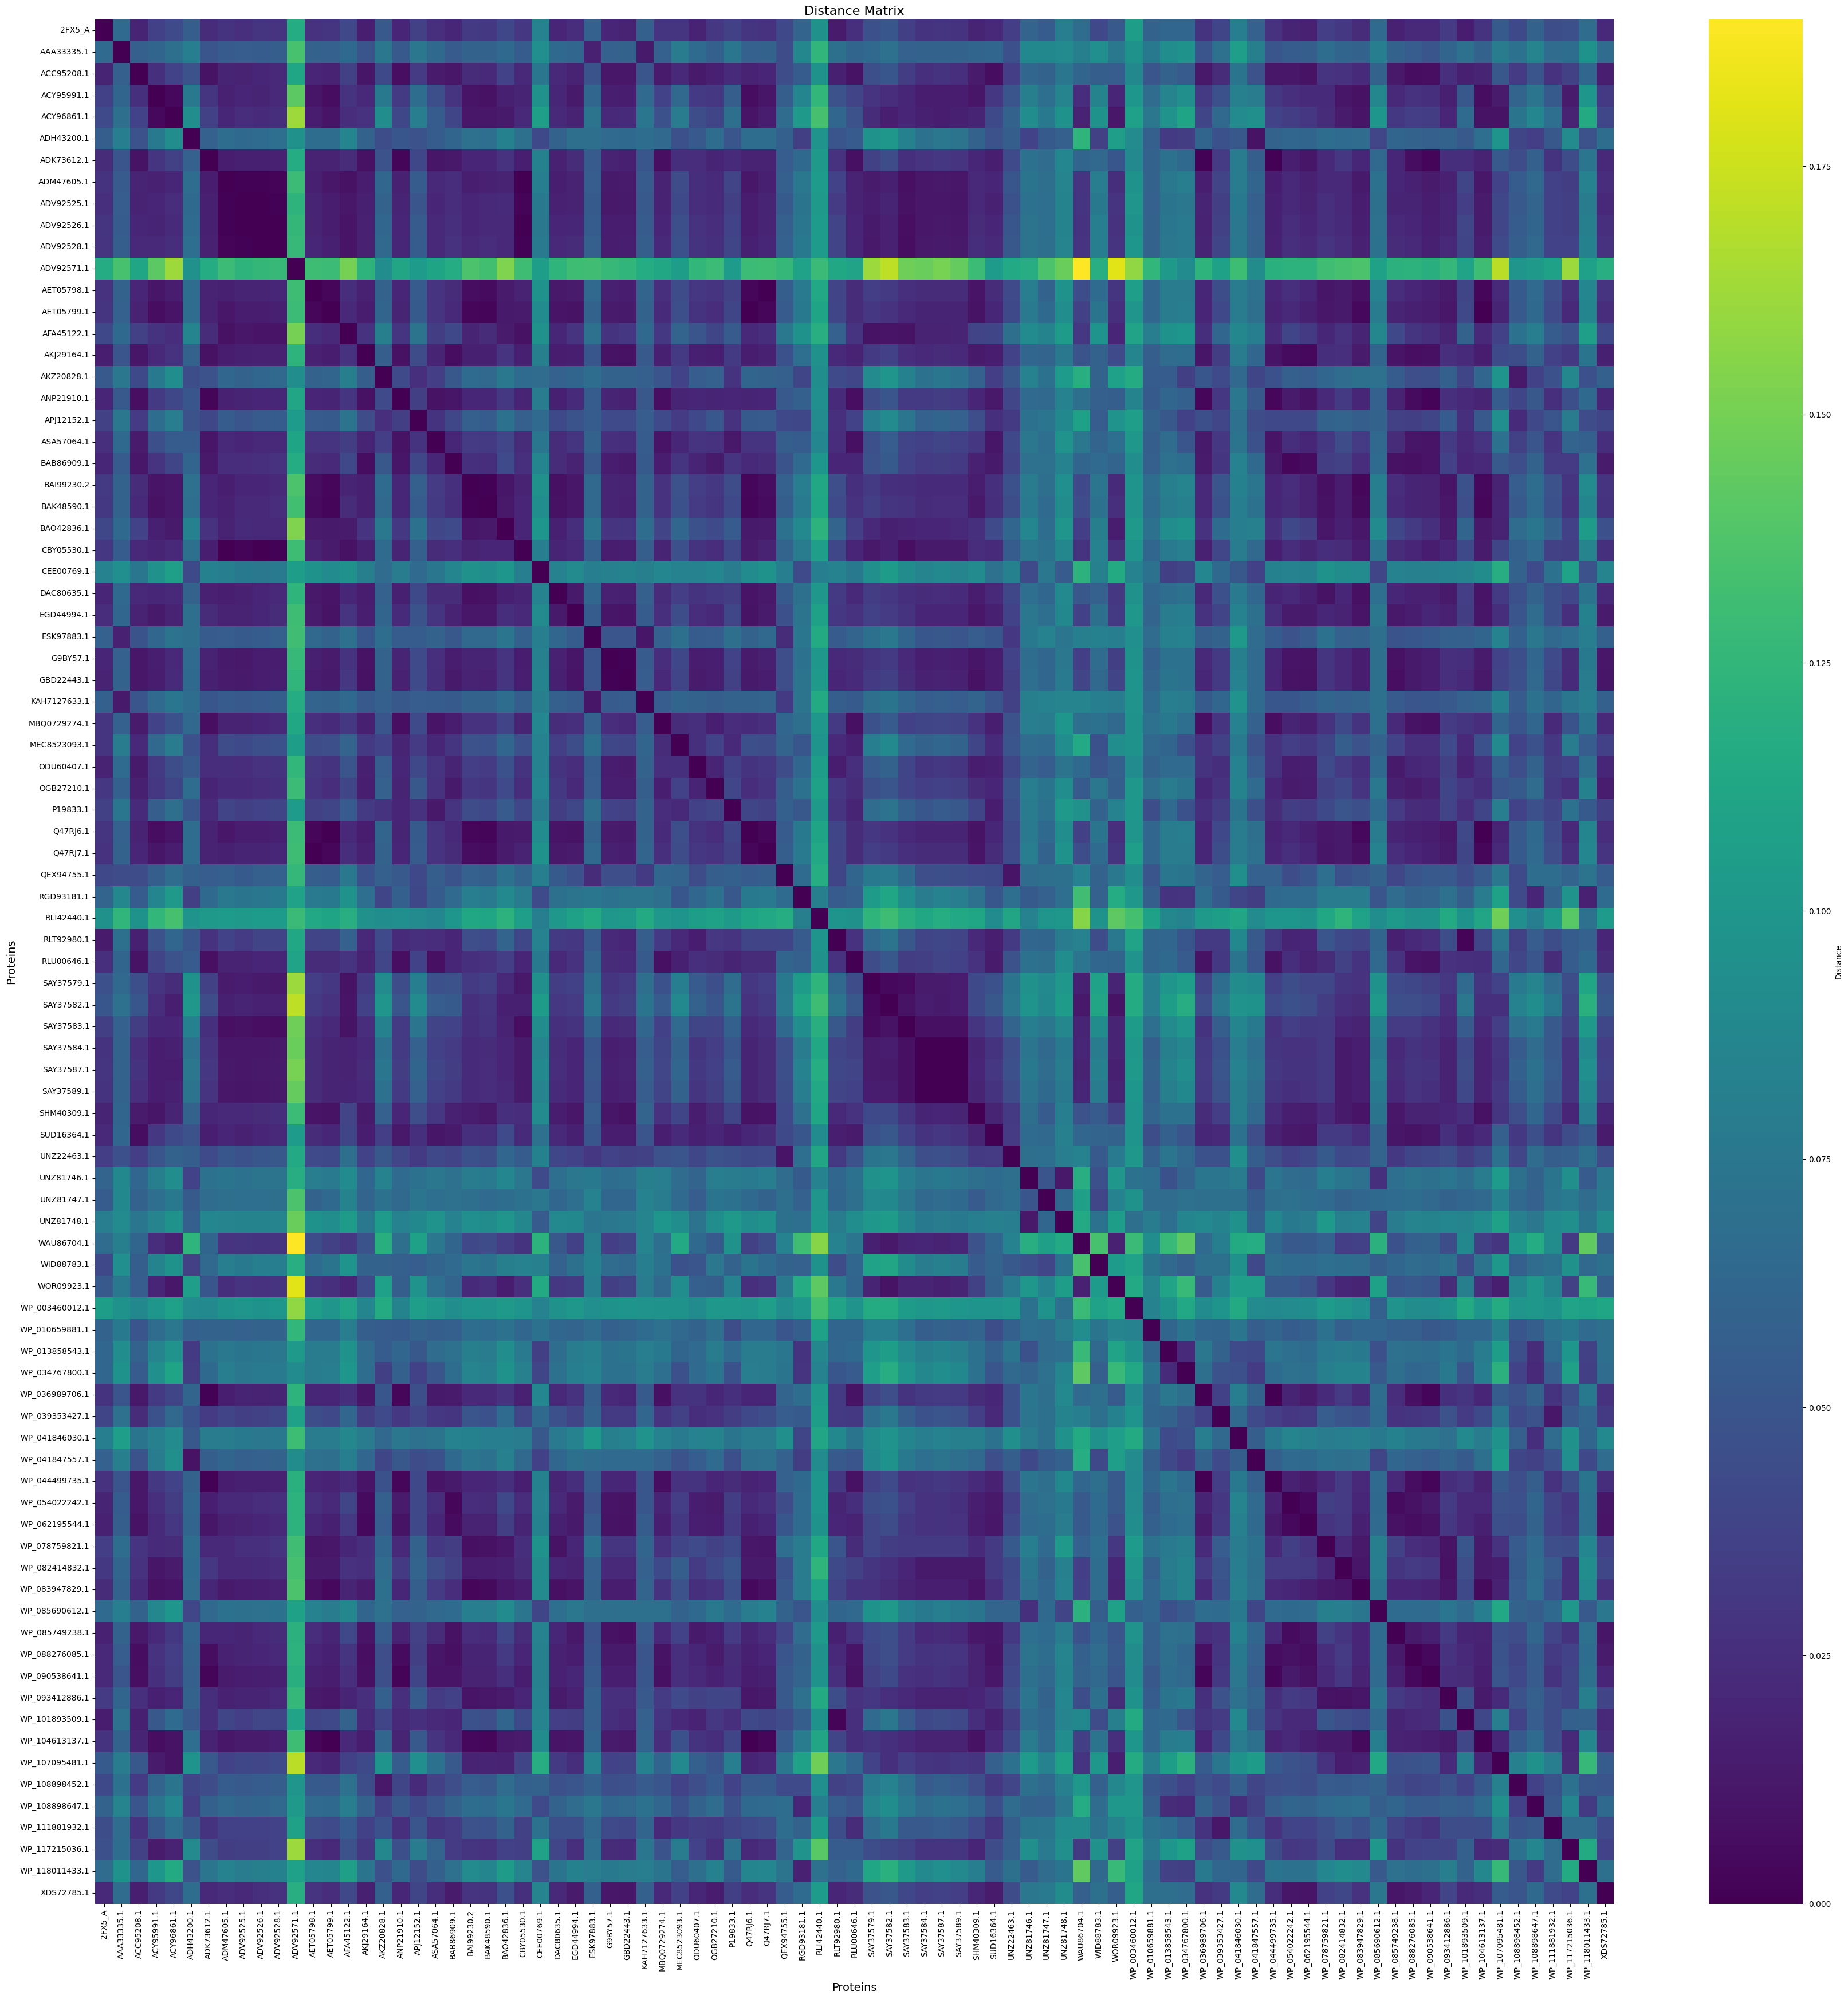

In [97]:
# Example data
proteins = protein_ids_embedding
distances = distance_matrix_embedding_cosine_alina

# Convert the distance array to a DataFrame for better labeling
distance_df = pd.DataFrame(distances, index=proteins, columns=proteins)

# Plot the heatmap
plt.figure(figsize=(35, 35))
sns.heatmap(
    distance_df, 
    annot=False,
    fmt=".2f",           
    cmap="viridis",      
    cbar_kws={'label': 'Distance'},
    annot_kws={"size": 2},
)

# Add titles and labels
plt.title("Distance Matrix", fontsize=16)
plt.xlabel("Proteins", fontsize=14)
plt.ylabel("Proteins", fontsize=14)

# Display the plot
plt.tight_layout()
plt.show()

In [98]:
# group the dissimilary score into 10 groups and give them as a lable their group number
# split the dissimiliatry score in two categories but do it based on the mean distance
# meaning do not just make the half of the proteins into one group and the other half into another group
# but make it based on the mean distance
# make it so i can determine the number of groups i want to make
# Get mean distance for each protein
mean_distances = np.mean(distances, axis=1)
from sklearn.cluster import KMeans
# Number of groups to create
n_groups = 4  # This is the number of groups we want to make

# Use KMeans clustering on the mean distances
kmeans = KMeans(n_clusters=n_groups, random_state=42)
# Reshape mean_distances to 2D array as required by KMeans
clusters = kmeans.fit_predict(mean_distances.reshape(-1, 1))

# Create empty lists to store proteins for each group
dissimilary_score_groups = [[] for _ in range(n_groups)]
dissimilary_score_groups_labels = [f"Group_{i+1}" for i in range(n_groups)]

# Assign proteins to their respective groups
for i, (protein, cluster) in enumerate(zip(proteins, clusters)):
    # Store tuple of (protein_id, mean_distance) in appropriate group
    dissimilary_score_groups[cluster].append((protein, mean_distances[i]))

# Sort proteins within each group by their mean distance
for group in dissimilary_score_groups:
    group.sort(key=lambda x: x[1])



# now add them to the dict_id_label
for i in range(len(dissimilary_score_groups)):
    for protein in dissimilary_score_groups[i]:
        dict_id_label[protein[0]] = dissimilary_score_groups_labels[i]


Number of proteins in visualization: 87
{'Group_3', 'Group_4', 'Group_1', 'Group_2'}
{'Group_3': 'green', 'Group_4': 'orange', 'Group_1': 'blue', 'Group_2': 'red'}


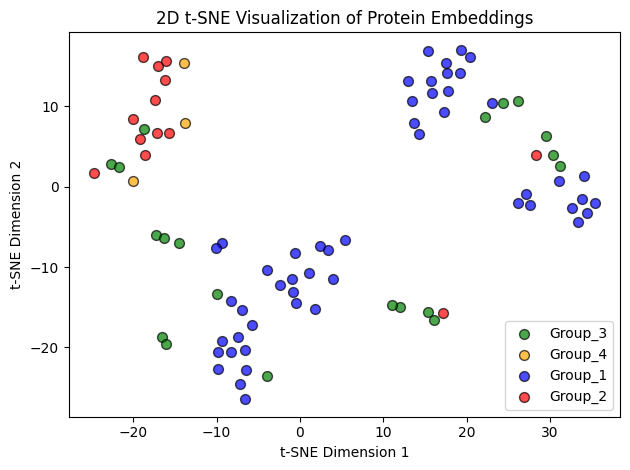

In [99]:
embedding_tool = EmbeddingTool()

# get all of the data from embedding
protein_ids, embeddings_2d, labels, colors = embedding_tool.calculate_2d_projection_tsne(db = eedb.db, ids_list=ids, ids_list_labels=dict_id_label, perplexity=8, n_iter=3000, random_state=42)

print(f"Number of proteins in visualization: {len(protein_ids)}")

# make the None objects to 'None' in labels
labels = ['None' if x is None else x for x in labels]

# create a scatter plot for each unique label
unique_labels = set(labels)
unique_color_labels = {}
print(unique_labels)
for label in unique_labels:
    indices = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(
        [embeddings_2d[i, 0] for i in indices],
        [embeddings_2d[i, 1] for i in indices],
        c=[colors[indices[0]]],
        label=label,
        alpha=0.7,
        s=50,
        edgecolor="k",
    )
    
    # store the color for the label
    unique_color_labels[label] = colors[indices[0]]

print(unique_color_labels)

plt.title("2D t-SNE Visualization of Protein Embeddings")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
plt.tight_layout()
plt.show()

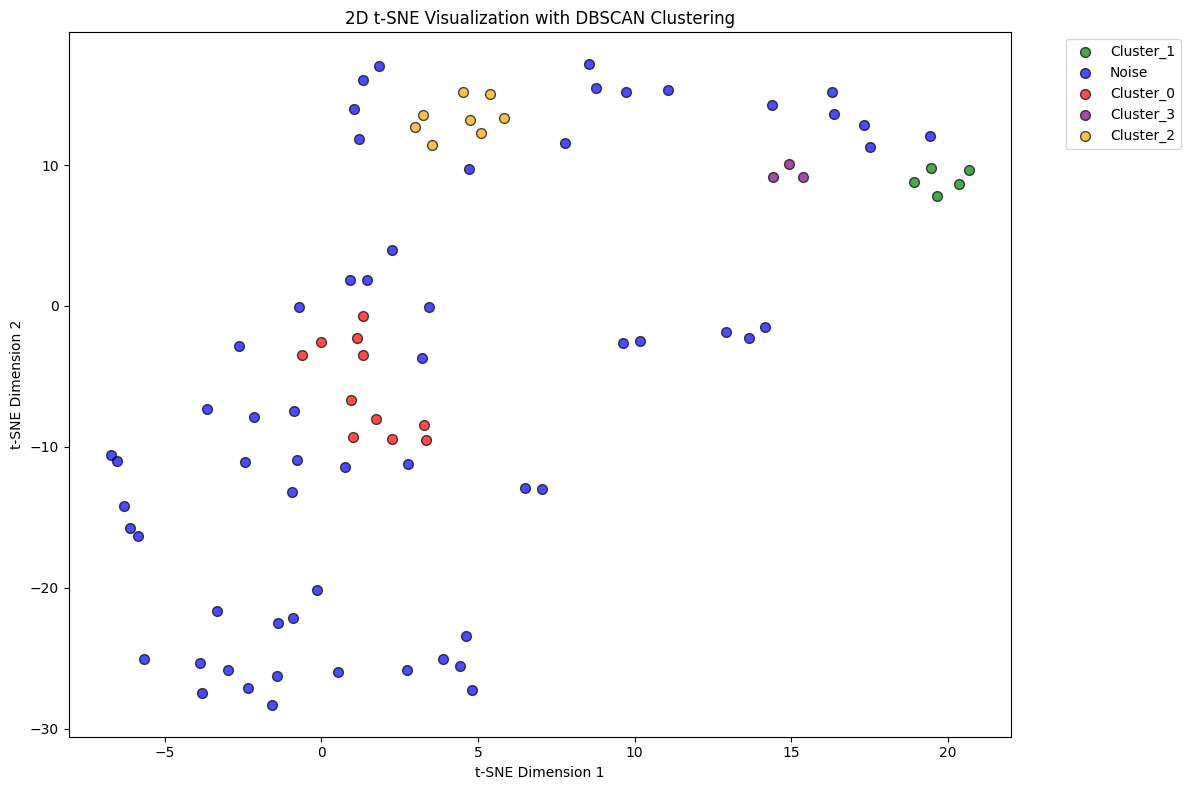


Cluster Statistics:
Noise        60
Cluster_0    11
Cluster_2     8
Cluster_1     5
Cluster_3     3
Name: count, dtype: int64


In [100]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Standardize the distances for better DBSCAN performance
scaler = StandardScaler()
distances_scaled = scaler.fit_transform(distances)

# Apply DBSCAN
dbscan = DBSCAN(eps=1.8, min_samples=3)  # You may need to adjust these parameters
clusters = dbscan.fit_predict(distances_scaled)

# Create a new dictionary mapping protein IDs to cluster labels
dict_id_label = {}
for protein_id, cluster in zip(proteins, clusters):
    dict_id_label[protein_id] = f"Cluster_{cluster}" if cluster != -1 else "Noise"

# Calculate t-SNE projection with the new cluster labels
protein_ids, embeddings_2d, labels, colors = embedding_tool.calculate_2d_projection_tsne(
    db=eedb.db, 
    ids_list=ids, 
    ids_list_labels=dict_id_label, 
    perplexity=10, 
    n_iter=3000, 
    random_state=42
)

# Create the visualization
plt.figure(figsize=(12, 8))

# Convert None to 'None' in labels
labels = ['None' if x is None else x for x in labels]

# Plot each cluster
unique_labels = set(labels)
for label in unique_labels:
    indices = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(
        [embeddings_2d[i, 0] for i in indices],
        [embeddings_2d[i, 1] for i in indices],
        c=[colors[indices[0]]],
        label=label,
        alpha=0.7,
        s=50,
        edgecolor="k",
    )

plt.title("2D t-SNE Visualization with DBSCAN Clustering")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Print cluster statistics
cluster_counts = pd.Series(labels).value_counts()
print("\nCluster Statistics:")
print(cluster_counts)

/tmp/ipykernel_1803696/3155096583.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


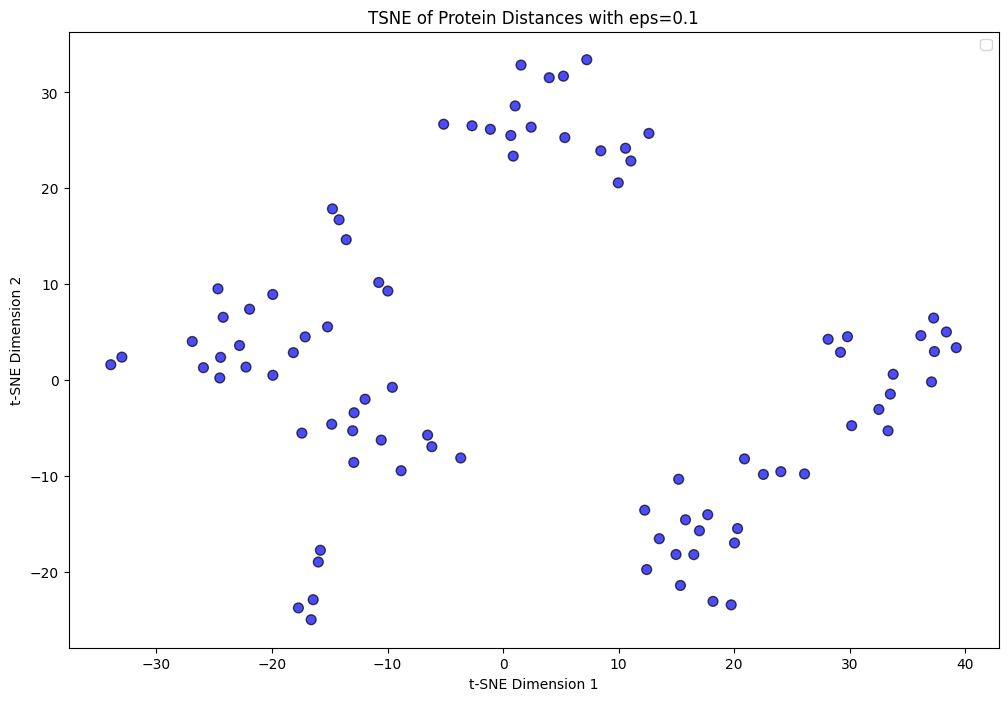

/tmp/ipykernel_1803696/3155096583.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


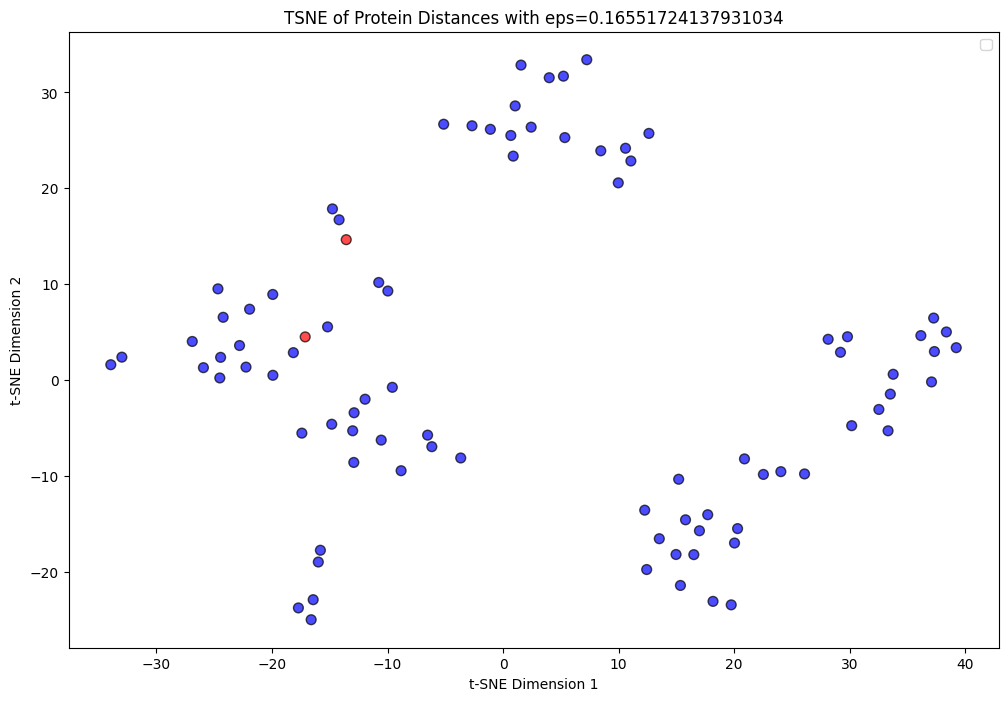

/tmp/ipykernel_1803696/3155096583.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


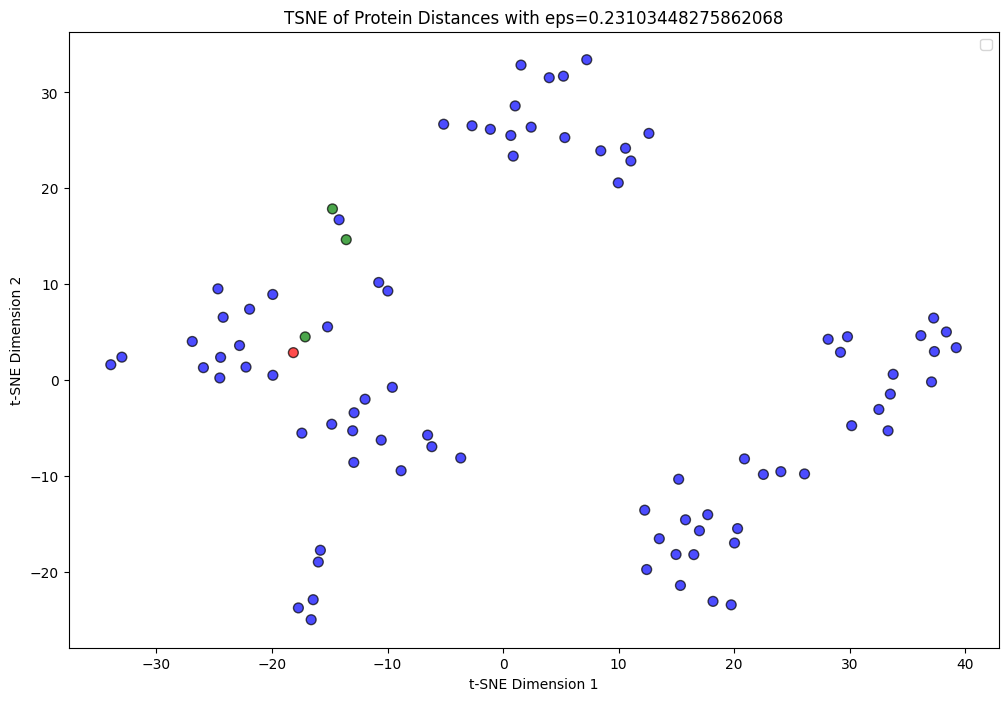

/tmp/ipykernel_1803696/3155096583.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


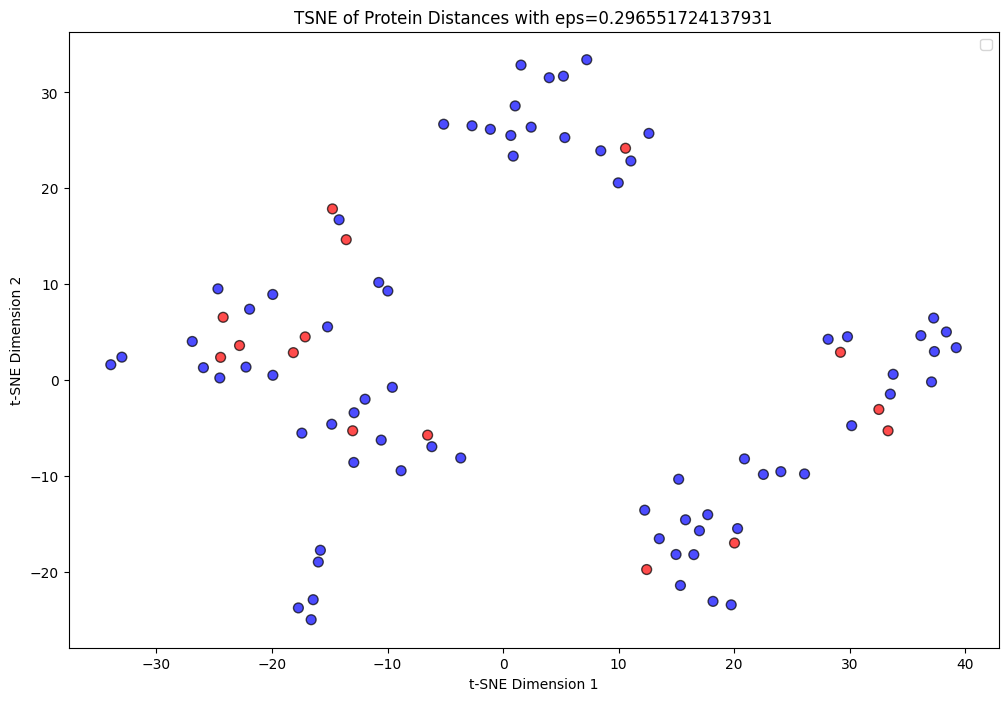

/tmp/ipykernel_1803696/3155096583.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


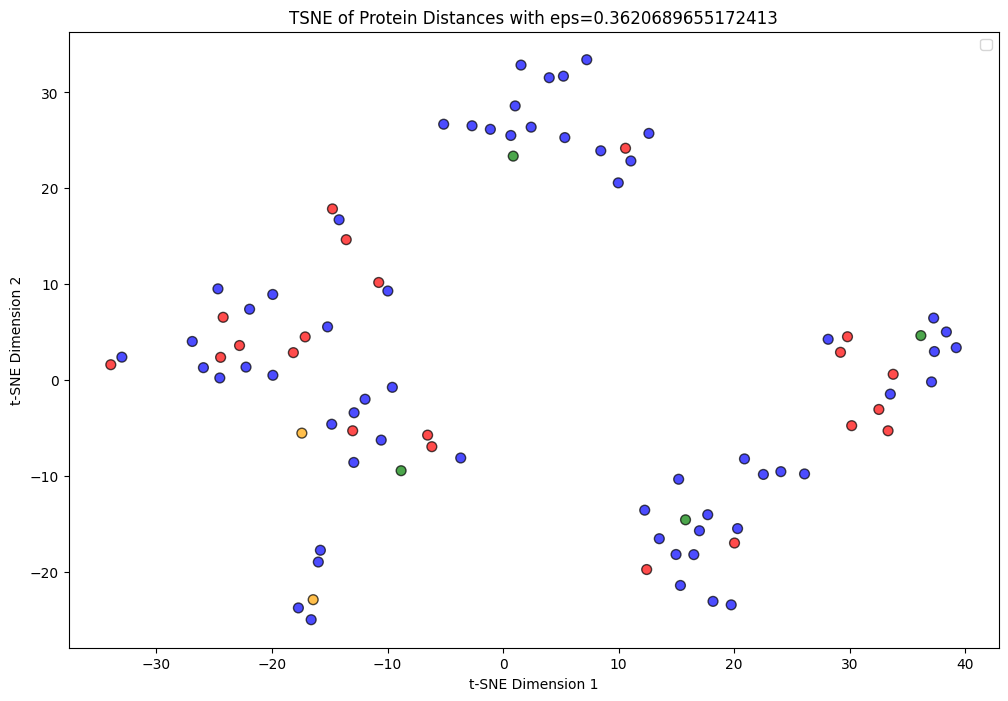

/tmp/ipykernel_1803696/3155096583.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


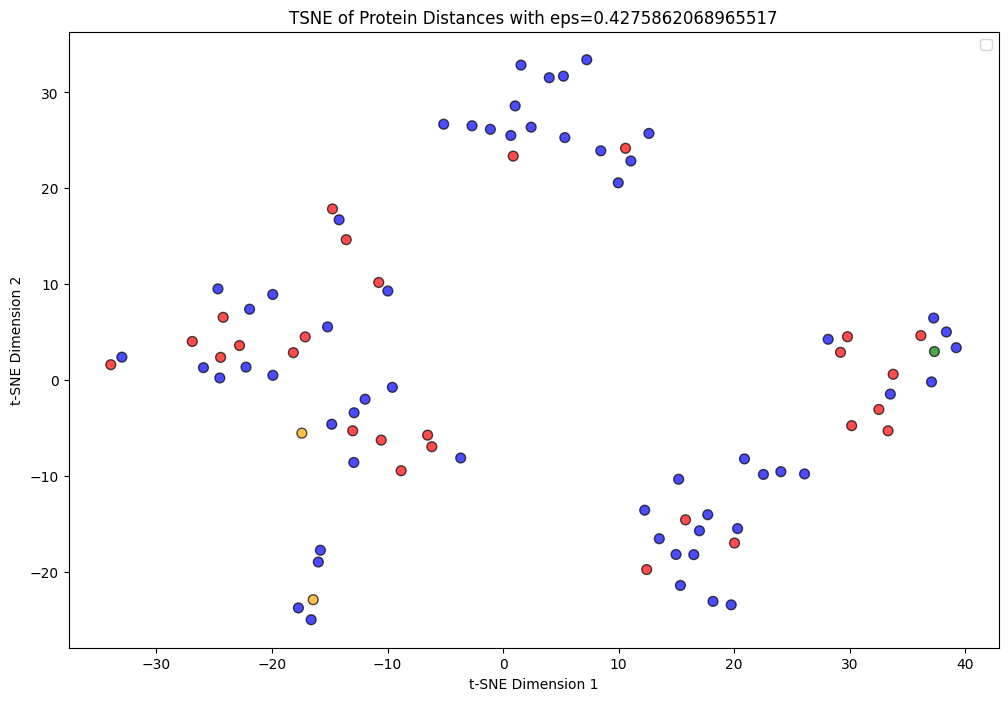

/tmp/ipykernel_1803696/3155096583.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


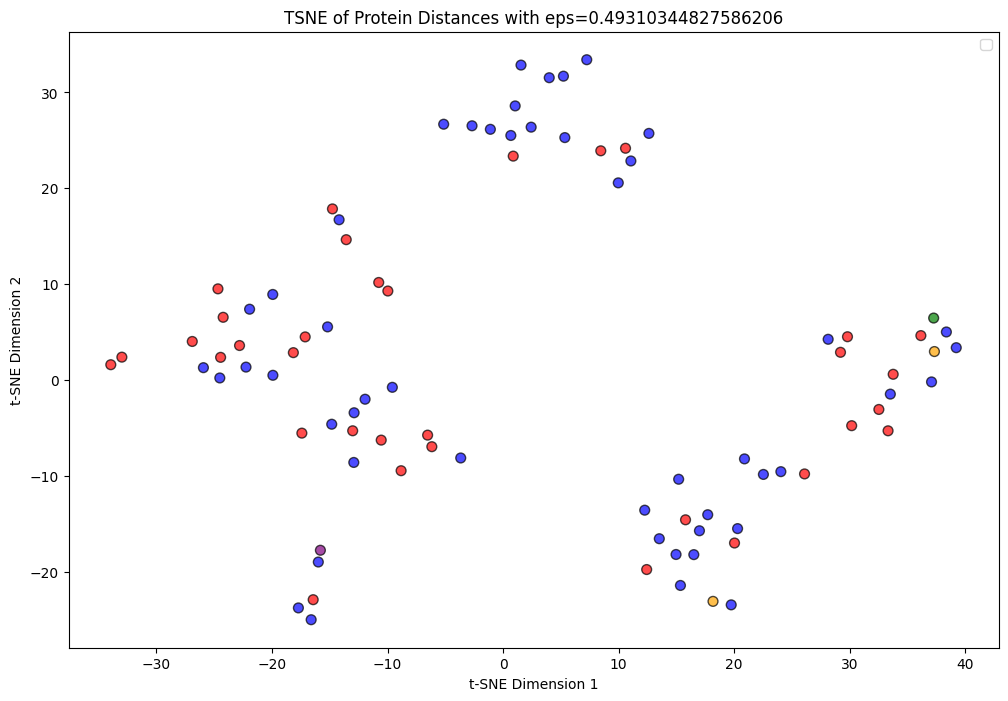

/tmp/ipykernel_1803696/3155096583.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


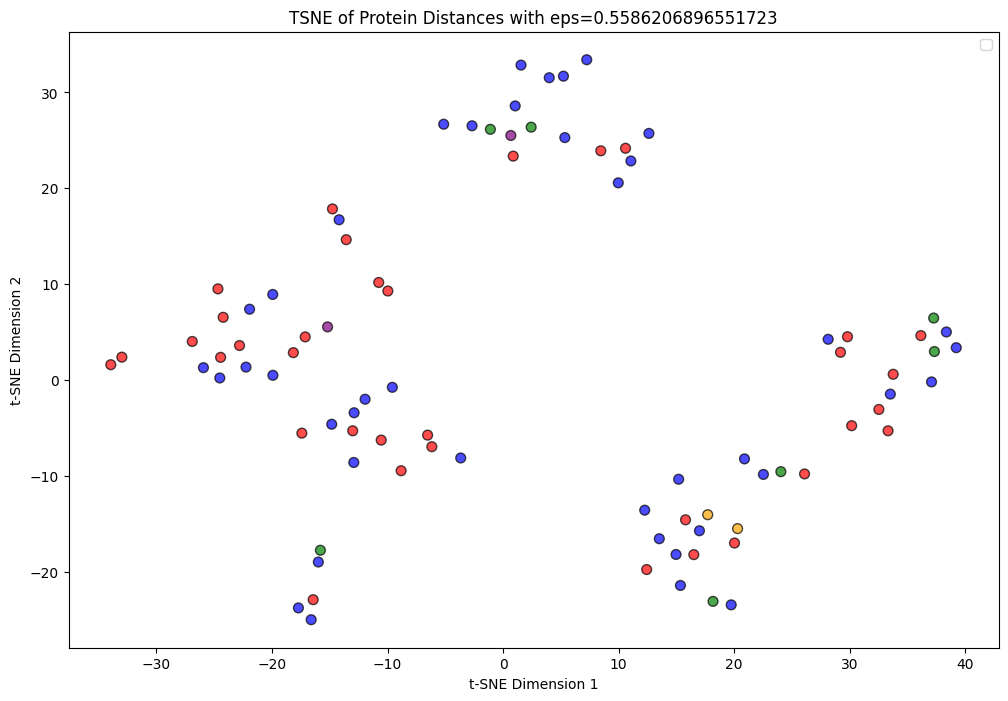

/tmp/ipykernel_1803696/3155096583.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


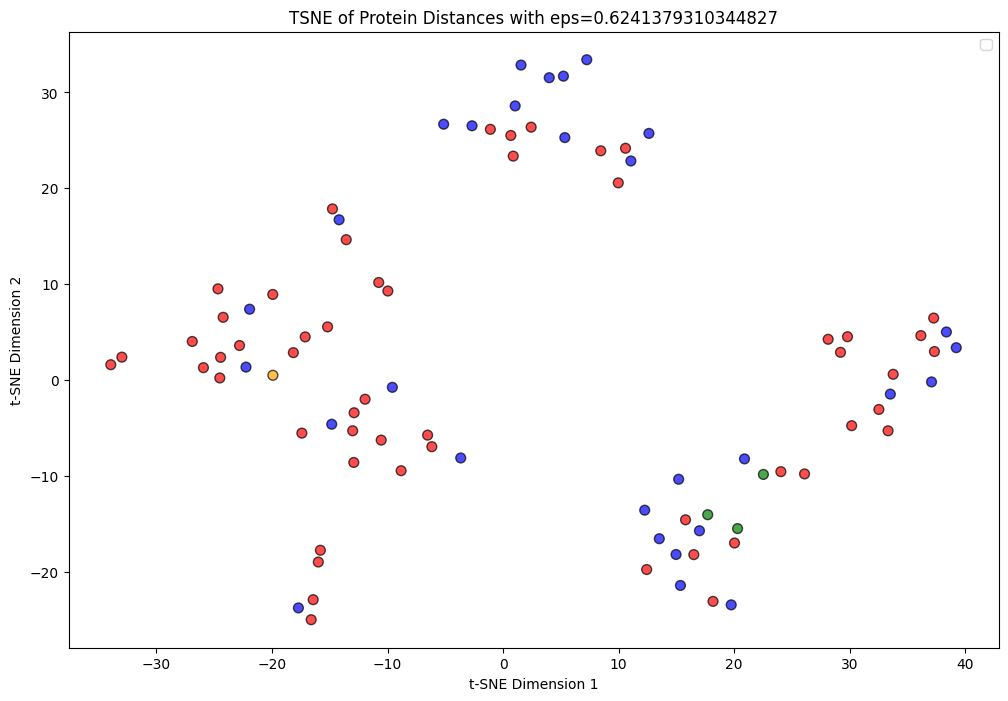

/tmp/ipykernel_1803696/3155096583.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


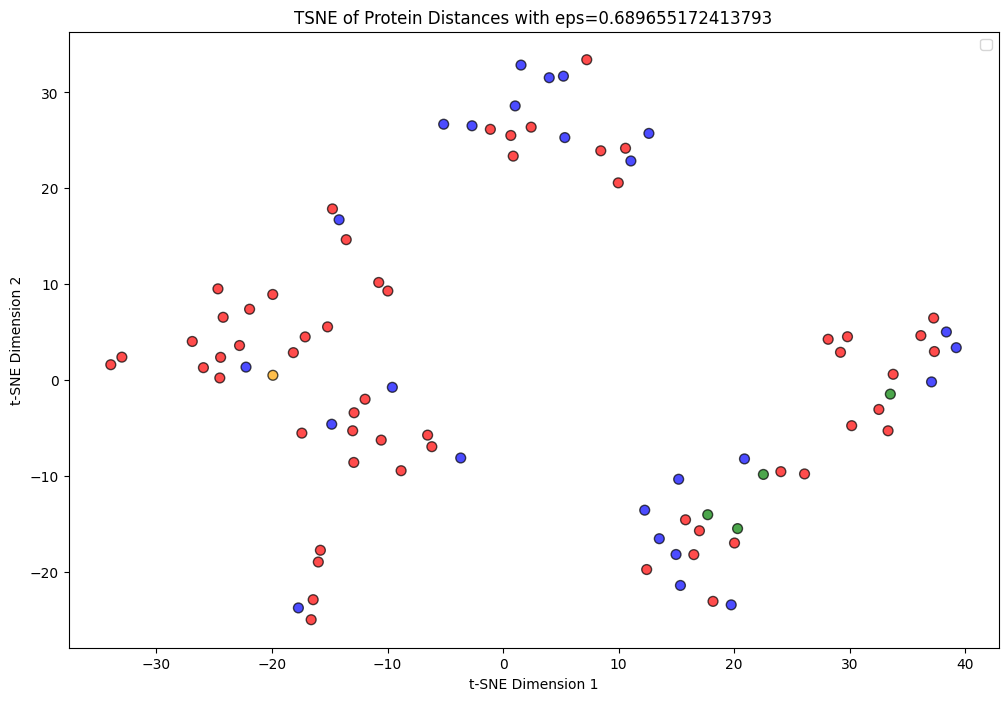

/tmp/ipykernel_1803696/3155096583.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


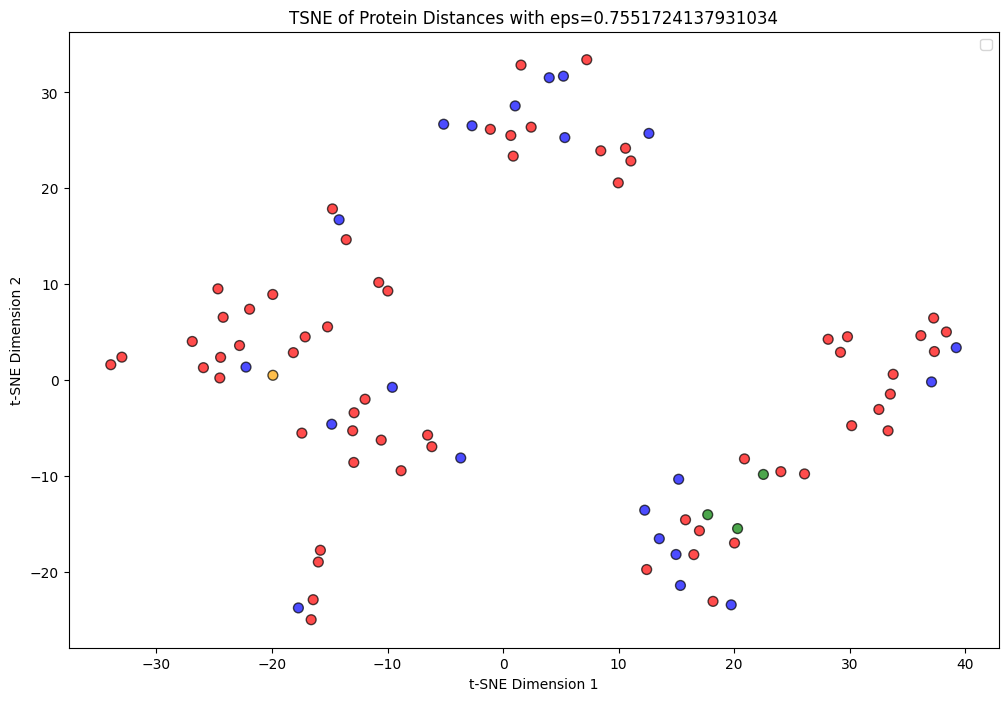

/tmp/ipykernel_1803696/3155096583.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


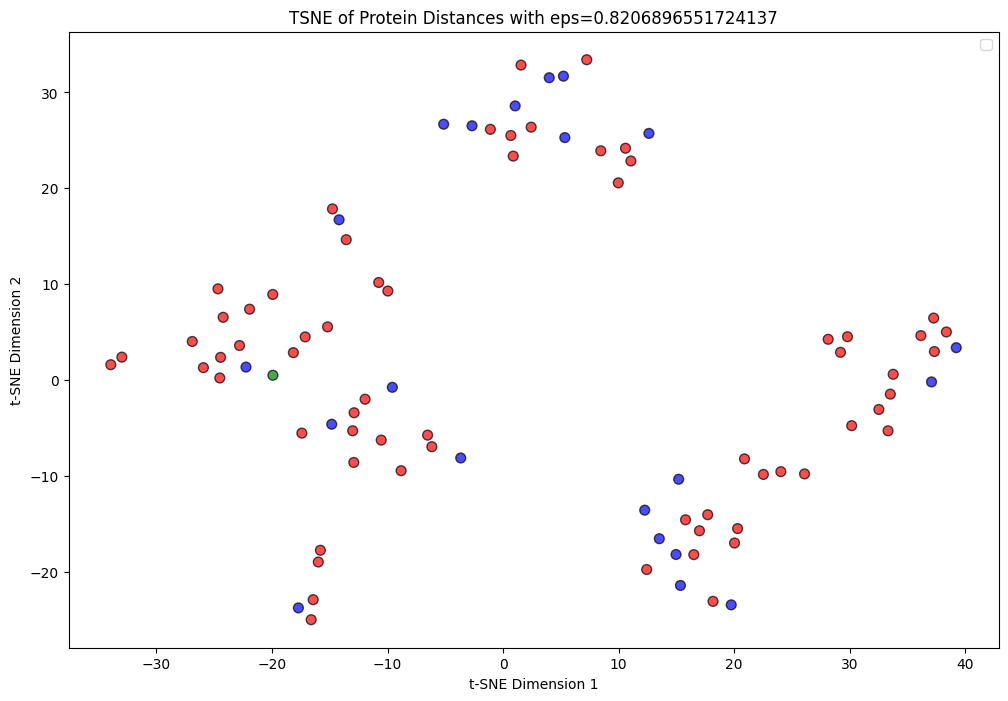

/tmp/ipykernel_1803696/3155096583.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


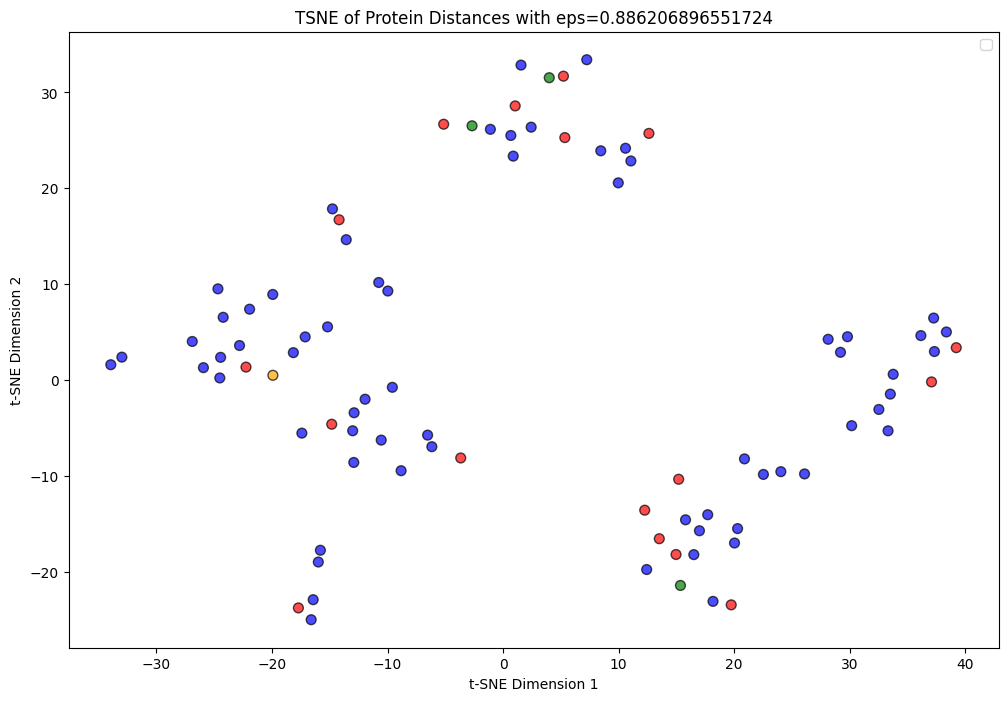

/tmp/ipykernel_1803696/3155096583.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


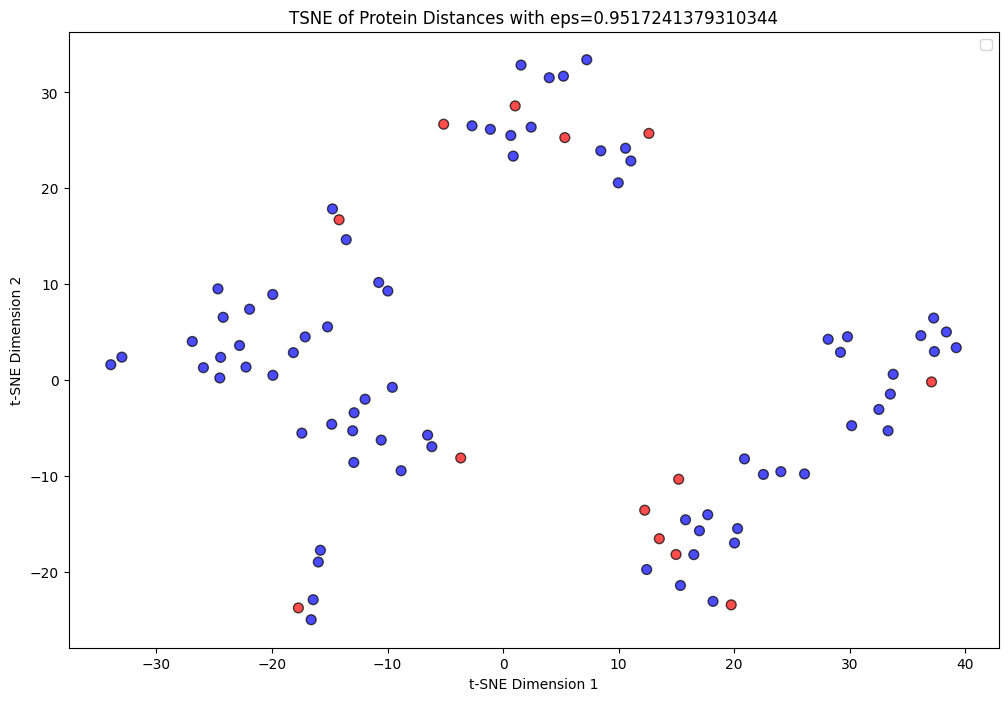

/tmp/ipykernel_1803696/3155096583.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


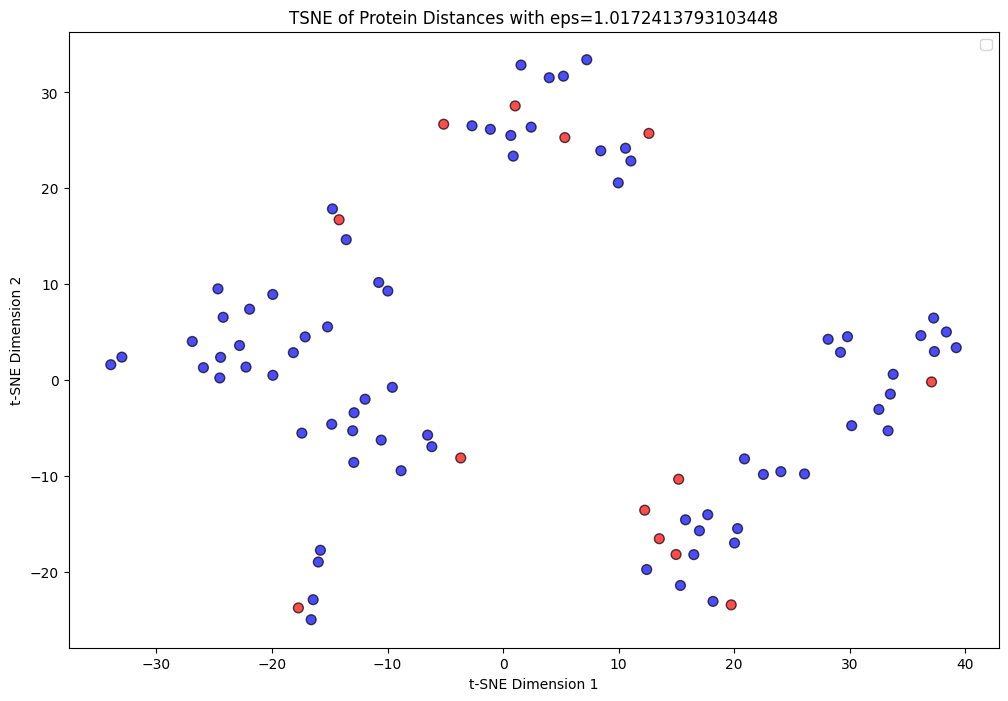

/tmp/ipykernel_1803696/3155096583.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


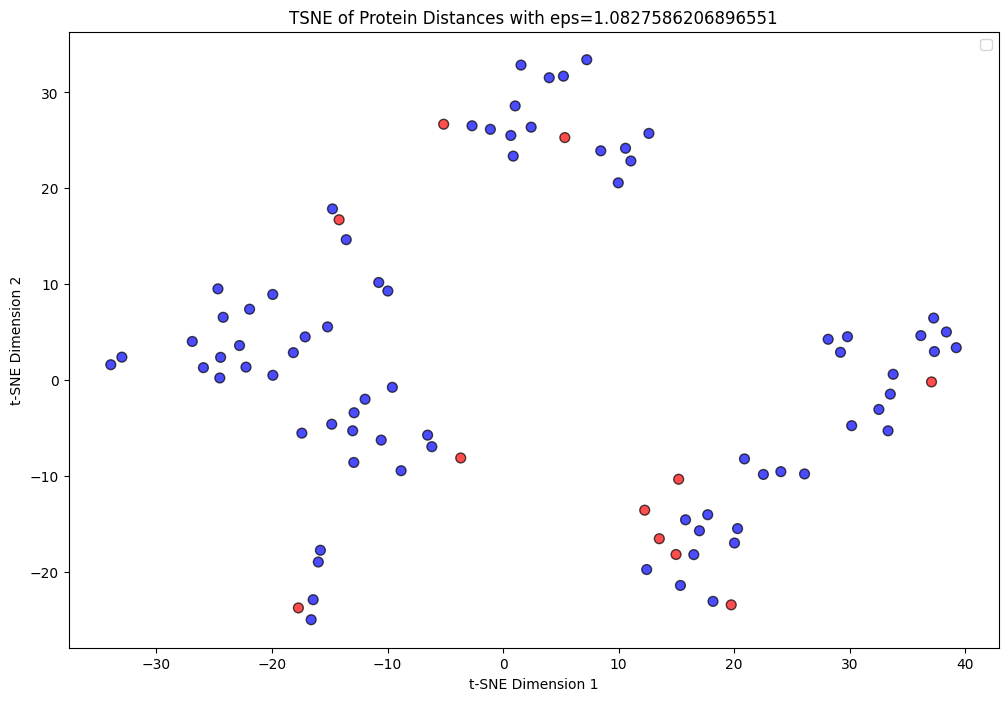

/tmp/ipykernel_1803696/3155096583.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


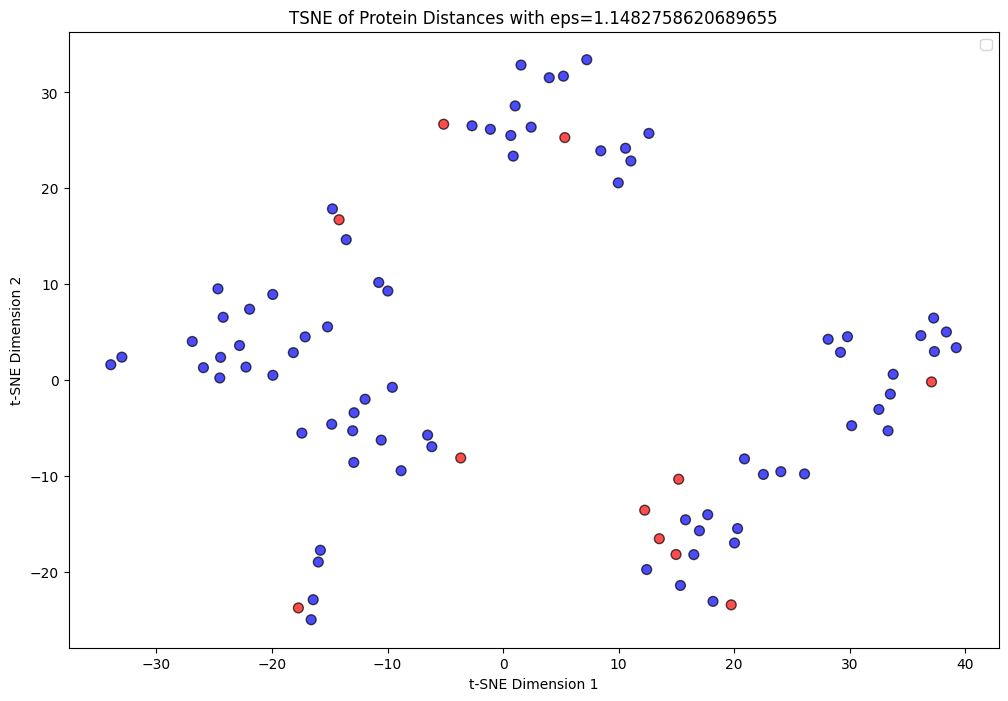

/tmp/ipykernel_1803696/3155096583.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


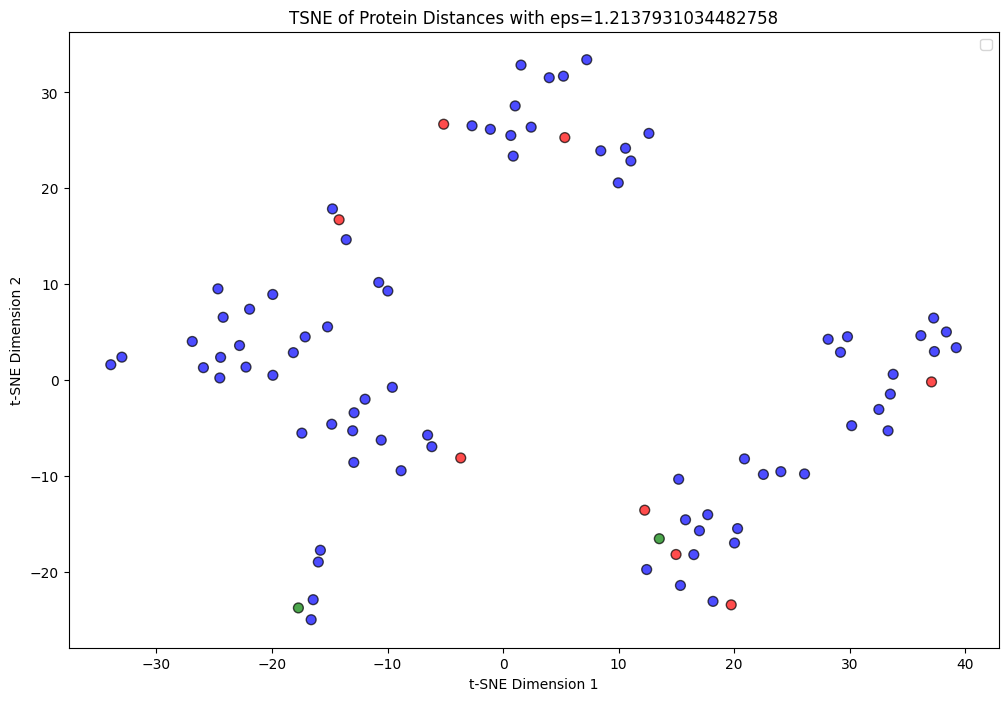

/tmp/ipykernel_1803696/3155096583.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


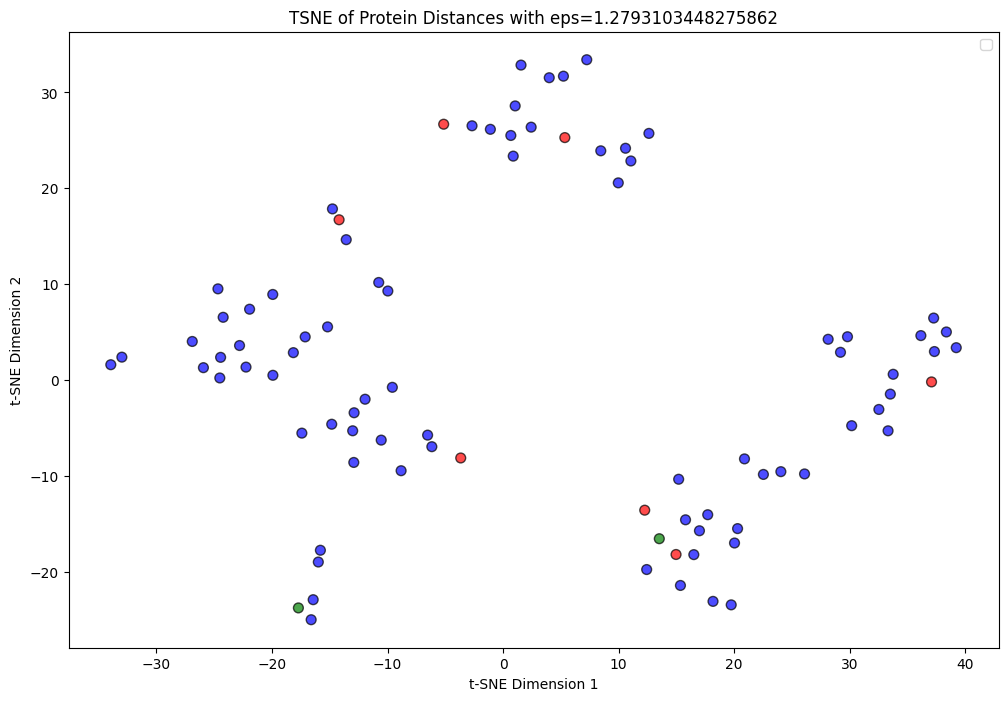

/tmp/ipykernel_1803696/3155096583.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


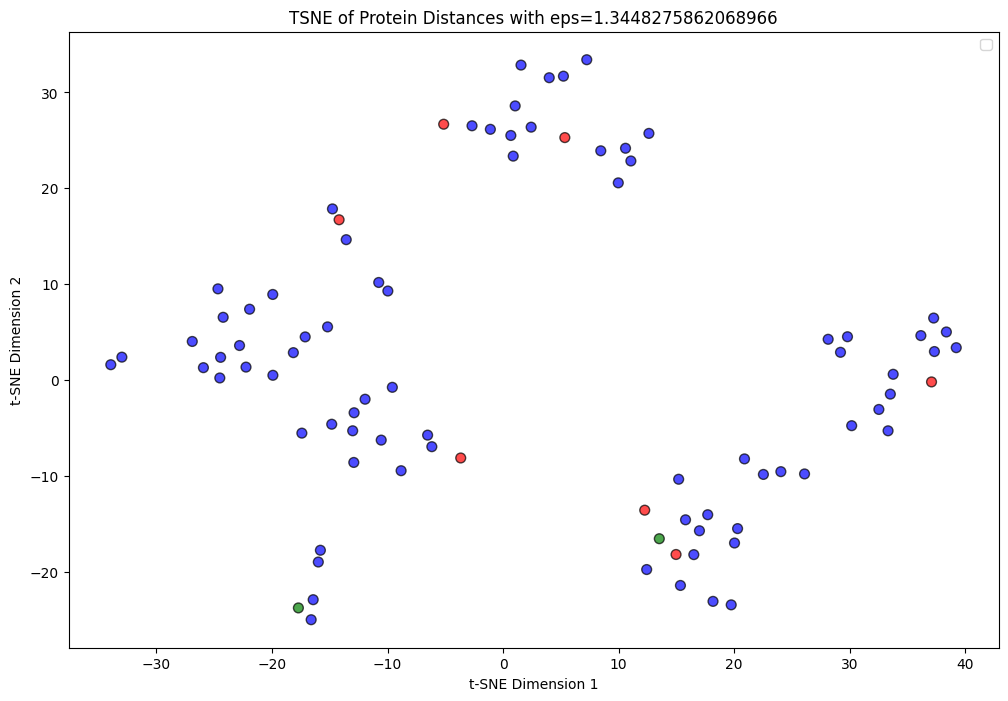

/tmp/ipykernel_1803696/3155096583.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


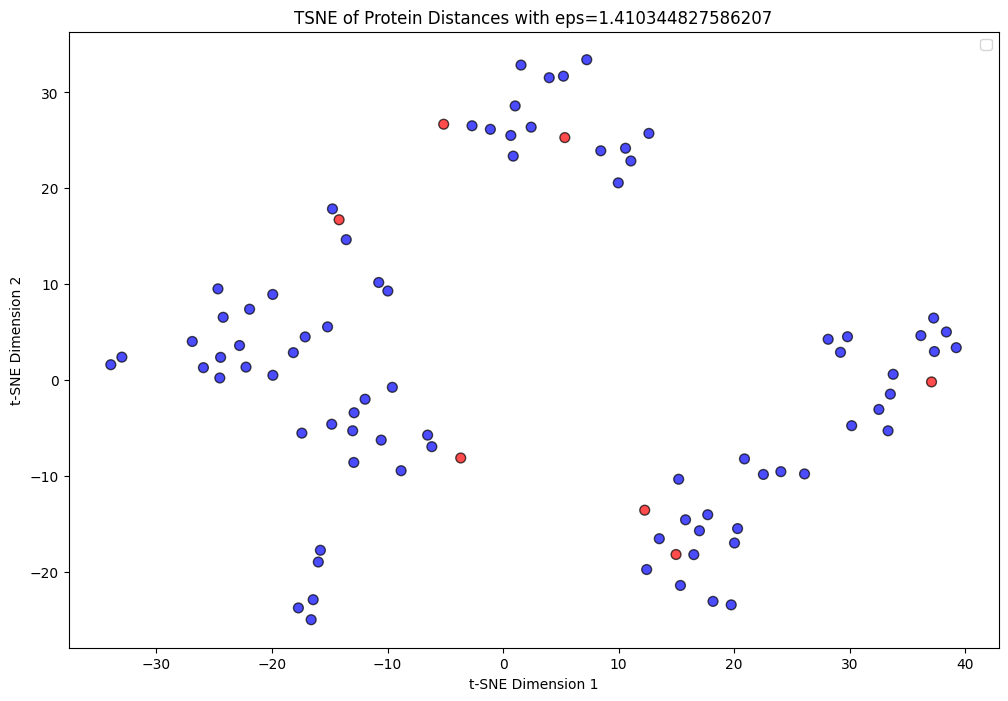

/tmp/ipykernel_1803696/3155096583.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


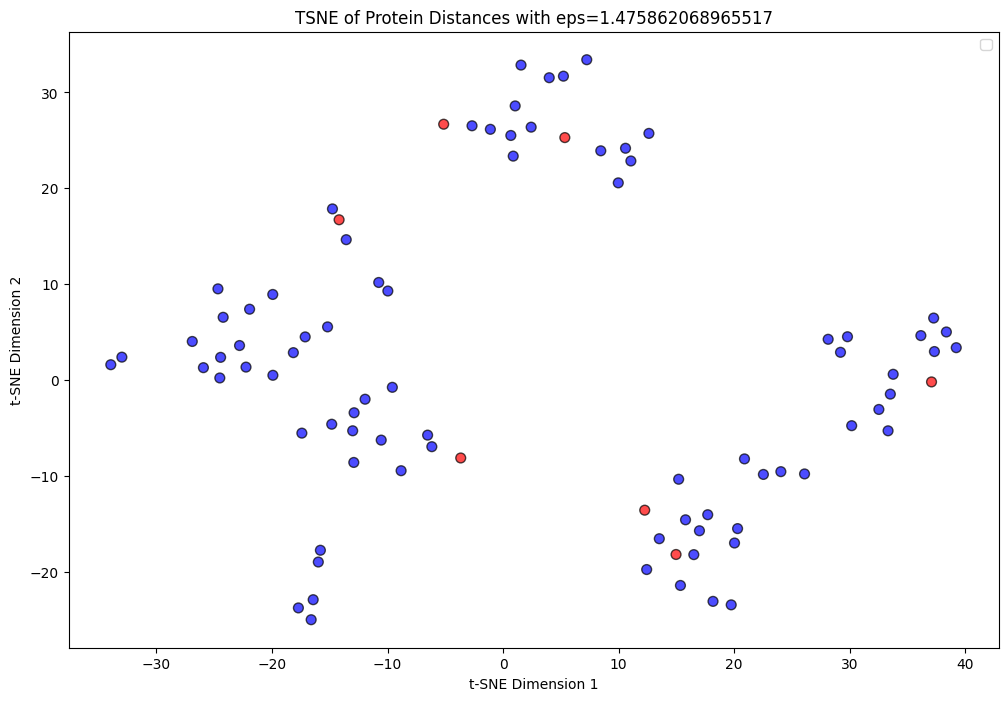

/tmp/ipykernel_1803696/3155096583.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


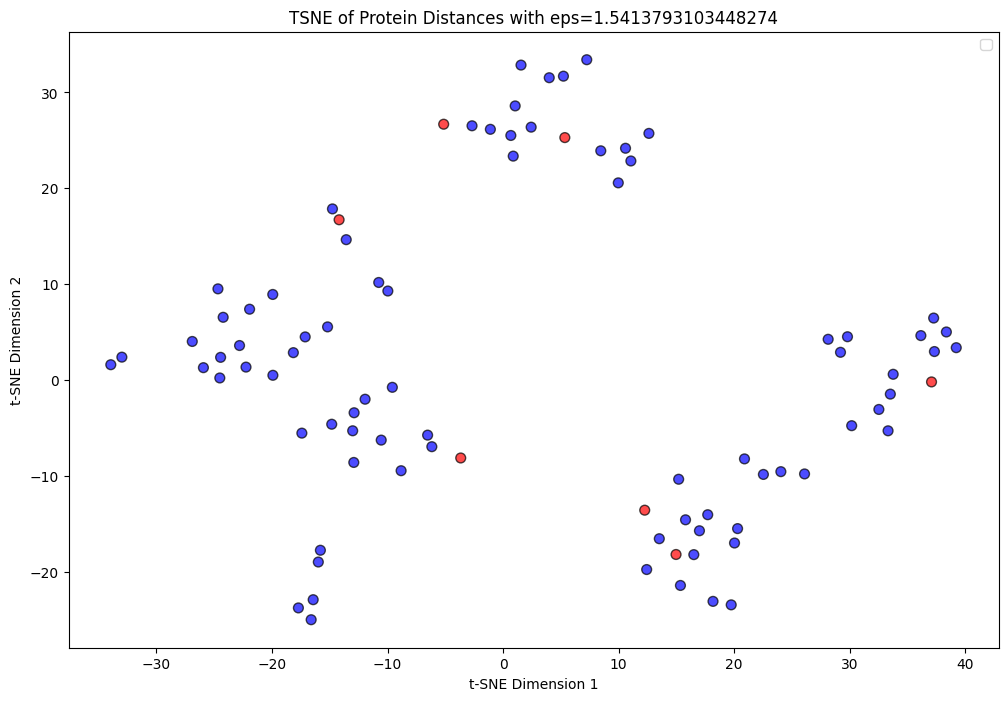

/tmp/ipykernel_1803696/3155096583.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


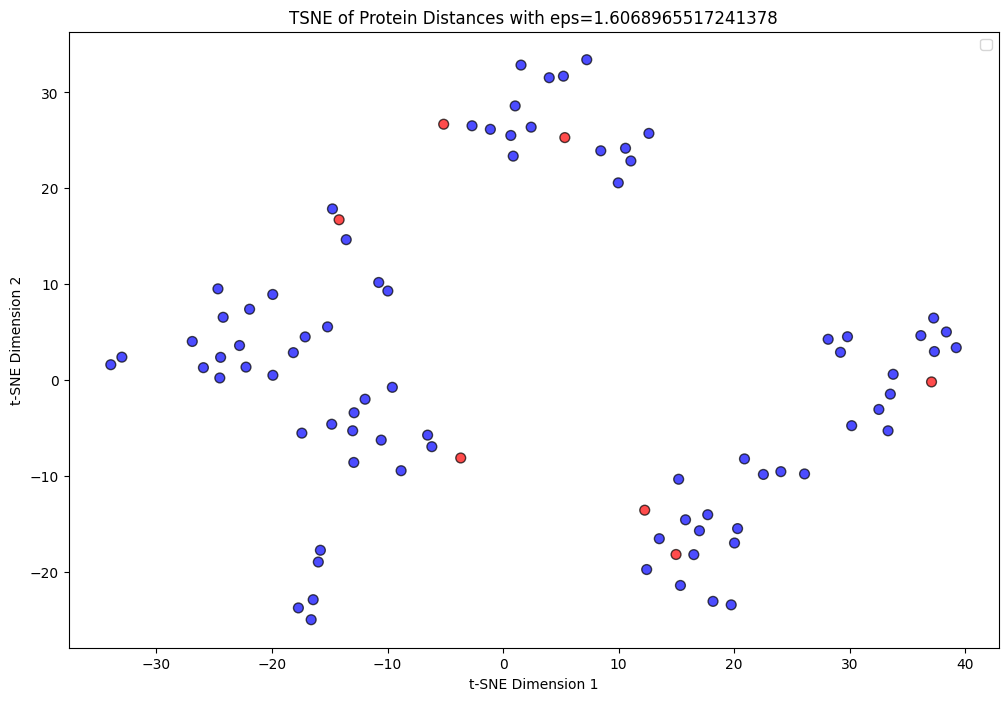

/tmp/ipykernel_1803696/3155096583.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


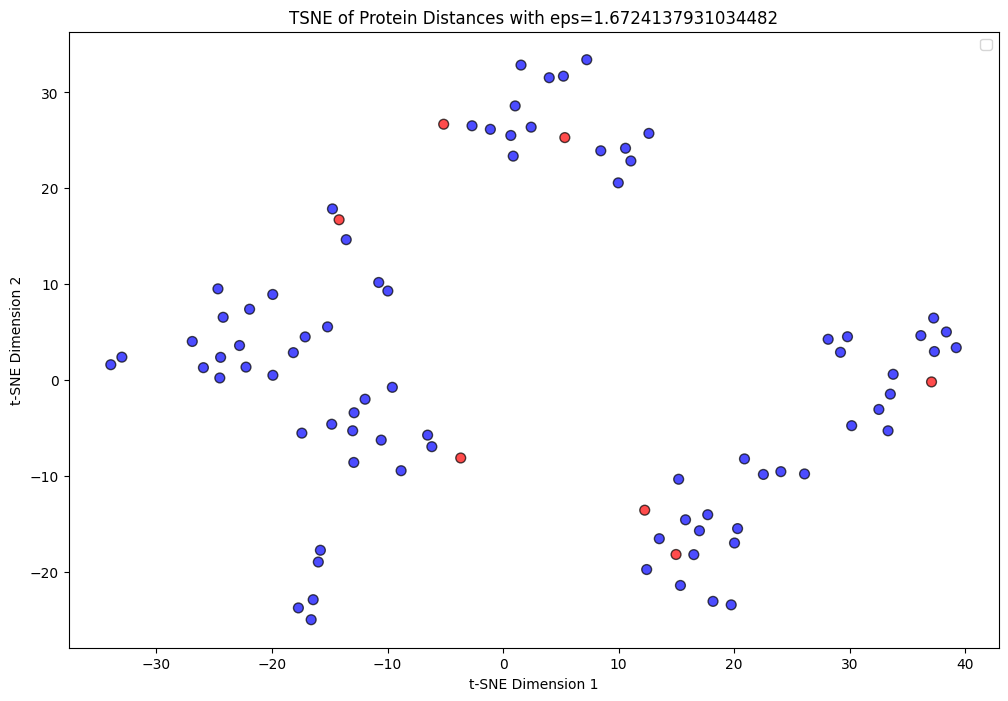

/tmp/ipykernel_1803696/3155096583.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


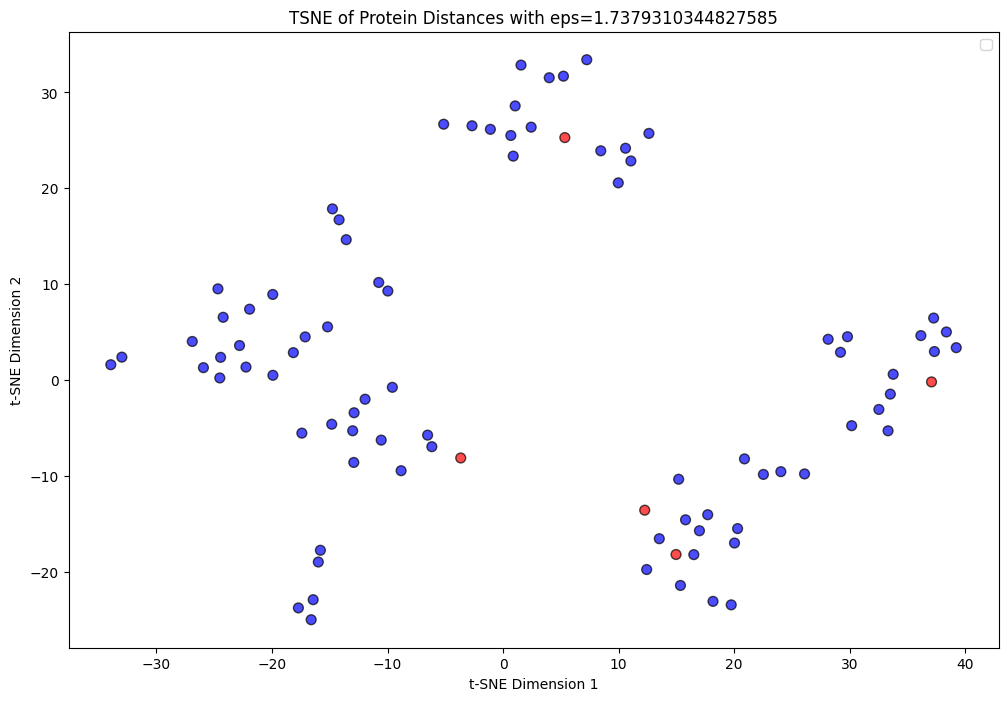

/tmp/ipykernel_1803696/3155096583.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


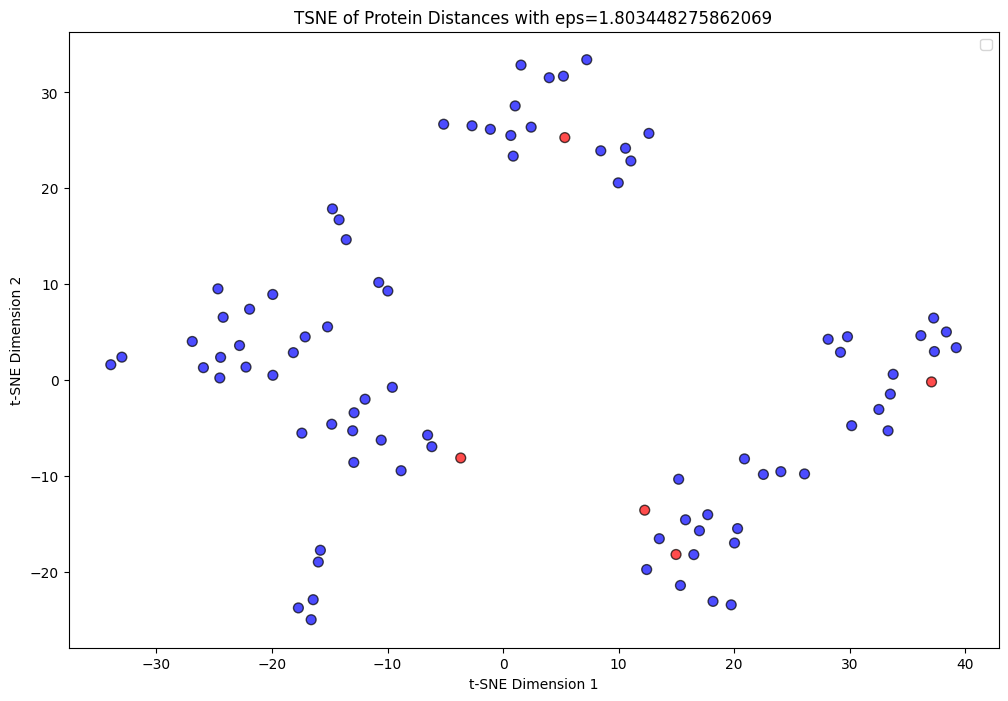

/tmp/ipykernel_1803696/3155096583.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


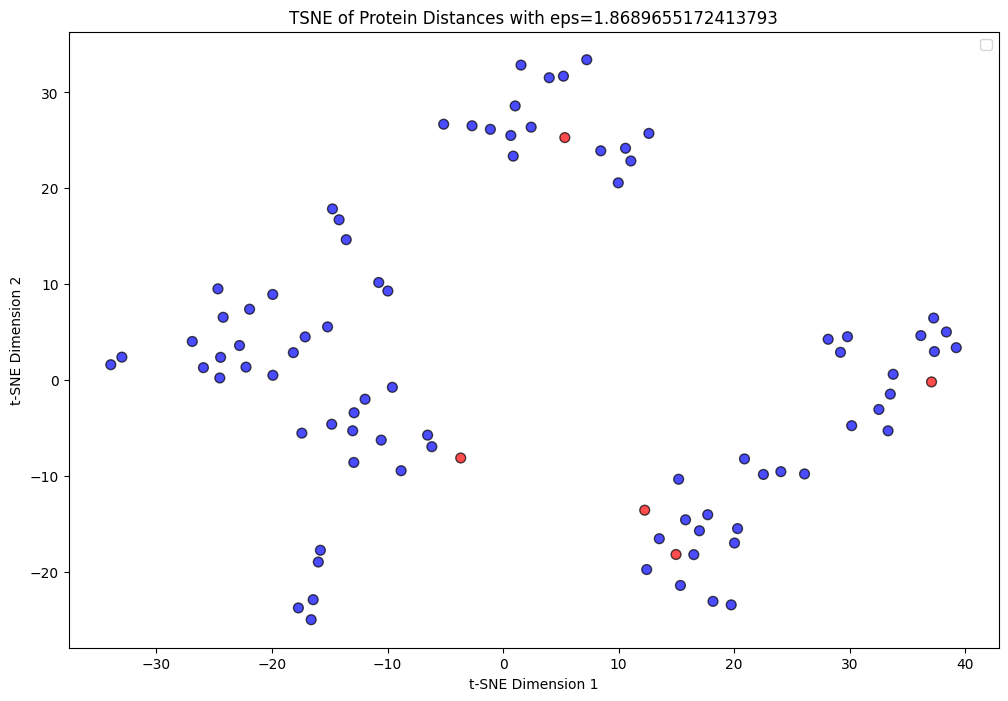

/tmp/ipykernel_1803696/3155096583.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


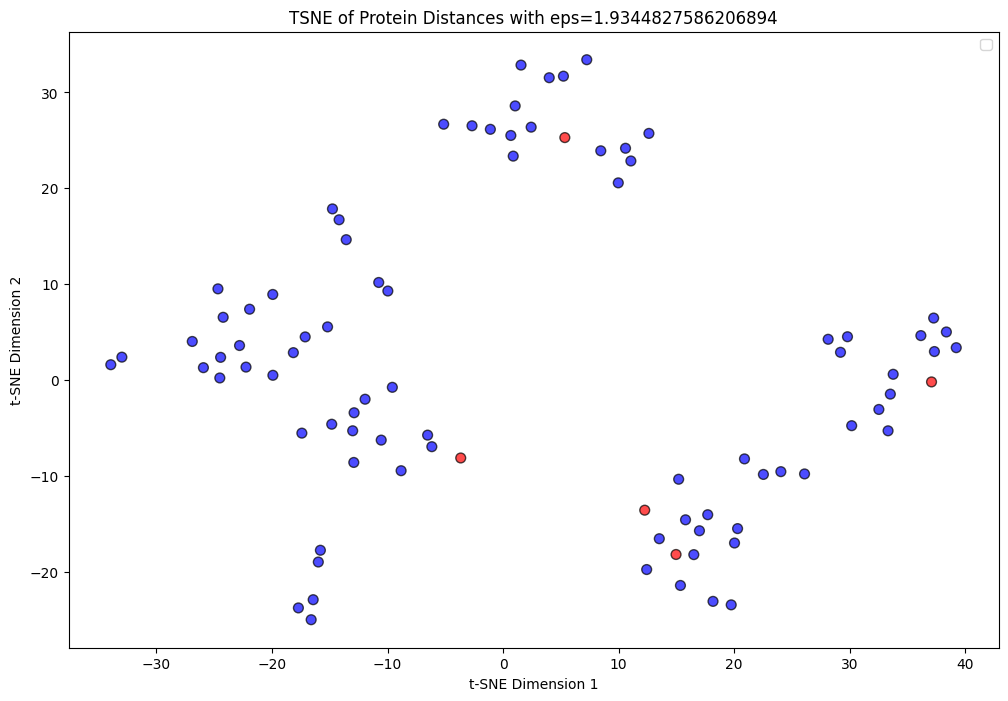

/tmp/ipykernel_1803696/3155096583.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


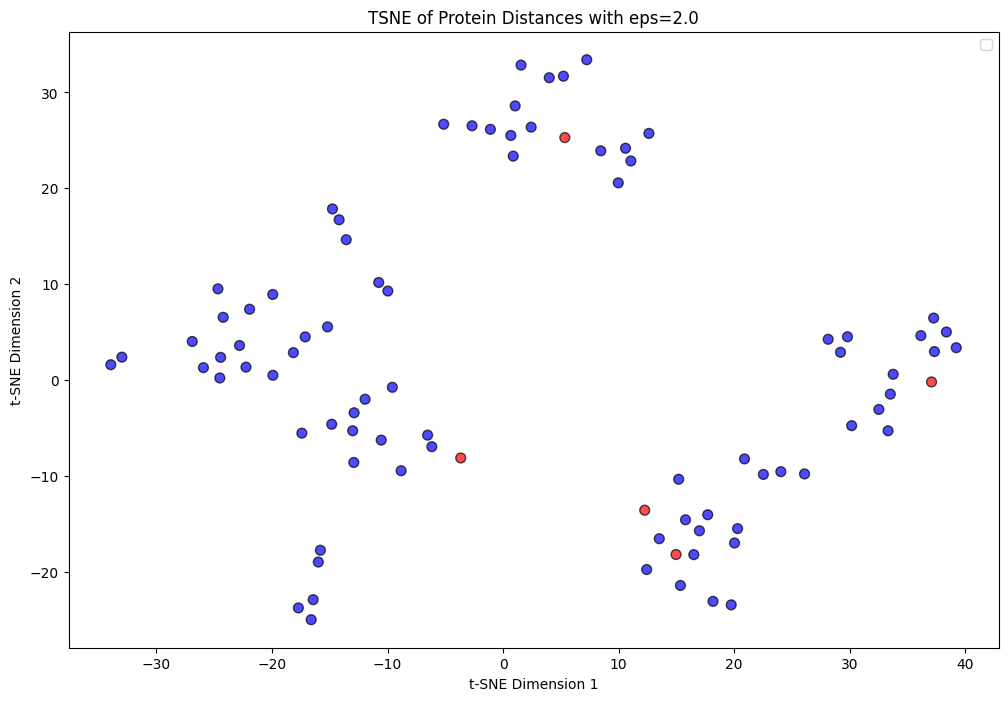

In [111]:
# okay now lets first to a PCA with dimensions reduction and then try a dbscan on the PCA results
# the visualization should be a 2D plot of the TSNE embedding
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

# lets first do the PCA
pca = PCA(n_components=5)
pca_result = pca.fit_transform(distance_matrix_embeddings_cosine)

# scale the PCA result
scaler = StandardScaler()
pca_result_scaled = scaler.fit_transform(pca_result)
for i in np.linspace(0.1, 2, 30):
    # now do the DBSCAN on the PCA results
    dbscan = DBSCAN(eps=i, min_samples=4)
    dbscan_result = dbscan.fit_predict(pca_result_scaled)

    # now plot the DBSCAN result as the colors of the TSNE embedding
    dict_id_label = {}
    for protein_id, cluster in zip(protein_ids, dbscan_result):
        dict_id_label[protein_id] = f"Cluster_{cluster}" if cluster != -1 else "Noise"

    # now plot the TSNE embedding with the DBSCAN result
    protein_ids, embeddings_2d, labels, colors = embedding_tool.calculate_2d_projection_tsne(db = eedb.db, ids_list=ids, ids_list_labels=dict_id_label, perplexity=7, n_iter=3000, random_state=42)

    # now plot the TSNE embedding
    plt.figure(figsize=(12, 8))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors, alpha=0.7, s=50, edgecolor="k")
    plt.title(f"TSNE of Protein Distances with eps={i}")
    plt.xlabel("t-SNE Dimension 1")
    plt.legend()
    plt.ylabel("t-SNE Dimension 2")
    plt.show()

(87, 2)


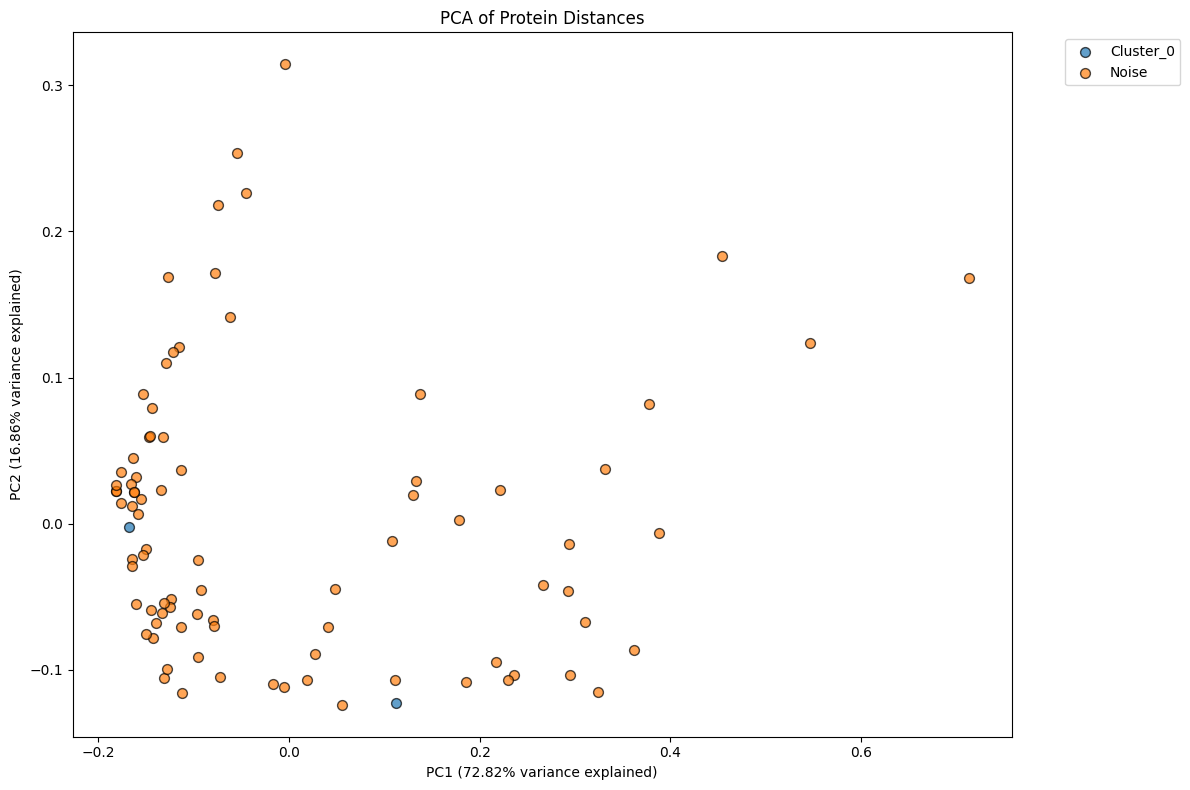


Explained variance ratio:
PC1: 72.82%
PC2: 16.86%
Total: 89.68%


In [102]:
from sklearn.decomposition import PCA

# Create PCA object
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization

# Fit and transform the distance matrix
# Using the cosine distance matrix, but you could also use euclidean or mutations
pca_result = pca.fit_transform(distance_matrix_embedding_cosine_alina)
print(pca_result.shape)

# Create the visualization
plt.figure(figsize=(12, 8))

# Create scatter plot
for label in set(labels):
    mask = np.array(labels) == label
    plt.scatter(
        pca_result[mask, 0],
        pca_result[mask, 1],
        label=label,
        alpha=0.7,
        s=50,
        edgecolor="k"
    )

plt.title("PCA of Protein Distances")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.2%} variance explained)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.2%} variance explained)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Print explained variance ratio
print("\nExplained variance ratio:")
print(f"PC1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"PC2: {pca.explained_variance_ratio_[1]:.2%}")
print(f"Total: {sum(pca.explained_variance_ratio_[:2]):.2%}")